In [25]:
# program to calculate ANN response surface given DoE points and responses

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import pandas as pd
from sklearn.preprocessing import scale
from sklearn import decomposition

import timeit
start = timeit.default_timer()

with open('test_fun.txt', 'w') as file:
    pd.read_excel('test_fun.xlsx').to_string(file, index=False,header=None)

In [26]:
# reading data into a file
xydata = open('test_fun.txt','r').readlines()

x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
x9 = []
x10 = []
x11 = []
x12 = []
corrosion_rate= []

for line in xydata:
    x1.append(float(line.split()[0]))
    x2.append(float(line.split()[1]))
    x3.append(float(line.split()[2]))
    x4.append(float(line.split()[3]))
    x5.append(float(line.split()[4]))
    x6.append(float(line.split()[5]))
    x7.append(float(line.split()[6]))
    x8.append(float(line.split()[7]))
    x9.append(float(line.split()[8]))
    x10.append(float(line.split()[9]))
    x11.append(float(line.split()[10]))
    x12.append(float(line.split()[11]))
    corrosion_rate.append(float(line.split()[12]))
    
print ('read finished')


# dimensional DoE points
x_dim = (np.vstack([x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12])).transpose()

# Calculating number of DoE points for matrix x
n=int(x_dim.shape[0])

# Calculating number of dvs
ndv=int(x_dim.shape[1])
print ('n = {0:d} ndv = {1:d}'.format(n,ndv))

# scale x1 and x2 design variables to lie between 0 and 1
x1_scaled = []
x2_scaled = []
x3_scaled = []
x4_scaled = []
x5_scaled = []
x6_scaled = []
x7_scaled = []
x8_scaled = []
x9_scaled = []
x10_scaled = []
x11_scaled = []
x12_scaled = []


for i in range(0,n):
    x1_scaled.append((x1[i]-min(x1))/(max(x1)-min(x1)))
    x2_scaled.append((x2[i]-min(x2))/(max(x2)-min(x2)))
    x3_scaled.append((x3[i]-min(x3))/(max(x3)-min(x3)))
    x4_scaled.append((x4[i]-min(x4))/(max(x4)-min(x4)))
    x5_scaled.append((x5[i]-min(x5))/(max(x5)-min(x5)))
    x6_scaled.append((x6[i]-min(x6))/(max(x6)-min(x6)))
    x7_scaled.append((x7[i]-min(x7))/(max(x7)-min(x7)))
    x8_scaled.append((x8[i]-min(x8))/(max(x8)-min(x8)))
    x9_scaled.append((x9[i]-min(x9))/(max(x9)-min(x9)))
    x10_scaled.append((x10[i]-min(x10))/(max(x10)-min(x10)))
    x11_scaled.append((x11[i]-min(x11))/(max(x11)-min(x11)))
    x12_scaled.append((x12[i]-min(x12))/(max(x12)-min(x12)))

read finished
n = 1000 ndv = 12


In [27]:
# vector of scaled DoE points
x_nondim = (np.vstack([x1_scaled,x2_scaled,x3_scaled,x4_scaled,x5_scaled,\
                      x6_scaled,x7_scaled,x8_scaled,x9_scaled,x10_scaled,x11_scaled,x12_scaled])).transpose()

# array of floats needed for use in ANN functions
x_scaled = np.array(x_nondim,dtype='float64')

# Now scale the objectives to lie between 0 and 1: objective 1 =
minobj1 = min(corrosion_rate)
denom1 = (max(corrosion_rate)-min(corrosion_rate))

o1 = []
for i in range(0,len(corrosion_rate)):
    o1.append((corrosion_rate[i]-minobj1)/denom1)

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, o1_train, o1_test = train_test_split(x_scaled, o1, test_size = 0.30)

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, o1_train, o1_test = train_test_split(x_scaled, o1, test_size = 0.30)
    
# array of floats needed for use in ANN functions

obj = np.array(o1_train,dtype='float64')

# Surrogate modelling of objective 1 - corrosion rates - using ANNs

# Sequential class - exactly creates ANN initialized as sequence of layers.structure.
ann_tr = tf.keras.models.Sequential()

units = 50

batch_size = 10

epochs = 50000

import os
import random

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(12345)
tf.random.set_seed(1234)

In [30]:
# Adding the input layer and the hidden layer
initializers = {
  "kernel_initializer": tf.keras.initializers.RandomNormal(seed=1337),
  "bias_initializer": tf.keras.initializers.Constant(value=0.1)    
}

# Use of Dense class - connection between input layer and hidden layer
ann_tr.add(tf.keras.layers.Dense(units = units, activation ='sigmoid', **initializers))

# Use of Dense class - connection between input layer and hidden layer
ann_tr.add(tf.keras.layers.Dense(units = units, activation ='relu', **initializers))

# # Use of Dense class - connection between input layer and hidden layer
ann_tr.add(tf.keras.layers.Dense(units = units, activation ='relu', **initializers))

# # Use of Dense class - connection between input layer and hidden layer
# ann_tr.add(tf.keras.layers.Dense(units = units, activation ='relu', **initializers))

# Use of Dense class - connection between input layer and hidden layer
# ann_tr.add(tf.keras.layers.Dense(units = units, activation ='relu', **initializers))

# Adding the output layer
ann_tr.add(tf.keras.layers.Dense(units=1))

# Compiling the ANN - the tool with which we perform stochastic Gradient descent.    
ann_tr.compile(optimizer = 'adam', loss = "mean_squared_error")

# Training the ANN model on the whole data set - no data partitioning

ann_tr.fit(x_train, obj, batch_size= batch_size, epochs = epochs)

obj_pred = ann_tr.predict(x_test)


# calculate RMSE for the cross validation
import math

MSE = np.square(np.subtract(o1_test,obj_pred)).mean()   
RMSE = math.sqrt(MSE)

print("Mean Square Error = {0:2}".format (MSE))   
      
print("Root Mean Square Error = {0:2}".format (RMSE))   

Epoch 1/50000
70/70 [==============================] - 0s 499us/step - loss: 0.0432
Epoch 2/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0365
Epoch 3/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0344
Epoch 4/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0338
Epoch 5/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0297
Epoch 6/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0223
Epoch 7/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0143
Epoch 8/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0125
Epoch 9/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0111
Epoch 10/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0115
Epoch 11/50000
70/70 [==============================] - 0s 463us/step - loss: 0.0100
Epoch 12/50000
70/70 [==============================] - 0s 470us/step - lo

70/70 [==============================] - 0s 556us/step - loss: 0.0080
Epoch 193/50000
70/70 [==============================] - 0s 541us/step - loss: 0.0085
Epoch 194/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0085
Epoch 195/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0080
Epoch 196/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0079
Epoch 197/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0087
Epoch 198/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0083
Epoch 199/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0082
Epoch 200/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0084
Epoch 201/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0082
Epoch 202/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0082
Epoch 203/50000
70/70 [==============================] - 0s 456us/step

70/70 [==============================] - 0s 456us/step - loss: 0.0075
Epoch 383/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0074
Epoch 384/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0079
Epoch 385/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0075
Epoch 386/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0077
Epoch 387/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0075
Epoch 388/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0076
Epoch 389/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0077
Epoch 390/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0077
Epoch 391/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0075
Epoch 392/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0075
Epoch 393/50000
70/70 [==============================] - 0s 470us/step

70/70 [==============================] - 0s 484us/step - loss: 0.0072
Epoch 478/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0072
Epoch 479/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0073
Epoch 480/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0072
Epoch 481/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0074
Epoch 482/50000
70/70 [==============================] - 0s 499us/step - loss: 0.0074
Epoch 483/50000
70/70 [==============================] - 0s 541us/step - loss: 0.0074
Epoch 484/50000
70/70 [==============================] - 0s 598us/step - loss: 0.0074
Epoch 485/50000
70/70 [==============================] - 0s 826us/step - loss: 0.0071
Epoch 486/50000
70/70 [==============================] - 0s 684us/step - loss: 0.0074
Epoch 487/50000
70/70 [==============================] - 0s 670us/step - loss: 0.0071
Epoch 488/50000
70/70 [==============================] - 0s 570us/step

70/70 [==============================] - 0s 413us/step - loss: 0.0069
Epoch 573/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0069
Epoch 574/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0069
Epoch 575/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0069
Epoch 576/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0069
Epoch 577/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0068
Epoch 578/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0072
Epoch 579/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0069
Epoch 580/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0069
Epoch 581/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0070
Epoch 582/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0069
Epoch 583/50000
70/70 [==============================] - 0s 427us/step

70/70 [==============================] - 0s 427us/step - loss: 0.0064
Epoch 762/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0063
Epoch 763/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0066
Epoch 764/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0064
Epoch 765/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0065
Epoch 766/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0064
Epoch 767/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0064
Epoch 768/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0063
Epoch 769/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0063
Epoch 770/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0064
Epoch 771/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0065
Epoch 772/50000
70/70 [==============================] - 0s 413us/step

70/70 [==============================] - 0s 470us/step - loss: 0.0057
Epoch 952/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0059
Epoch 953/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0056
Epoch 954/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0058
Epoch 955/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0057
Epoch 956/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0056
Epoch 957/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0059
Epoch 958/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0057
Epoch 959/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0056
Epoch 960/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0057
Epoch 961/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0058
Epoch 962/50000
70/70 [==============================] - 0s 427us/step

70/70 [==============================] - 0s 442us/step - loss: 0.0051
Epoch 1140/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0050
Epoch 1141/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0050
Epoch 1142/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0052
Epoch 1143/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0050
Epoch 1144/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0049
Epoch 1145/50000
70/70 [==============================] - 0s 399us/step - loss: 0.0050
Epoch 1146/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0051
Epoch 1147/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0051
Epoch 1148/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0050
Epoch 1149/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0051
Epoch 1150/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 427us/step - loss: 0.0043
Epoch 1328/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0044
Epoch 1329/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0045
Epoch 1330/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0044
Epoch 1331/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0048
Epoch 1332/50000
70/70 [==============================] - 0s 399us/step - loss: 0.0043
Epoch 1333/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0043
Epoch 1334/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0043
Epoch 1335/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0043
Epoch 1336/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0044
Epoch 1337/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0044
Epoch 1338/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 470us/step - loss: 0.0040
Epoch 1516/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0038
Epoch 1517/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0038
Epoch 1518/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0039
Epoch 1519/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0038
Epoch 1520/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0038
Epoch 1521/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0038
Epoch 1522/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0038
Epoch 1523/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0038
Epoch 1524/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0041
Epoch 1525/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0039
Epoch 1526/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 385us/step - loss: 0.0036
Epoch 1610/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0037
Epoch 1611/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0037
Epoch 1612/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0037
Epoch 1613/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0035
Epoch 1614/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0037
Epoch 1615/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0035
Epoch 1616/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0037
Epoch 1617/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0036
Epoch 1618/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0038
Epoch 1619/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0037
Epoch 1620/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 413us/step - loss: 0.0032
Epoch 1704/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0035
Epoch 1705/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0034
Epoch 1706/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0033
Epoch 1707/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0034
Epoch 1708/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0034
Epoch 1709/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0034
Epoch 1710/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0033
Epoch 1711/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0033
Epoch 1712/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0034
Epoch 1713/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0032
Epoch 1714/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 413us/step - loss: 0.0031
Epoch 1892/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0029
Epoch 1893/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0028
Epoch 1894/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0028
Epoch 1895/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0028
Epoch 1896/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0027
Epoch 1897/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0028
Epoch 1898/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0030
Epoch 1899/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0029
Epoch 1900/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0029
Epoch 1901/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0030
Epoch 1902/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 456us/step - loss: 0.0025
Epoch 2080/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0025
Epoch 2081/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0029
Epoch 2082/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0027
Epoch 2083/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0025
Epoch 2084/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0027
Epoch 2085/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0028
Epoch 2086/50000
70/70 [==============================] - 0s 399us/step - loss: 0.0025
Epoch 2087/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0025
Epoch 2088/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0024
Epoch 2089/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0024
Epoch 2090/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 442us/step - loss: 0.0025
Epoch 2174/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0024
Epoch 2175/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0024
Epoch 2176/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0025
Epoch 2177/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0023
Epoch 2178/50000
70/70 [==============================] - 0s 413us/step - loss: 0.0024
Epoch 2179/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0024
Epoch 2180/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0023
Epoch 2181/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0023
Epoch 2182/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0024
Epoch 2183/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0025
Epoch 2184/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 442us/step - loss: 0.0022
Epoch 2361/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0022
Epoch 2362/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0021
Epoch 2363/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0022
Epoch 2364/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0026
Epoch 2365/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0021
Epoch 2366/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0021
Epoch 2367/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0021
Epoch 2368/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0025
Epoch 2369/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0023
Epoch 2370/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0022
Epoch 2371/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 456us/step - loss: 0.0020
Epoch 2548/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0020
Epoch 2549/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0020
Epoch 2550/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0020
Epoch 2551/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0020
Epoch 2552/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0022
Epoch 2553/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0021
Epoch 2554/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0019
Epoch 2555/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0023
Epoch 2556/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0021
Epoch 2557/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0024
Epoch 2558/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 470us/step - loss: 0.0020
Epoch 2735/50000
70/70 [==============================] - 0s 527us/step - loss: 0.0020
Epoch 2736/50000
70/70 [==============================] - 0s 613us/step - loss: 0.0018
Epoch 2737/50000
70/70 [==============================] - 0s 541us/step - loss: 0.0018
Epoch 2738/50000
70/70 [==============================] - 0s 655us/step - loss: 0.0020
Epoch 2739/50000
70/70 [==============================] - 0s 541us/step - loss: 0.0020
Epoch 2740/50000
70/70 [==============================] - 0s 499us/step - loss: 0.0022
Epoch 2741/50000
70/70 [==============================] - 0s 499us/step - loss: 0.0019
Epoch 2742/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0019
Epoch 2743/50000
70/70 [==============================] - 0s 513us/step - loss: 0.0020
Epoch 2744/50000
70/70 [==============================] - 0s 556us/step - loss: 0.0019
Epoch 2745/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 513us/step - loss: 0.0019
Epoch 2922/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0018
Epoch 2923/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0020
Epoch 2924/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0018
Epoch 2925/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0017
Epoch 2926/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0018
Epoch 2927/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0018
Epoch 2928/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0019
Epoch 2929/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0019
Epoch 2930/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0018
Epoch 2931/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0017
Epoch 2932/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 442us/step - loss: 0.0013
Epoch 3109/50000
70/70 [==============================] - 0s 484us/step - loss: 0.0013
Epoch 3110/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0013
Epoch 3111/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0015
Epoch 3112/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0016
Epoch 3113/50000
70/70 [==============================] - 0s 470us/step - loss: 0.0015
Epoch 3114/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0014
Epoch 3115/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0013
Epoch 3116/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0013
Epoch 3117/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0012
Epoch 3118/50000
70/70 [==============================] - 0s 527us/step - loss: 0.0012
Epoch 3119/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 427us/step - loss: 0.0011
Epoch 3297/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0011
Epoch 3298/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0012
Epoch 3299/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0012
Epoch 3300/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0012
Epoch 3301/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0011
Epoch 3302/50000
70/70 [==============================] - 0s 399us/step - loss: 0.0011
Epoch 3303/50000
70/70 [==============================] - 0s 399us/step - loss: 0.0012
Epoch 3304/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0011
Epoch 3305/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0010
Epoch 3306/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0010
Epoch 3307/50000
70/70 [==============================] - 0s

70/70 [==============================] - 0s 427us/step - loss: 9.1845e-04
Epoch 3480/50000
70/70 [==============================] - 0s 456us/step - loss: 0.0011
Epoch 3481/50000
70/70 [==============================] - 0s 442us/step - loss: 0.0010
Epoch 3482/50000
70/70 [==============================] - 0s 427us/step - loss: 0.0011
Epoch 3483/50000
70/70 [==============================] - 0s 427us/step - loss: 9.5557e-04
Epoch 3484/50000
70/70 [==============================] - 0s 427us/step - loss: 9.1753e-04
Epoch 3485/50000
70/70 [==============================] - 0s 470us/step - loss: 8.8491e-04
Epoch 3486/50000
70/70 [==============================] - 0s 470us/step - loss: 9.3170e-04
Epoch 3487/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4079e-04
Epoch 3488/50000
70/70 [==============================] - 0s 427us/step - loss: 9.7156e-04
Epoch 3489/50000
70/70 [==============================] - 0s 456us/step - loss: 9.0629e-04
Epoch 3490/50000
70/70 [====

70/70 [==============================] - 0s 442us/step - loss: 8.7361e-04
Epoch 3570/50000
70/70 [==============================] - 0s 427us/step - loss: 8.3432e-04
Epoch 3571/50000
70/70 [==============================] - 0s 427us/step - loss: 7.9934e-04
Epoch 3572/50000
70/70 [==============================] - 0s 413us/step - loss: 9.7806e-04
Epoch 3573/50000
70/70 [==============================] - 0s 442us/step - loss: 7.9946e-04
Epoch 3574/50000
70/70 [==============================] - 0s 427us/step - loss: 8.0097e-04
Epoch 3575/50000
70/70 [==============================] - 0s 442us/step - loss: 8.6935e-04
Epoch 3576/50000
70/70 [==============================] - 0s 442us/step - loss: 9.0612e-04
Epoch 3577/50000
70/70 [==============================] - 0s 427us/step - loss: 9.1637e-04
Epoch 3578/50000
70/70 [==============================] - 0s 442us/step - loss: 9.6823e-04
Epoch 3579/50000
70/70 [==============================] - 0s 427us/step - loss: 8.8975e-04
Epoch 3580/50000

70/70 [==============================] - 0s 427us/step - loss: 6.3109e-04
Epoch 3749/50000
70/70 [==============================] - 0s 442us/step - loss: 7.8937e-04
Epoch 3750/50000
70/70 [==============================] - 0s 442us/step - loss: 7.0520e-04
Epoch 3751/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5790e-04
Epoch 3752/50000
70/70 [==============================] - 0s 427us/step - loss: 6.7602e-04
Epoch 3753/50000
70/70 [==============================] - 0s 427us/step - loss: 7.0089e-04
Epoch 3754/50000
70/70 [==============================] - 0s 456us/step - loss: 8.7617e-04
Epoch 3755/50000
70/70 [==============================] - 0s 442us/step - loss: 7.3035e-04
Epoch 3756/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2079e-04
Epoch 3757/50000
70/70 [==============================] - 0s 456us/step - loss: 7.7839e-04
Epoch 3758/50000
70/70 [==============================] - 0s 470us/step - loss: 7.2501e-04
Epoch 3759/50000

70/70 [==============================] - 0s 484us/step - loss: 8.7194e-04
Epoch 3838/50000
70/70 [==============================] - 0s 484us/step - loss: 9.3638e-04
Epoch 3839/50000
70/70 [==============================] - 0s 484us/step - loss: 8.4615e-04
Epoch 3840/50000
70/70 [==============================] - 0s 484us/step - loss: 7.5170e-04
Epoch 3841/50000
70/70 [==============================] - 0s 442us/step - loss: 7.8565e-04
Epoch 3842/50000
70/70 [==============================] - 0s 442us/step - loss: 9.2955e-04
Epoch 3843/50000
70/70 [==============================] - 0s 456us/step - loss: 7.6790e-04
Epoch 3844/50000
70/70 [==============================] - 0s 427us/step - loss: 7.4186e-04
Epoch 3845/50000
70/70 [==============================] - 0s 427us/step - loss: 7.1669e-04
Epoch 3846/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4971e-04
Epoch 3847/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4347e-04
Epoch 3848/50000

70/70 [==============================] - 0s 442us/step - loss: 8.1775e-04
Epoch 3928/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2914e-04
Epoch 3929/50000
70/70 [==============================] - 0s 442us/step - loss: 7.3208e-04
Epoch 3930/50000
70/70 [==============================] - 0s 442us/step - loss: 6.6650e-04
Epoch 3931/50000
70/70 [==============================] - 0s 456us/step - loss: 9.1140e-04
Epoch 3932/50000
70/70 [==============================] - 0s 456us/step - loss: 8.9443e-04
Epoch 3933/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4527e-04
Epoch 3934/50000
70/70 [==============================] - 0s 456us/step - loss: 7.3897e-04
Epoch 3935/50000
70/70 [==============================] - 0s 456us/step - loss: 6.9603e-04
Epoch 3936/50000
70/70 [==============================] - 0s 442us/step - loss: 6.1101e-04
Epoch 3937/50000
70/70 [==============================] - 0s 456us/step - loss: 7.8111e-04
Epoch 3938/50000

Epoch 4107/50000
70/70 [==============================] - 0s 413us/step - loss: 5.2970e-04
Epoch 4108/50000
70/70 [==============================] - 0s 413us/step - loss: 5.4639e-04
Epoch 4109/50000
70/70 [==============================] - 0s 456us/step - loss: 5.9783e-04
Epoch 4110/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4213e-04
Epoch 4111/50000
70/70 [==============================] - 0s 427us/step - loss: 5.9230e-04
Epoch 4112/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3905e-04
Epoch 4113/50000
70/70 [==============================] - 0s 442us/step - loss: 5.8853e-04
Epoch 4114/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7892e-04
Epoch 4115/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2304e-04
Epoch 4116/50000
70/70 [==============================] - 0s 442us/step - loss: 5.3479e-04
Epoch 4117/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6495e-04

70/70 [==============================] - 0s 470us/step - loss: 5.2956e-04
Epoch 4198/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6696e-04
Epoch 4199/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9677e-04
Epoch 4200/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0136e-04
Epoch 4201/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6140e-04
Epoch 4202/50000
70/70 [==============================] - 0s 427us/step - loss: 5.1268e-04
Epoch 4203/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7558e-04
Epoch 4204/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2151e-04
Epoch 4205/50000
70/70 [==============================] - 0s 385us/step - loss: 5.7494e-04
Epoch 4206/50000
70/70 [==============================] - 0s 413us/step - loss: 9.0471e-04
Epoch 4207/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1177e-04
Epoch 4208/50000

Epoch 4287/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3268e-04
Epoch 4288/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7784e-04
Epoch 4289/50000
70/70 [==============================] - 0s 427us/step - loss: 5.0890e-04
Epoch 4290/50000
70/70 [==============================] - 0s 427us/step - loss: 4.9135e-04
Epoch 4291/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8279e-04
Epoch 4292/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6712e-04
Epoch 4293/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6128e-04
Epoch 4294/50000
70/70 [==============================] - 0s 442us/step - loss: 4.9894e-04
Epoch 4295/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5002e-04
Epoch 4296/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6221e-04
Epoch 4297/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6856e-04

70/70 [==============================] - 0s 456us/step - loss: 3.7934e-04
Epoch 4467/50000
70/70 [==============================] - 0s 456us/step - loss: 3.9212e-04
Epoch 4468/50000
70/70 [==============================] - 0s 456us/step - loss: 3.7881e-04
Epoch 4469/50000
70/70 [==============================] - 0s 470us/step - loss: 5.9384e-04
Epoch 4470/50000
70/70 [==============================] - 0s 470us/step - loss: 4.8730e-04
Epoch 4471/50000
70/70 [==============================] - 0s 456us/step - loss: 5.2254e-04
Epoch 4472/50000
70/70 [==============================] - 0s 456us/step - loss: 4.5967e-04
Epoch 4473/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0162e-04
Epoch 4474/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4294e-04
Epoch 4475/50000
70/70 [==============================] - 0s 470us/step - loss: 4.3469e-04
Epoch 4476/50000
70/70 [==============================] - 0s 470us/step - loss: 5.4803e-04
Epoch 4477/50000

Epoch 4556/50000
70/70 [==============================] - 0s 527us/step - loss: 4.1301e-04
Epoch 4557/50000
70/70 [==============================] - 0s 556us/step - loss: 4.0216e-04
Epoch 4558/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3689e-04
Epoch 4559/50000
70/70 [==============================] - 0s 470us/step - loss: 5.1587e-04
Epoch 4560/50000
70/70 [==============================] - 0s 513us/step - loss: 4.0235e-04
Epoch 4561/50000
70/70 [==============================] - 0s 470us/step - loss: 3.6608e-04
Epoch 4562/50000
70/70 [==============================] - 0s 484us/step - loss: 3.9070e-04
Epoch 4563/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6539e-04
Epoch 4564/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0150e-04
Epoch 4565/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5330e-04
Epoch 4566/50000
70/70 [==============================] - 0s 456us/step - loss: 4.4149e-04

70/70 [==============================] - 0s 541us/step - loss: 4.2782e-04
Epoch 4736/50000
70/70 [==============================] - 0s 541us/step - loss: 3.3471e-04
Epoch 4737/50000
70/70 [==============================] - 0s 499us/step - loss: 4.9309e-04
Epoch 4738/50000
70/70 [==============================] - 0s 534us/step - loss: 3.9816e-04
Epoch 4739/50000
70/70 [==============================] - 0s 570us/step - loss: 6.1566e-04
Epoch 4740/50000
70/70 [==============================] - 0s 570us/step - loss: 7.6466e-04
Epoch 4741/50000
70/70 [==============================] - 0s 499us/step - loss: 4.4417e-04
Epoch 4742/50000
70/70 [==============================] - 0s 499us/step - loss: 3.6849e-04
Epoch 4743/50000
70/70 [==============================] - 0s 499us/step - loss: 3.3801e-04
Epoch 4744/50000
70/70 [==============================] - 0s 437us/step - loss: 3.5974e-04
Epoch 4745/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2675e-04
Epoch 4746/50000

70/70 [==============================] - 0s 427us/step - loss: 3.4289e-04
Epoch 4916/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0038e-04
Epoch 4917/50000
70/70 [==============================] - 0s 442us/step - loss: 4.9048e-04
Epoch 4918/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7808e-04
Epoch 4919/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6885e-04
Epoch 4920/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2954e-04
Epoch 4921/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1418e-04
Epoch 4922/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7391e-04
Epoch 4923/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3628e-04
Epoch 4924/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3073e-04
Epoch 4925/50000
70/70 [==============================] - 0s 456us/step - loss: 3.5971e-04
Epoch 4926/50000

70/70 [==============================] - 0s 470us/step - loss: 2.6707e-04
Epoch 5095/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7872e-04
Epoch 5096/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6816e-04
Epoch 5097/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9014e-04
Epoch 5098/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7782e-04
Epoch 5099/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4129e-04
Epoch 5100/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3384e-04
Epoch 5101/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1263e-04
Epoch 5102/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1542e-04
Epoch 5103/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1042e-04
Epoch 5104/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1239e-04
Epoch 5105/50000

70/70 [==============================] - 0s 442us/step - loss: 3.2212e-04
Epoch 5275/50000
70/70 [==============================] - 0s 456us/step - loss: 3.5904e-04
Epoch 5276/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7813e-04
Epoch 5277/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1949e-04
Epoch 5278/50000
70/70 [==============================] - ETA: 0s - loss: 2.3404e-0 - 0s 427us/step - loss: 3.1474e-04
Epoch 5279/50000
70/70 [==============================] - 0s 470us/step - loss: 3.2311e-04
Epoch 5280/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0682e-04
Epoch 5281/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2969e-04
Epoch 5282/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7722e-04
Epoch 5283/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3168e-04
Epoch 5284/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 3.7056e-04
Epoch 5453/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8370e-04
Epoch 5454/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7711e-04
Epoch 5455/50000
70/70 [==============================] - 0s 437us/step - loss: 2.4502e-04
Epoch 5456/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2402e-04
Epoch 5457/50000
70/70 [==============================] - 0s 399us/step - loss: 2.5468e-04
Epoch 5458/50000
70/70 [==============================] - 0s 527us/step - loss: 3.1252e-04
Epoch 5459/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5755e-04
Epoch 5460/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7888e-04
Epoch 5461/50000
70/70 [==============================] - 0s 499us/step - loss: 3.6072e-04
Epoch 5462/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4544e-04
Epoch 5463/50000

70/70 [==============================] - 0s 456us/step - loss: 2.6981e-04
Epoch 5632/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6155e-04
Epoch 5633/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5319e-04
Epoch 5634/50000
70/70 [==============================] - 0s 456us/step - loss: 2.3553e-04
Epoch 5635/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9711e-04
Epoch 5636/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1465e-04
Epoch 5637/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6978e-04
Epoch 5638/50000
70/70 [==============================] - 0s 556us/step - loss: 3.2398e-04
Epoch 5639/50000
70/70 [==============================] - 0s 513us/step - loss: 2.9225e-04
Epoch 5640/50000
70/70 [==============================] - 0s 513us/step - loss: 3.4499e-04
Epoch 5641/50000
70/70 [==============================] - 0s 513us/step - loss: 3.1494e-04
Epoch 5642/50000

70/70 [==============================] - 0s 456us/step - loss: 3.5873e-04
Epoch 5810/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2421e-04
Epoch 5811/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4323e-04
Epoch 5812/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7454e-04
Epoch 5813/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8572e-04
Epoch 5814/50000
70/70 [==============================] - 0s 466us/step - loss: 3.6040e-04
Epoch 5815/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9160e-04
Epoch 5816/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4282e-04
Epoch 5817/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7711e-04
Epoch 5818/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3171e-04
Epoch 5819/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8682e-04
Epoch 5820/50000

70/70 [==============================] - 0s 456us/step - loss: 2.2358e-04
Epoch 5988/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6457e-04
Epoch 5989/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5291e-04
Epoch 5990/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7642e-04
Epoch 5991/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5679e-04
Epoch 5992/50000
70/70 [==============================] - 0s 385us/step - loss: 4.7316e-04
Epoch 5993/50000
70/70 [==============================] - 0s 399us/step - loss: 5.5763e-04
Epoch 5994/50000
70/70 [==============================] - 0s 385us/step - loss: 3.1013e-04
Epoch 5995/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8491e-04
Epoch 5996/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2567e-04
Epoch 5997/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0400e-04
Epoch 5998/50000

70/70 [==============================] - 0s 427us/step - loss: 3.3915e-04
Epoch 6168/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9857e-04
Epoch 6169/50000
70/70 [==============================] - 0s 427us/step - loss: 2.6235e-04
Epoch 6170/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8028e-04
Epoch 6171/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1786e-04
Epoch 6172/50000
70/70 [==============================] - ETA: 0s - loss: 7.5124e-0 - 0s 427us/step - loss: 2.0859e-04
Epoch 6173/50000
70/70 [==============================] - 0s 413us/step - loss: 3.0150e-04
Epoch 6174/50000
70/70 [==============================] - 0s 413us/step - loss: 1.9882e-04
Epoch 6175/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4890e-04
Epoch 6176/50000
70/70 [==============================] - 0s 413us/step - loss: 2.0673e-04
Epoch 6177/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 1.9959e-04
Epoch 6347/50000
70/70 [==============================] - 0s 499us/step - loss: 5.8163e-04
Epoch 6348/50000
70/70 [==============================] - 0s 570us/step - loss: 3.7980e-04
Epoch 6349/50000
70/70 [==============================] - 0s 670us/step - loss: 4.0907e-04
Epoch 6350/50000
70/70 [==============================] - 0s 712us/step - loss: 2.2731e-04
Epoch 6351/50000
70/70 [==============================] - 0s 613us/step - loss: 2.3482e-04
Epoch 6352/50000
70/70 [==============================] - 0s 584us/step - loss: 1.6619e-04
Epoch 6353/50000
70/70 [==============================] - 0s 627us/step - loss: 1.5576e-04
Epoch 6354/50000
70/70 [==============================] - 0s 598us/step - loss: 1.8492e-04
Epoch 6355/50000
70/70 [==============================] - 0s 755us/step - loss: 1.6348e-04
Epoch 6356/50000
70/70 [==============================] - 0s 912us/step - loss: 1.6268e-04
Epoch 6357/50000

70/70 [==============================] - 0s 584us/step - loss: 2.2117e-04
Epoch 6525/50000
70/70 [==============================] - 0s 613us/step - loss: 2.2899e-04
Epoch 6526/50000
70/70 [==============================] - 0s 570us/step - loss: 2.1247e-04
Epoch 6527/50000
70/70 [==============================] - 0s 541us/step - loss: 1.7562e-04
Epoch 6528/50000
70/70 [==============================] - 0s 527us/step - loss: 1.7806e-04
Epoch 6529/50000
70/70 [==============================] - 0s 584us/step - loss: 2.5895e-04
Epoch 6530/50000
70/70 [==============================] - 0s 556us/step - loss: 3.2659e-04
Epoch 6531/50000
70/70 [==============================] - 0s 556us/step - loss: 2.4515e-04
Epoch 6532/50000
70/70 [==============================] - 0s 570us/step - loss: 2.2125e-04
Epoch 6533/50000
70/70 [==============================] - 0s 541us/step - loss: 1.9466e-04
Epoch 6534/50000
70/70 [==============================] - 0s 541us/step - loss: 4.2856e-04
Epoch 6535/50000

70/70 [==============================] - 0s 470us/step - loss: 1.6725e-04
Epoch 6705/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6275e-04
Epoch 6706/50000
70/70 [==============================] - 0s 484us/step - loss: 1.9892e-04
Epoch 6707/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1035e-04
Epoch 6708/50000
70/70 [==============================] - 0s 470us/step - loss: 2.1551e-04
Epoch 6709/50000
70/70 [==============================] - 0s 484us/step - loss: 3.1464e-04
Epoch 6710/50000
70/70 [==============================] - 0s 530us/step - loss: 4.0068e-04
Epoch 6711/50000
70/70 [==============================] - 0s 514us/step - loss: 5.4499e-04
Epoch 6712/50000
70/70 [==============================] - 0s 484us/step - loss: 3.1709e-04
Epoch 6713/50000
70/70 [==============================] - 0s 457us/step - loss: 2.6995e-04
Epoch 6714/50000
70/70 [==============================] - 0s 598us/step - loss: 1.7203e-04
Epoch 6715/50000

Epoch 6794/50000
70/70 [==============================] - 0s 841us/step - loss: 1.3545e-04
Epoch 6795/50000
70/70 [==============================] - 0s 698us/step - loss: 1.5736e-04
Epoch 6796/50000
70/70 [==============================] - 0s 698us/step - loss: 1.5837e-04
Epoch 6797/50000
70/70 [==============================] - 0s 630us/step - loss: 1.9404e-04
Epoch 6798/50000
70/70 [==============================] - 0s 617us/step - loss: 2.4688e-04
Epoch 6799/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.5522e-04
Epoch 6800/50000
70/70 [==============================] - ETA: 0s - loss: 1.4847e-0 - 0s 826us/step - loss: 1.4873e-04
Epoch 6801/50000
70/70 [==============================] - 0s 656us/step - loss: 1.3080e-04
Epoch 6802/50000
70/70 [==============================] - 0s 797us/step - loss: 1.2583e-04
Epoch 6803/50000
70/70 [==============================] - 0s 641us/step - loss: 1.5561e-04
Epoch 6804/50000
70/70 [==============================] - 0s 883

70/70 [==============================] - 0s 499us/step - loss: 2.4584e-04
Epoch 6973/50000
70/70 [==============================] - 0s 464us/step - loss: 1.6513e-04
Epoch 6974/50000
70/70 [==============================] - 0s 481us/step - loss: 1.7760e-04
Epoch 6975/50000
70/70 [==============================] - 0s 484us/step - loss: 2.3074e-04
Epoch 6976/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0994e-04
Epoch 6977/50000
70/70 [==============================] - ETA: 0s - loss: 1.5402e-0 - 0s 446us/step - loss: 1.5160e-04
Epoch 6978/50000
70/70 [==============================] - 0s 522us/step - loss: 1.7096e-04
Epoch 6979/50000
70/70 [==============================] - 0s 480us/step - loss: 2.0641e-04
Epoch 6980/50000
70/70 [==============================] - 0s 527us/step - loss: 1.9790e-04
Epoch 6981/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6387e-04
Epoch 6982/50000
70/70 [==============================] - 0s 484us/step - loss:

Epoch 7151/50000
70/70 [==============================] - 0s 556us/step - loss: 2.0278e-04
Epoch 7152/50000
70/70 [==============================] - 0s 556us/step - loss: 1.5354e-04
Epoch 7153/50000
70/70 [==============================] - ETA: 0s - loss: 1.9027e-0 - 0s 541us/step - loss: 1.4051e-04
Epoch 7154/50000
70/70 [==============================] - 0s 570us/step - loss: 1.5239e-04
Epoch 7155/50000
70/70 [==============================] - 0s 541us/step - loss: 1.8283e-04
Epoch 7156/50000
70/70 [==============================] - 0s 598us/step - loss: 1.3056e-04
Epoch 7157/50000
70/70 [==============================] - 0s 556us/step - loss: 1.3335e-04
Epoch 7158/50000
70/70 [==============================] - 0s 591us/step - loss: 1.8544e-04
Epoch 7159/50000
70/70 [==============================] - 0s 527us/step - loss: 2.9484e-04
Epoch 7160/50000
70/70 [==============================] - 0s 527us/step - loss: 4.4988e-04
Epoch 7161/50000
70/70 [==============================] - 0s 5

70/70 [==============================] - 0s 399us/step - loss: 2.8888e-04
Epoch 7330/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8428e-04
Epoch 7331/50000
70/70 [==============================] - 0s 427us/step - loss: 1.9184e-04
Epoch 7332/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7153e-04
Epoch 7333/50000
70/70 [==============================] - 0s 442us/step - loss: 1.7381e-04
Epoch 7334/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2500e-04
Epoch 7335/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2771e-04
Epoch 7336/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3566e-04
Epoch 7337/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2623e-04
Epoch 7338/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3351e-04
Epoch 7339/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3382e-04
Epoch 7340/50000

70/70 [==============================] - 0s 484us/step - loss: 1.4463e-04
Epoch 7509/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4513e-04
Epoch 7510/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6144e-04
Epoch 7511/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9656e-04
Epoch 7512/50000
70/70 [==============================] - 0s 499us/step - loss: 1.7447e-04
Epoch 7513/50000
70/70 [==============================] - 0s 474us/step - loss: 1.4757e-04
Epoch 7514/50000
70/70 [==============================] - 0s 470us/step - loss: 2.0205e-04
Epoch 7515/50000
70/70 [==============================] - 0s 484us/step - loss: 2.7815e-04
Epoch 7516/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4764e-04
Epoch 7517/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4585e-04
Epoch 7518/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1279e-04
Epoch 7519/50000

70/70 [==============================] - 0s 470us/step - loss: 2.8619e-04
Epoch 7687/50000
70/70 [==============================] - 0s 556us/step - loss: 1.5161e-04
Epoch 7688/50000
70/70 [==============================] - 0s 499us/step - loss: 1.3422e-04
Epoch 7689/50000
70/70 [==============================] - 0s 534us/step - loss: 1.5293e-04
Epoch 7690/50000
70/70 [==============================] - 0s 527us/step - loss: 1.1787e-04
Epoch 7691/50000
70/70 [==============================] - 0s 470us/step - loss: 9.3789e-05
Epoch 7692/50000
70/70 [==============================] - 0s 484us/step - loss: 1.0842e-04
Epoch 7693/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4137e-04
Epoch 7694/50000
70/70 [==============================] - 0s 499us/step - loss: 1.4843e-04
Epoch 7695/50000
70/70 [==============================] - 0s 513us/step - loss: 2.8134e-04
Epoch 7696/50000
70/70 [==============================] - 0s 470us/step - loss: 3.0468e-04
Epoch 7697/50000

70/70 [==============================] - 0s 470us/step - loss: 1.4913e-04
Epoch 7866/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3193e-04
Epoch 7867/50000
70/70 [==============================] - 0s 481us/step - loss: 1.4078e-04
Epoch 7868/50000
70/70 [==============================] - 0s 470us/step - loss: 1.7163e-04
Epoch 7869/50000
70/70 [==============================] - 0s 470us/step - loss: 1.7578e-04
Epoch 7870/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0695e-04
Epoch 7871/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1553e-04
Epoch 7872/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9306e-04
Epoch 7873/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4444e-04
Epoch 7874/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2778e-04
Epoch 7875/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1265e-04
Epoch 7876/50000

Epoch 7955/50000
70/70 [==============================] - 0s 442us/step - loss: 9.3264e-05
Epoch 7956/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2458e-04
Epoch 7957/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1282e-04
Epoch 7958/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0577e-04
Epoch 7959/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6008e-04
Epoch 7960/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3350e-04
Epoch 7961/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7477e-04
Epoch 7962/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6141e-04
Epoch 7963/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8618e-04
Epoch 7964/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6174e-04
Epoch 7965/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6388e-04

70/70 [==============================] - 0s 413us/step - loss: 1.3850e-04
Epoch 8135/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8013e-04
Epoch 8136/50000
70/70 [==============================] - 0s 442us/step - loss: 8.0893e-04
Epoch 8137/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7976e-04
Epoch 8138/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4605e-04
Epoch 8139/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5723e-04
Epoch 8140/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3936e-04
Epoch 8141/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1452e-04
Epoch 8142/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3037e-04
Epoch 8143/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1860e-04
Epoch 8144/50000
70/70 [==============================] - 0s 442us/step - loss: 8.5628e-05
Epoch 8145/50000

70/70 [==============================] - 0s 442us/step - loss: 1.2034e-04
Epoch 8314/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0666e-04
Epoch 8315/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1873e-04
Epoch 8316/50000
70/70 [==============================] - 0s 456us/step - loss: 9.5588e-05
Epoch 8317/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3552e-04
Epoch 8318/50000
70/70 [==============================] - 0s 413us/step - loss: 2.7782e-04
Epoch 8319/50000
70/70 [==============================] - 0s 442us/step - loss: 5.1201e-04
Epoch 8320/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3364e-04
Epoch 8321/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8060e-04
Epoch 8322/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5989e-04
Epoch 8323/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4000e-04
Epoch 8324/50000

70/70 [==============================] - 0s 442us/step - loss: 9.0963e-05
Epoch 8492/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0776e-04
Epoch 8493/50000
70/70 [==============================] - 0s 427us/step - loss: 7.9422e-05
Epoch 8494/50000
70/70 [==============================] - 0s 442us/step - loss: 8.6769e-05
Epoch 8495/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0047e-04
Epoch 8496/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2252e-04
Epoch 8497/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2635e-04
Epoch 8498/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0247e-04
Epoch 8499/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4998e-04
Epoch 8500/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0676e-04
Epoch 8501/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1681e-04
Epoch 8502/50000

70/70 [==============================] - 0s 427us/step - loss: 1.0061e-04
Epoch 8670/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7277e-04
Epoch 8671/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3666e-04
Epoch 8672/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3305e-04
Epoch 8673/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4144e-04
Epoch 8674/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4884e-04
Epoch 8675/50000
70/70 [==============================] - 0s 413us/step - loss: 2.1920e-04
Epoch 8676/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3637e-04
Epoch 8677/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0213e-04
Epoch 8678/50000
70/70 [==============================] - 0s 427us/step - loss: 9.4027e-05
Epoch 8679/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0097e-04
Epoch 8680/50000

70/70 [==============================] - 0s 427us/step - loss: 1.3791e-04
Epoch 8848/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0899e-04
Epoch 8849/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4199e-04
Epoch 8850/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5393e-04
Epoch 8851/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1254e-04
Epoch 8852/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4776e-04
Epoch 8853/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2574e-04
Epoch 8854/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8469e-04
Epoch 8855/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0314e-04
Epoch 8856/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0479e-04
Epoch 8857/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2001e-04
Epoch 8858/50000

70/70 [==============================] - 0s 370us/step - loss: 1.7203e-04
Epoch 9027/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6166e-04
Epoch 9028/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0016e-04
Epoch 9029/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1224e-04
Epoch 9030/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0650e-04
Epoch 9031/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0058e-04
Epoch 9032/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1696e-04
Epoch 9033/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0920e-04
Epoch 9034/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8133e-04
Epoch 9035/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6925e-04
Epoch 9036/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5169e-04
Epoch 9037/50000

70/70 [==============================] - 0s 442us/step - loss: 1.2334e-04
Epoch 9206/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9134e-04
Epoch 9207/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4526e-04
Epoch 9208/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4189e-04
Epoch 9209/50000
70/70 [==============================] - 0s 442us/step - loss: 8.8264e-05
Epoch 9210/50000
70/70 [==============================] - 0s 427us/step - loss: 8.8092e-05
Epoch 9211/50000
70/70 [==============================] - 0s 427us/step - loss: 9.4552e-05
Epoch 9212/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0178e-04
Epoch 9213/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0163e-04
Epoch 9214/50000
70/70 [==============================] - 0s 427us/step - loss: 9.9447e-05
Epoch 9215/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3650e-04
Epoch 9216/50000

70/70 [==============================] - 0s 442us/step - loss: 7.4982e-05
Epoch 9384/50000
70/70 [==============================] - 0s 427us/step - loss: 6.9116e-05
Epoch 9385/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4555e-05
Epoch 9386/50000
70/70 [==============================] - 0s 413us/step - loss: 7.1690e-05
Epoch 9387/50000
70/70 [==============================] - 0s 413us/step - loss: 8.4678e-05
Epoch 9388/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3958e-04
Epoch 9389/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6169e-04
Epoch 9390/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7996e-04
Epoch 9391/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2649e-04
Epoch 9392/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2524e-04
Epoch 9393/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0645e-04
Epoch 9394/50000

70/70 [==============================] - 0s 413us/step - loss: 1.2873e-04
Epoch 9562/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0031e-04
Epoch 9563/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1014e-04
Epoch 9564/50000
70/70 [==============================] - 0s 442us/step - loss: 9.5033e-05
Epoch 9565/50000
70/70 [==============================] - 0s 413us/step - loss: 9.7306e-05
Epoch 9566/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1430e-05
Epoch 9567/50000
70/70 [==============================] - 0s 442us/step - loss: 9.4887e-05
Epoch 9568/50000
70/70 [==============================] - 0s 427us/step - loss: 8.7874e-05
Epoch 9569/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8112e-05
Epoch 9570/50000
70/70 [==============================] - 0s 413us/step - loss: 9.6831e-05
Epoch 9571/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2444e-04
Epoch 9572/50000

70/70 [==============================] - 0s 413us/step - loss: 1.2625e-04
Epoch 9742/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7522e-04
Epoch 9743/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5997e-04
Epoch 9744/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8504e-04
Epoch 9745/50000
70/70 [==============================] - 0s 413us/step - loss: 1.9286e-04
Epoch 9746/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4808e-04
Epoch 9747/50000
70/70 [==============================] - 0s 413us/step - loss: 8.6527e-05
Epoch 9748/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8916e-05
Epoch 9749/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0947e-04
Epoch 9750/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1792e-04
Epoch 9751/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0071e-04
Epoch 9752/50000

Epoch 9830/50000
70/70 [==============================] - 0s 484us/step - loss: 1.6250e-04
Epoch 9831/50000
70/70 [==============================] - 0s 513us/step - loss: 1.4095e-04
Epoch 9832/50000
70/70 [==============================] - 0s 527us/step - loss: 9.0088e-05
Epoch 9833/50000
70/70 [==============================] - 0s 513us/step - loss: 6.3234e-05
Epoch 9834/50000
70/70 [==============================] - 0s 484us/step - loss: 5.7013e-05
Epoch 9835/50000
70/70 [==============================] - 0s 484us/step - loss: 5.1268e-05
Epoch 9836/50000
70/70 [==============================] - 0s 499us/step - loss: 5.8953e-05
Epoch 9837/50000
70/70 [==============================] - 0s 484us/step - loss: 8.5115e-05
Epoch 9838/50000
70/70 [==============================] - 0s 499us/step - loss: 7.4226e-05
Epoch 9839/50000
70/70 [==============================] - 0s 527us/step - loss: 7.9452e-05
Epoch 9840/50000
70/70 [==============================] - 0s 470us/step - loss: 6.0522e-05

70/70 [==============================] - 0s 456us/step - loss: 1.0456e-04
Epoch 10009/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5920e-04
Epoch 10010/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1873e-04
Epoch 10011/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5998e-04
Epoch 10012/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5344e-04
Epoch 10013/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5043e-04
Epoch 10014/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5667e-04
Epoch 10015/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1536e-04
Epoch 10016/50000
70/70 [==============================] - 0s 470us/step - loss: 6.7638e-05
Epoch 10017/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0031e-04
Epoch 10018/50000
70/70 [==============================] - 0s 470us/step - loss: 6.7887e-05
Epoch 

Epoch 10097/50000
70/70 [==============================] - 0s 484us/step - loss: 1.7340e-04
Epoch 10098/50000
70/70 [==============================] - 0s 484us/step - loss: 1.0238e-04
Epoch 10099/50000
70/70 [==============================] - 0s 470us/step - loss: 8.2226e-05
Epoch 10100/50000
70/70 [==============================] - 0s 484us/step - loss: 7.4137e-05
Epoch 10101/50000
70/70 [==============================] - 0s 484us/step - loss: 1.0029e-04
Epoch 10102/50000
70/70 [==============================] - 0s 484us/step - loss: 8.7655e-05
Epoch 10103/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4112e-04
Epoch 10104/50000
70/70 [==============================] - 0s 484us/step - loss: 8.4977e-05
Epoch 10105/50000
70/70 [==============================] - 0s 470us/step - loss: 5.1891e-05
Epoch 10106/50000
70/70 [==============================] - 0s 484us/step - loss: 5.4667e-05
Epoch 10107/50000
70/70 [==============================] - 0s 513us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 9.3881e-05
Epoch 10187/50000
70/70 [==============================] - 0s 456us/step - loss: 9.8995e-05
Epoch 10188/50000
70/70 [==============================] - 0s 484us/step - loss: 1.1552e-04
Epoch 10189/50000
70/70 [==============================] - 0s 456us/step - loss: 9.3595e-05
Epoch 10190/50000
70/70 [==============================] - 0s 456us/step - loss: 8.8868e-05
Epoch 10191/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2641e-04
Epoch 10192/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2152e-04
Epoch 10193/50000
70/70 [==============================] - 0s 470us/step - loss: 2.1108e-04
Epoch 10194/50000
70/70 [==============================] - 0s 442us/step - loss: 9.7826e-05
Epoch 10195/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0660e-05
Epoch 10196/50000
70/70 [==============================] - 0s 499us/step - loss: 6.1063e-05
Epoch 

Epoch 10364/50000
70/70 [==============================] - 0s 413us/step - loss: 5.6619e-05
Epoch 10365/50000
70/70 [==============================] - 0s 413us/step - loss: 5.3326e-05
Epoch 10366/50000
70/70 [==============================] - 0s 427us/step - loss: 5.6809e-05
Epoch 10367/50000
70/70 [==============================] - 0s 427us/step - loss: 5.6186e-05
Epoch 10368/50000
70/70 [==============================] - 0s 413us/step - loss: 7.4353e-05
Epoch 10369/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8230e-05
Epoch 10370/50000
70/70 [==============================] - 0s 427us/step - loss: 7.3901e-05
Epoch 10371/50000
70/70 [==============================] - 0s 442us/step - loss: 8.2566e-05
Epoch 10372/50000
70/70 [==============================] - 0s 427us/step - loss: 9.6694e-05
Epoch 10373/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2925e-04
Epoch 10374/50000
70/70 [==============================] - 0s 513us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 1.0608e-04
Epoch 10454/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2474e-04
Epoch 10455/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0666e-04
Epoch 10456/50000
70/70 [==============================] - 0s 413us/step - loss: 8.7751e-05
Epoch 10457/50000
70/70 [==============================] - 0s 427us/step - loss: 8.4068e-05
Epoch 10458/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3045e-04
Epoch 10459/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8666e-04
Epoch 10460/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7793e-04
Epoch 10461/50000
70/70 [==============================] - 0s 399us/step - loss: 1.3865e-04
Epoch 10462/50000
70/70 [==============================] - 0s 427us/step - loss: 9.5253e-05
Epoch 10463/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1870e-04
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 6.4588e-05
Epoch 10632/50000
70/70 [==============================] - 0s 413us/step - loss: 5.7923e-05
Epoch 10633/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4053e-04
Epoch 10634/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5649e-04
Epoch 10635/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0209e-04
Epoch 10636/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1200e-04
Epoch 10637/50000
70/70 [==============================] - 0s 399us/step - loss: 7.8114e-05
Epoch 10638/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1551e-04
Epoch 10639/50000
70/70 [==============================] - 0s 456us/step - loss: 8.1529e-05
Epoch 10640/50000
70/70 [==============================] - 0s 427us/step - loss: 8.7550e-05
Epoch 10641/50000
70/70 [==============================] - 0s 399us/step - loss: 8.0420e-05
Epoch 

Epoch 10809/50000
70/70 [==============================] - 0s 413us/step - loss: 6.4139e-05
Epoch 10810/50000
70/70 [==============================] - 0s 427us/step - loss: 5.5799e-05
Epoch 10811/50000
70/70 [==============================] - 0s 427us/step - loss: 5.1088e-05
Epoch 10812/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1482e-04
Epoch 10813/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3287e-04
Epoch 10814/50000
70/70 [==============================] - 0s 399us/step - loss: 1.5280e-04
Epoch 10815/50000
70/70 [==============================] - 0s 427us/step - loss: 9.6098e-05
Epoch 10816/50000
70/70 [==============================] - 0s 399us/step - loss: 9.8532e-05
Epoch 10817/50000
70/70 [==============================] - 0s 427us/step - loss: 9.1647e-05
Epoch 10818/50000
70/70 [==============================] - 0s 413us/step - loss: 8.9484e-05
Epoch 10819/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 3.8039e-05
Epoch 10899/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5516e-05
Epoch 10900/50000
70/70 [==============================] - 0s 413us/step - loss: 4.9945e-05
Epoch 10901/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5021e-05
Epoch 10902/50000
70/70 [==============================] - 0s 413us/step - loss: 6.2384e-05
Epoch 10903/50000
70/70 [==============================] - 0s 442us/step - loss: 6.5515e-05
Epoch 10904/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9280e-05
Epoch 10905/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8676e-05
Epoch 10906/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5439e-05
Epoch 10907/50000
70/70 [==============================] - 0s 413us/step - loss: 6.8942e-05
Epoch 10908/50000
70/70 [==============================] - 0s 399us/step - loss: 8.3583e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 1.5392e-04
Epoch 11077/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2089e-04
Epoch 11078/50000
70/70 [==============================] - 0s 413us/step - loss: 6.2176e-05
Epoch 11079/50000
70/70 [==============================] - 0s 413us/step - loss: 4.6379e-05
Epoch 11080/50000
70/70 [==============================] - 0s 413us/step - loss: 4.3551e-05
Epoch 11081/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8323e-05
Epoch 11082/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3165e-05
Epoch 11083/50000
70/70 [==============================] - 0s 399us/step - loss: 6.1422e-05
Epoch 11084/50000
70/70 [==============================] - 0s 399us/step - loss: 5.5538e-05
Epoch 11085/50000
70/70 [==============================] - 0s 428us/step - loss: 5.5785e-05
Epoch 11086/50000
70/70 [==============================] - 0s 427us/step - loss: 5.4524e-05
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 9.3191e-05
Epoch 11255/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0139e-04
Epoch 11256/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1498e-05
Epoch 11257/50000
70/70 [==============================] - 0s 399us/step - loss: 7.1486e-05
Epoch 11258/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4283e-05
Epoch 11259/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9550e-05
Epoch 11260/50000
70/70 [==============================] - 0s 399us/step - loss: 6.6559e-05
Epoch 11261/50000
70/70 [==============================] - 0s 427us/step - loss: 7.9099e-05
Epoch 11262/50000
70/70 [==============================] - 0s 413us/step - loss: 9.8537e-05
Epoch 11263/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0927e-04
Epoch 11264/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3801e-04
Epoch 

Epoch 11343/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2508e-04
Epoch 11344/50000
70/70 [==============================] - 0s 413us/step - loss: 2.6284e-04
Epoch 11345/50000
70/70 [==============================] - 0s 399us/step - loss: 3.1853e-04
Epoch 11346/50000
70/70 [==============================] - 0s 399us/step - loss: 1.4135e-04
Epoch 11347/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3122e-04
Epoch 11348/50000
70/70 [==============================] - 0s 413us/step - loss: 9.7337e-05
Epoch 11349/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4748e-05
Epoch 11350/50000
70/70 [==============================] - 0s 413us/step - loss: 6.6666e-05
Epoch 11351/50000
70/70 [==============================] - 0s 399us/step - loss: 6.2601e-05
Epoch 11352/50000
70/70 [==============================] - 0s 413us/step - loss: 6.5879e-05
Epoch 11353/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 6.6586e-05
Epoch 11433/50000
70/70 [==============================] - 0s 427us/step - loss: 6.1751e-05
Epoch 11434/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6121e-04
Epoch 11435/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6595e-04
Epoch 11436/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6973e-04
Epoch 11437/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5858e-04
Epoch 11438/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2490e-04
Epoch 11439/50000
70/70 [==============================] - 0s 413us/step - loss: 8.7163e-05
Epoch 11440/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0025e-04
Epoch 11441/50000
70/70 [==============================] - 0s 399us/step - loss: 7.2554e-05
Epoch 11442/50000
70/70 [==============================] - 0s 413us/step - loss: 6.6505e-05
Epoch 

Epoch 11521/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0277e-04
Epoch 11522/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0962e-04
Epoch 11523/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8773e-04
Epoch 11524/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8547e-04
Epoch 11525/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5326e-04
Epoch 11526/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0617e-04
Epoch 11527/50000
70/70 [==============================] - 0s 442us/step - loss: 8.5134e-05
Epoch 11528/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5245e-05
Epoch 11529/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0086e-04
Epoch 11530/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6374e-05
Epoch 11531/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 1.0756e-04
Epoch 11610/50000
70/70 [==============================] - 0s 413us/step - loss: 8.6007e-05
Epoch 11611/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4193e-04
Epoch 11612/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5389e-04
Epoch 11613/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4574e-04
Epoch 11614/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6004e-04
Epoch 11615/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1218e-04
Epoch 11616/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5481e-04
Epoch 11617/50000
70/70 [==============================] - 0s 427us/step - loss: 9.8465e-05
Epoch 11618/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8180e-05
Epoch 11619/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6947e-05
Epoch 

Epoch 11787/50000
70/70 [==============================] - 0s 399us/step - loss: 2.1747e-04
Epoch 11788/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3760e-04
Epoch 11789/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0662e-04
Epoch 11790/50000
70/70 [==============================] - 0s 413us/step - loss: 8.3670e-05
Epoch 11791/50000
70/70 [==============================] - 0s 413us/step - loss: 9.2886e-05
Epoch 11792/50000
70/70 [==============================] - 0s 399us/step - loss: 9.1986e-05
Epoch 11793/50000
70/70 [==============================] - 0s 413us/step - loss: 6.8273e-05
Epoch 11794/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0110e-04
Epoch 11795/50000
70/70 [==============================] - 0s 399us/step - loss: 9.9095e-05
Epoch 11796/50000
70/70 [==============================] - 0s 413us/step - loss: 7.4446e-05
Epoch 11797/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 7.3650e-05
Epoch 11965/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1613e-04
Epoch 11966/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4006e-04
Epoch 11967/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2667e-04
Epoch 11968/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0094e-04
Epoch 11969/50000
70/70 [==============================] - 0s 442us/step - loss: 8.0560e-05
Epoch 11970/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4488e-05
Epoch 11971/50000
70/70 [==============================] - 0s 427us/step - loss: 9.2987e-05
Epoch 11972/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0515e-04
Epoch 11973/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0111e-04
Epoch 11974/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0033e-04
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 5.4290e-05
Epoch 12143/50000
70/70 [==============================] - 0s 427us/step - loss: 5.4848e-05
Epoch 12144/50000
70/70 [==============================] - 0s 399us/step - loss: 5.3124e-05
Epoch 12145/50000
70/70 [==============================] - 0s 399us/step - loss: 8.1240e-05
Epoch 12146/50000
70/70 [==============================] - 0s 399us/step - loss: 6.2177e-05
Epoch 12147/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7076e-05
Epoch 12148/50000
70/70 [==============================] - 0s 413us/step - loss: 7.7100e-05
Epoch 12149/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1468e-04
Epoch 12150/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0951e-04
Epoch 12151/50000
70/70 [==============================] - 0s 413us/step - loss: 7.8493e-05
Epoch 12152/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1862e-04
Epoch 

Epoch 12319/50000
70/70 [==============================] - 0s 413us/step - loss: 4.4815e-05
Epoch 12320/50000
70/70 [==============================] - 0s 413us/step - loss: 4.7855e-05
Epoch 12321/50000
70/70 [==============================] - 0s 413us/step - loss: 4.4863e-05
Epoch 12322/50000
70/70 [==============================] - 0s 399us/step - loss: 3.6723e-05
Epoch 12323/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9644e-05
Epoch 12324/50000
70/70 [==============================] - 0s 428us/step - loss: 9.1307e-05
Epoch 12325/50000
70/70 [==============================] - 0s 413us/step - loss: 6.1925e-05
Epoch 12326/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2802e-04
Epoch 12327/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2830e-04
Epoch 12328/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4216e-04
Epoch 12329/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 6.0691e-05
Epoch 12409/50000
70/70 [==============================] - 0s 427us/step - loss: 7.3238e-05
Epoch 12410/50000
70/70 [==============================] - 0s 413us/step - loss: 9.0403e-05
Epoch 12411/50000
70/70 [==============================] - 0s 427us/step - loss: 8.8333e-05
Epoch 12412/50000
70/70 [==============================] - 0s 413us/step - loss: 8.8336e-05
Epoch 12413/50000
70/70 [==============================] - 0s 413us/step - loss: 8.6499e-05
Epoch 12414/50000
70/70 [==============================] - 0s 413us/step - loss: 9.8163e-05
Epoch 12415/50000
70/70 [==============================] - 0s 413us/step - loss: 9.6863e-05
Epoch 12416/50000
70/70 [==============================] - 0s 456us/step - loss: 7.7046e-05
Epoch 12417/50000
70/70 [==============================] - 0s 427us/step - loss: 9.3790e-05
Epoch 12418/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3226e-04
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 6.4364e-05
Epoch 12587/50000
70/70 [==============================] - 0s 456us/step - loss: 6.2759e-05
Epoch 12588/50000
70/70 [==============================] - 0s 427us/step - loss: 5.8746e-05
Epoch 12589/50000
70/70 [==============================] - 0s 413us/step - loss: 9.7452e-05
Epoch 12590/50000
70/70 [==============================] - 0s 413us/step - loss: 8.9329e-05
Epoch 12591/50000
70/70 [==============================] - 0s 442us/step - loss: 9.4580e-05
Epoch 12592/50000
70/70 [==============================] - 0s 413us/step - loss: 2.8640e-04
Epoch 12593/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5785e-04
Epoch 12594/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2154e-04
Epoch 12595/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4624e-04
Epoch 12596/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3869e-04
Epoch 

Epoch 12764/50000
70/70 [==============================] - 0s 399us/step - loss: 6.5666e-05
Epoch 12765/50000
70/70 [==============================] - 0s 413us/step - loss: 7.6430e-05
Epoch 12766/50000
70/70 [==============================] - 0s 399us/step - loss: 2.4256e-04
Epoch 12767/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5008e-04
Epoch 12768/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6645e-04
Epoch 12769/50000
70/70 [==============================] - 0s 399us/step - loss: 1.2170e-04
Epoch 12770/50000
70/70 [==============================] - 0s 399us/step - loss: 6.6107e-05
Epoch 12771/50000
70/70 [==============================] - 0s 413us/step - loss: 6.3534e-05
Epoch 12772/50000
70/70 [==============================] - 0s 399us/step - loss: 5.9040e-05
Epoch 12773/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3886e-05
Epoch 12774/50000
70/70 [==============================] - ETA: 0s - loss: 1.224

70/70 [==============================] - 0s 413us/step - loss: 1.1307e-04
Epoch 12853/50000
70/70 [==============================] - 0s 427us/step - loss: 8.3360e-05
Epoch 12854/50000
70/70 [==============================] - 0s 413us/step - loss: 9.5684e-05
Epoch 12855/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5935e-04
Epoch 12856/50000
70/70 [==============================] - 0s 413us/step - loss: 9.2747e-05
Epoch 12857/50000
70/70 [==============================] - 0s 399us/step - loss: 7.6154e-05
Epoch 12858/50000
70/70 [==============================] - 0s 399us/step - loss: 6.9533e-05
Epoch 12859/50000
70/70 [==============================] - 0s 399us/step - loss: 6.2532e-05
Epoch 12860/50000
70/70 [==============================] - 0s 413us/step - loss: 8.7253e-05
Epoch 12861/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1322e-04
Epoch 12862/50000
70/70 [==============================] - 0s 399us/step - loss: 1.1689e-04
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 6.0320e-05
Epoch 13031/50000
70/70 [==============================] - 0s 413us/step - loss: 6.7958e-05
Epoch 13032/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6841e-04
Epoch 13033/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6094e-04
Epoch 13034/50000
70/70 [==============================] - 0s 399us/step - loss: 1.4892e-04
Epoch 13035/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0391e-04
Epoch 13036/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0907e-04
Epoch 13037/50000
70/70 [==============================] - 0s 399us/step - loss: 1.1935e-04
Epoch 13038/50000
70/70 [==============================] - 0s 399us/step - loss: 8.2217e-05
Epoch 13039/50000
70/70 [==============================] - 0s 399us/step - loss: 7.1323e-05
Epoch 13040/50000
70/70 [==============================] - 0s 399us/step - loss: 4.8841e-05
Epoch 

Epoch 13119/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3851e-04
Epoch 13120/50000
70/70 [==============================] - 0s 413us/step - loss: 7.9647e-05
Epoch 13121/50000
70/70 [==============================] - 0s 413us/step - loss: 9.7978e-05
Epoch 13122/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3501e-04
Epoch 13123/50000
70/70 [==============================] - 0s 441us/step - loss: 7.4059e-05
Epoch 13124/50000
70/70 [==============================] - 0s 427us/step - loss: 5.9981e-05
Epoch 13125/50000
70/70 [==============================] - 0s 413us/step - loss: 5.1674e-05
Epoch 13126/50000
70/70 [==============================] - 0s 413us/step - loss: 5.3919e-05
Epoch 13127/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8909e-05
Epoch 13128/50000
70/70 [==============================] - 0s 399us/step - loss: 6.3373e-05
Epoch 13129/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 413us/step - loss: 1.5915e-04
Epoch 13208/50000
70/70 [==============================] - 0s 399us/step - loss: 1.3254e-04
Epoch 13209/50000
70/70 [==============================] - 0s 399us/step - loss: 9.4164e-05
Epoch 13210/50000
70/70 [==============================] - 0s 427us/step - loss: 7.6657e-05
Epoch 13211/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2474e-04
Epoch 13212/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8796e-04
Epoch 13213/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0982e-04
Epoch 13214/50000
70/70 [==============================] - 0s 413us/step - loss: 7.2190e-05
Epoch 13215/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3131e-05
Epoch 13216/50000
70/70 [==============================] - 0s 413us/step - loss: 4.6699e-05
Epoch 13217/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7095e-05
Epoch 

Epoch 13296/50000
70/70 [==============================] - 0s 427us/step - loss: 6.0673e-05
Epoch 13297/50000
70/70 [==============================] - 0s 442us/step - loss: 7.0409e-05
Epoch 13298/50000
70/70 [==============================] - 0s 442us/step - loss: 7.0063e-05
Epoch 13299/50000
70/70 [==============================] - 0s 428us/step - loss: 6.9372e-05
Epoch 13300/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0121e-04
Epoch 13301/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2652e-04
Epoch 13302/50000
70/70 [==============================] - 0s 441us/step - loss: 6.8325e-04
Epoch 13303/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5426e-04
Epoch 13304/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8434e-04
Epoch 13305/50000
70/70 [==============================] - 0s 456us/step - loss: 9.5751e-05
Epoch 13306/50000
70/70 [==============================] - 0s 413us/step - loss:

Epoch 13473/50000
70/70 [==============================] - 0s 442us/step - loss: 7.3445e-05
Epoch 13474/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5659e-05
Epoch 13475/50000
70/70 [==============================] - 0s 442us/step - loss: 8.5391e-05
Epoch 13476/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3242e-04
Epoch 13477/50000
70/70 [==============================] - 0s 399us/step - loss: 2.1837e-04
Epoch 13478/50000
70/70 [==============================] - 0s 413us/step - loss: 1.9858e-04
Epoch 13479/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5946e-04
Epoch 13480/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3350e-04
Epoch 13481/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0454e-04
Epoch 13482/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5215e-04
Epoch 13483/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 7.2255e-05
Epoch 13650/50000
70/70 [==============================] - 0s 442us/step - loss: 5.0744e-05
Epoch 13651/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7637e-05
Epoch 13652/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3638e-05
Epoch 13653/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7910e-05
Epoch 13654/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4953e-05
Epoch 13655/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7674e-05
Epoch 13656/50000
70/70 [==============================] - 0s 442us/step - loss: 6.5595e-05
Epoch 13657/50000
70/70 [==============================] - 0s 456us/step - loss: 8.5109e-05
Epoch 13658/50000
70/70 [==============================] - 0s 456us/step - loss: 9.7801e-05
Epoch 13659/50000
70/70 [==============================] - 0s 413us/step - loss: 8.8730e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 2.5443e-05
Epoch 13827/50000
70/70 [==============================] - 0s 484us/step - loss: 2.8529e-05
Epoch 13828/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6734e-05
Epoch 13829/50000
70/70 [==============================] - 0s 499us/step - loss: 3.2266e-05
Epoch 13830/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2454e-05
Epoch 13831/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6668e-05
Epoch 13832/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8300e-05
Epoch 13833/50000
70/70 [==============================] - 0s 484us/step - loss: 3.4493e-05
Epoch 13834/50000
70/70 [==============================] - 0s 484us/step - loss: 2.9387e-05
Epoch 13835/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3692e-05
Epoch 13836/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0942e-05
Epoch 

Epoch 14004/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4451e-04
Epoch 14005/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5015e-04
Epoch 14006/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7538e-04
Epoch 14007/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2105e-04
Epoch 14008/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2443e-04
Epoch 14009/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7278e-04
Epoch 14010/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1702e-05
Epoch 14011/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3268e-05
Epoch 14012/50000
70/70 [==============================] - 0s 442us/step - loss: 5.5216e-05
Epoch 14013/50000
70/70 [==============================] - 0s 456us/step - loss: 3.9399e-05
Epoch 14014/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 3.5533e-05
Epoch 14094/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3796e-05
Epoch 14095/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9755e-05
Epoch 14096/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2277e-05
Epoch 14097/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2548e-05
Epoch 14098/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0610e-05
Epoch 14099/50000
70/70 [==============================] - 0s 427us/step - loss: 6.8214e-05
Epoch 14100/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4500e-05
Epoch 14101/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7271e-05
Epoch 14102/50000
70/70 [==============================] - 0s 442us/step - loss: 6.9006e-05
Epoch 14103/50000
70/70 [==============================] - 0s 442us/step - loss: 8.9456e-05
Epoch 

Epoch 14182/50000
70/70 [==============================] - 0s 427us/step - loss: 6.7960e-05
Epoch 14183/50000
70/70 [==============================] - 0s 427us/step - loss: 8.0863e-05
Epoch 14184/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4283e-04
Epoch 14185/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3275e-04
Epoch 14186/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3930e-04
Epoch 14187/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3717e-04
Epoch 14188/50000
70/70 [==============================] - 0s 442us/step - loss: 7.6400e-05
Epoch 14189/50000
70/70 [==============================] - 0s 442us/step - loss: 4.8799e-05
Epoch 14190/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8507e-05
Epoch 14191/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7907e-05
Epoch 14192/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 556us/step - loss: 8.9368e-05
Epoch 14360/50000
70/70 [==============================] - 0s 541us/step - loss: 1.5582e-04
Epoch 14361/50000
70/70 [==============================] - 0s 570us/step - loss: 2.0823e-04
Epoch 14362/50000
70/70 [==============================] - 0s 584us/step - loss: 1.8839e-04
Epoch 14363/50000
70/70 [==============================] - 0s 584us/step - loss: 1.4597e-04
Epoch 14364/50000
70/70 [==============================] - 0s 513us/step - loss: 1.1531e-04
Epoch 14365/50000
70/70 [==============================] - 0s 484us/step - loss: 8.0894e-05
Epoch 14366/50000
70/70 [==============================] - 0s 499us/step - loss: 4.2624e-05
Epoch 14367/50000
70/70 [==============================] - 0s 527us/step - loss: 4.8191e-05
Epoch 14368/50000
70/70 [==============================] - 0s 499us/step - loss: 3.9411e-05
Epoch 14369/50000
70/70 [==============================] - 0s 499us/step - loss: 4.6478e-05
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 1.4413e-04
Epoch 14537/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3817e-04
Epoch 14538/50000
70/70 [==============================] - 0s 399us/step - loss: 9.3746e-05
Epoch 14539/50000
70/70 [==============================] - 0s 442us/step - loss: 8.0062e-05
Epoch 14540/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5788e-05
Epoch 14541/50000
70/70 [==============================] - 0s 413us/step - loss: 4.1321e-05
Epoch 14542/50000
70/70 [==============================] - 0s 399us/step - loss: 3.7825e-05
Epoch 14543/50000
70/70 [==============================] - 0s 399us/step - loss: 3.9769e-05
Epoch 14544/50000
70/70 [==============================] - 0s 427us/step - loss: 6.1289e-05
Epoch 14545/50000
70/70 [==============================] - 0s 427us/step - loss: 7.6938e-05
Epoch 14546/50000
70/70 [==============================] - 0s 413us/step - loss: 8.7173e-05
Epoch 

70/70 [==============================] - 0s 399us/step - loss: 1.0856e-04
Epoch 14715/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4003e-04
Epoch 14716/50000
70/70 [==============================] - 0s 442us/step - loss: 1.7807e-04
Epoch 14717/50000
70/70 [==============================] - 0s 413us/step - loss: 2.3410e-04
Epoch 14718/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5007e-04
Epoch 14719/50000
70/70 [==============================] - 0s 413us/step - loss: 8.1669e-05
Epoch 14720/50000
70/70 [==============================] - 0s 413us/step - loss: 5.6994e-05
Epoch 14721/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7780e-05
Epoch 14722/50000
70/70 [==============================] - 0s 413us/step - loss: 3.4861e-05
Epoch 14723/50000
70/70 [==============================] - 0s 399us/step - loss: 4.5755e-05
Epoch 14724/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9871e-05
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 3.1525e-05
Epoch 14892/50000
70/70 [==============================] - 0s 413us/step - loss: 2.7627e-05
Epoch 14893/50000
70/70 [==============================] - 0s 413us/step - loss: 2.5109e-05
Epoch 14894/50000
70/70 [==============================] - 0s 413us/step - loss: 2.9586e-05
Epoch 14895/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2530e-05
Epoch 14896/50000
70/70 [==============================] - 0s 413us/step - loss: 4.4992e-05
Epoch 14897/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5773e-05
Epoch 14898/50000
70/70 [==============================] - 0s 399us/step - loss: 1.3503e-04
Epoch 14899/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2686e-04
Epoch 14900/50000
70/70 [==============================] - 0s 413us/step - loss: 8.3843e-05
Epoch 14901/50000
70/70 [==============================] - 0s 413us/step - loss: 7.0630e-05
Epoch 

Epoch 15069/50000
70/70 [==============================] - 0s 413us/step - loss: 7.0100e-05
Epoch 15070/50000
70/70 [==============================] - 0s 427us/step - loss: 3.5162e-05
Epoch 15071/50000
70/70 [==============================] - 0s 399us/step - loss: 3.0376e-05
Epoch 15072/50000
70/70 [==============================] - 0s 399us/step - loss: 3.9436e-05
Epoch 15073/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2877e-05
Epoch 15074/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6275e-05
Epoch 15075/50000
70/70 [==============================] - 0s 413us/step - loss: 6.4071e-05
Epoch 15076/50000
70/70 [==============================] - 0s 427us/step - loss: 8.7443e-05
Epoch 15077/50000
70/70 [==============================] - 0s 399us/step - loss: 8.4874e-05
Epoch 15078/50000
70/70 [==============================] - 0s 413us/step - loss: 9.0063e-05
Epoch 15079/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 399us/step - loss: 1.3870e-04
Epoch 15159/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1650e-04
Epoch 15160/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1030e-04
Epoch 15161/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1971e-05
Epoch 15162/50000
70/70 [==============================] - 0s 413us/step - loss: 8.6272e-05
Epoch 15163/50000
70/70 [==============================] - 0s 413us/step - loss: 7.2282e-05
Epoch 15164/50000
70/70 [==============================] - 0s 413us/step - loss: 6.9506e-05
Epoch 15165/50000
70/70 [==============================] - 0s 413us/step - loss: 3.5840e-05
Epoch 15166/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8052e-05
Epoch 15167/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5386e-05
Epoch 15168/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1386e-04
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 5.7464e-05
Epoch 15337/50000
70/70 [==============================] - 0s 413us/step - loss: 4.4851e-05
Epoch 15338/50000
70/70 [==============================] - 0s 399us/step - loss: 3.7724e-05
Epoch 15339/50000
70/70 [==============================] - 0s 413us/step - loss: 3.1623e-05
Epoch 15340/50000
70/70 [==============================] - 0s 399us/step - loss: 3.5626e-05
Epoch 15341/50000
70/70 [==============================] - 0s 399us/step - loss: 3.5293e-05
Epoch 15342/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5619e-05
Epoch 15343/50000
70/70 [==============================] - 0s 427us/step - loss: 5.0818e-05
Epoch 15344/50000
70/70 [==============================] - 0s 399us/step - loss: 4.7754e-05
Epoch 15345/50000
70/70 [==============================] - 0s 413us/step - loss: 5.1497e-05
Epoch 15346/50000
70/70 [==============================] - 0s 399us/step - loss: 6.3705e-05
Epoch 

Epoch 15513/50000
70/70 [==============================] - 0s 427us/step - loss: 9.6976e-05
Epoch 15514/50000
70/70 [==============================] - 0s 527us/step - loss: 1.6446e-04
Epoch 15515/50000
70/70 [==============================] - 0s 499us/step - loss: 1.6065e-04
Epoch 15516/50000
70/70 [==============================] - 0s 527us/step - loss: 7.3068e-05
Epoch 15517/50000
70/70 [==============================] - 0s 556us/step - loss: 5.1011e-05
Epoch 15518/50000
70/70 [==============================] - 0s 598us/step - loss: 4.6760e-05
Epoch 15519/50000
70/70 [==============================] - 0s 527us/step - loss: 3.4014e-05
Epoch 15520/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5780e-05
Epoch 15521/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3273e-05
Epoch 15522/50000
70/70 [==============================] - 0s 470us/step - loss: 2.5012e-05
Epoch 15523/50000
70/70 [==============================] - 0s 484us/step - loss:

Epoch 15690/50000
70/70 [==============================] - 0s 641us/step - loss: 6.3323e-05
Epoch 15691/50000
70/70 [==============================] - 0s 641us/step - loss: 6.6536e-05
Epoch 15692/50000
70/70 [==============================] - 0s 613us/step - loss: 8.2984e-05
Epoch 15693/50000
70/70 [==============================] - 0s 556us/step - loss: 2.3144e-04
Epoch 15694/50000
70/70 [==============================] - 0s 513us/step - loss: 1.9894e-04
Epoch 15695/50000
70/70 [==============================] - 0s 556us/step - loss: 1.1886e-04
Epoch 15696/50000
70/70 [==============================] - ETA: 0s - loss: 5.1266e-0 - 0s 513us/step - loss: 1.4623e-04
Epoch 15697/50000
70/70 [==============================] - 0s 499us/step - loss: 1.3053e-04
Epoch 15698/50000
70/70 [==============================] - 0s 598us/step - loss: 9.3844e-05
Epoch 15699/50000
70/70 [==============================] - 0s 541us/step - loss: 6.2489e-05
Epoch 15700/50000
70/70 [===========================

70/70 [==============================] - 0s 427us/step - loss: 3.0414e-05
Epoch 15867/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7998e-05
Epoch 15868/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1251e-05
Epoch 15869/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2810e-05
Epoch 15870/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3088e-05
Epoch 15871/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6599e-05
Epoch 15872/50000
70/70 [==============================] - 0s 442us/step - loss: 5.0465e-05
Epoch 15873/50000
70/70 [==============================] - 0s 442us/step - loss: 8.1954e-05
Epoch 15874/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0455e-04
Epoch 15875/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3342e-04
Epoch 15876/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1681e-04
Epoch 

Epoch 16043/50000
70/70 [==============================] - 0s 427us/step - loss: 5.1150e-05
Epoch 16044/50000
70/70 [==============================] - 0s 413us/step - loss: 5.0723e-05
Epoch 16045/50000
70/70 [==============================] - 0s 442us/step - loss: 8.1216e-05
Epoch 16046/50000
70/70 [==============================] - 0s 413us/step - loss: 8.8847e-05
Epoch 16047/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1299e-04
Epoch 16048/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1176e-04
Epoch 16049/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4545e-04
Epoch 16050/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7967e-04
Epoch 16051/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4343e-04
Epoch 16052/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1365e-04
Epoch 16053/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 527us/step - loss: 1.2332e-04
Epoch 16220/50000
70/70 [==============================] - 0s 556us/step - loss: 1.0193e-04
Epoch 16221/50000
70/70 [==============================] - 0s 527us/step - loss: 7.5950e-05
Epoch 16222/50000
70/70 [==============================] - 0s 484us/step - loss: 3.8882e-05
Epoch 16223/50000
70/70 [==============================] - 0s 499us/step - loss: 3.3593e-05
Epoch 16224/50000
70/70 [==============================] - 0s 584us/step - loss: 3.4216e-05
Epoch 16225/50000
70/70 [==============================] - 0s 541us/step - loss: 3.1177e-05
Epoch 16226/50000
70/70 [==============================] - 0s 527us/step - loss: 3.2045e-05
Epoch 16227/50000
70/70 [==============================] - 0s 484us/step - loss: 5.0620e-05
Epoch 16228/50000
70/70 [==============================] - 0s 484us/step - loss: 9.3903e-05
Epoch 16229/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5700e-04
Epoch 

Epoch 16308/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1867e-05
Epoch 16309/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7683e-05
Epoch 16310/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4624e-05
Epoch 16311/50000
70/70 [==============================] - 0s 484us/step - loss: 4.4818e-05
Epoch 16312/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0690e-05
Epoch 16313/50000
70/70 [==============================] - 0s 442us/step - loss: 5.1218e-05
Epoch 16314/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2009e-04
Epoch 16315/50000
70/70 [==============================] - 0s 427us/step - loss: 9.3925e-05
Epoch 16316/50000
70/70 [==============================] - 0s 442us/step - loss: 8.9132e-05
Epoch 16317/50000
70/70 [==============================] - ETA: 0s - loss: 5.9165e-0 - 0s 442us/step - loss: 7.4834e-05
Epoch 16318/50000
70/70 [===========================

70/70 [==============================] - 0s 470us/step - loss: 6.1692e-05
Epoch 16397/50000
70/70 [==============================] - 0s 484us/step - loss: 4.5923e-05
Epoch 16398/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6336e-05
Epoch 16399/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2597e-05
Epoch 16400/50000
70/70 [==============================] - 0s 470us/step - loss: 4.3294e-05
Epoch 16401/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7459e-05
Epoch 16402/50000
70/70 [==============================] - 0s 413us/step - loss: 5.7742e-05
Epoch 16403/50000
70/70 [==============================] - 0s 456us/step - loss: 9.6410e-05
Epoch 16404/50000
70/70 [==============================] - 0s 456us/step - loss: 9.2327e-05
Epoch 16405/50000
70/70 [==============================] - 0s 442us/step - loss: 8.9979e-05
Epoch 16406/50000
70/70 [==============================] - 0s 442us/step - loss: 6.7974e-05
Epoch 

Epoch 16574/50000
70/70 [==============================] - 0s 427us/step - loss: 6.7209e-05
Epoch 16575/50000
70/70 [==============================] - 0s 427us/step - loss: 6.1958e-05
Epoch 16576/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9655e-05
Epoch 16577/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3155e-05
Epoch 16578/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1122e-05
Epoch 16579/50000
70/70 [==============================] - 0s 456us/step - loss: 5.4146e-05
Epoch 16580/50000
70/70 [==============================] - 0s 456us/step - loss: 7.1684e-05
Epoch 16581/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3762e-04
Epoch 16582/50000
70/70 [==============================] - 0s 442us/step - loss: 6.9048e-05
Epoch 16583/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4707e-05
Epoch 16584/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 7.7278e-05
Epoch 16664/50000
70/70 [==============================] - 0s 484us/step - loss: 1.8204e-04
Epoch 16665/50000
70/70 [==============================] - 0s 527us/step - loss: 2.4290e-04
Epoch 16666/50000
70/70 [==============================] - 0s 484us/step - loss: 1.8023e-04
Epoch 16667/50000
70/70 [==============================] - 0s 456us/step - loss: 9.9167e-05
Epoch 16668/50000
70/70 [==============================] - 0s 470us/step - loss: 6.6053e-05
Epoch 16669/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9943e-05
Epoch 16670/50000
70/70 [==============================] - 0s 456us/step - loss: 3.2040e-05
Epoch 16671/50000
70/70 [==============================] - 0s 484us/step - loss: 2.3334e-05
Epoch 16672/50000
70/70 [==============================] - 0s 484us/step - loss: 3.8637e-05
Epoch 16673/50000
70/70 [==============================] - 0s 470us/step - loss: 2.9207e-05
Epoch 

Epoch 16752/50000
70/70 [==============================] - 0s 484us/step - loss: 2.7055e-04
Epoch 16753/50000
70/70 [==============================] - 0s 484us/step - loss: 1.8492e-04
Epoch 16754/50000
70/70 [==============================] - 0s 484us/step - loss: 1.2514e-04
Epoch 16755/50000
70/70 [==============================] - 0s 470us/step - loss: 5.7430e-05
Epoch 16756/50000
70/70 [==============================] - 0s 513us/step - loss: 7.0400e-05
Epoch 16757/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0281e-05
Epoch 16758/50000
70/70 [==============================] - 0s 484us/step - loss: 3.7978e-05
Epoch 16759/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4323e-05
Epoch 16760/50000
70/70 [==============================] - 0s 484us/step - loss: 4.1786e-05
Epoch 16761/50000
70/70 [==============================] - 0s 499us/step - loss: 3.2701e-05
Epoch 16762/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 4.4838e-05
Epoch 16841/50000
70/70 [==============================] - 0s 442us/step - loss: 3.6157e-05
Epoch 16842/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3577e-05
Epoch 16843/50000
70/70 [==============================] - 0s 427us/step - loss: 4.4746e-05
Epoch 16844/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6631e-05
Epoch 16845/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6900e-05
Epoch 16846/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1481e-05
Epoch 16847/50000
70/70 [==============================] - 0s 456us/step - loss: 5.7047e-05
Epoch 16848/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7183e-05
Epoch 16849/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2877e-05
Epoch 16850/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8984e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 6.0010e-05
Epoch 17017/50000
70/70 [==============================] - 0s 456us/step - loss: 5.1226e-05
Epoch 17018/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0402e-05
Epoch 17019/50000
70/70 [==============================] - 0s 470us/step - loss: 6.2440e-05
Epoch 17020/50000
70/70 [==============================] - 0s 484us/step - loss: 4.8576e-05
Epoch 17021/50000
70/70 [==============================] - 0s 456us/step - loss: 4.8876e-05
Epoch 17022/50000
70/70 [==============================] - 0s 427us/step - loss: 5.1579e-05
Epoch 17023/50000
70/70 [==============================] - 0s 442us/step - loss: 9.1357e-05
Epoch 17024/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6983e-04
Epoch 17025/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2168e-04
Epoch 17026/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3572e-04
Epoch 

Epoch 17105/50000
70/70 [==============================] - 0s 456us/step - loss: 7.3634e-05
Epoch 17106/50000
70/70 [==============================] - 0s 470us/step - loss: 6.9389e-05
Epoch 17107/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7093e-05
Epoch 17108/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0125e-05
Epoch 17109/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3400e-05
Epoch 17110/50000
70/70 [==============================] - 0s 484us/step - loss: 6.2456e-05
Epoch 17111/50000
70/70 [==============================] - 0s 499us/step - loss: 3.8234e-05
Epoch 17112/50000
70/70 [==============================] - 0s 470us/step - loss: 4.0222e-05
Epoch 17113/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4741e-05
Epoch 17114/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3095e-05
Epoch 17115/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 541us/step - loss: 6.7037e-05
Epoch 17195/50000
70/70 [==============================] - 0s 541us/step - loss: 6.2369e-05
Epoch 17196/50000
70/70 [==============================] - 0s 541us/step - loss: 3.8404e-05
Epoch 17197/50000
70/70 [==============================] - 0s 513us/step - loss: 2.7135e-05
Epoch 17198/50000
70/70 [==============================] - 0s 513us/step - loss: 2.1415e-05
Epoch 17199/50000
70/70 [==============================] - 0s 527us/step - loss: 1.7076e-05
Epoch 17200/50000
70/70 [==============================] - 0s 513us/step - loss: 3.2125e-05
Epoch 17201/50000
70/70 [==============================] - 0s 499us/step - loss: 4.0364e-05
Epoch 17202/50000
70/70 [==============================] - 0s 513us/step - loss: 5.5790e-05
Epoch 17203/50000
70/70 [==============================] - 0s 513us/step - loss: 5.0569e-05
Epoch 17204/50000
70/70 [==============================] - 0s 527us/step - loss: 3.3619e-05
Epoch 

Epoch 17372/50000
70/70 [==============================] - 0s 499us/step - loss: 4.7227e-04
Epoch 17373/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4334e-04
Epoch 17374/50000
70/70 [==============================] - 0s 513us/step - loss: 1.1863e-04
Epoch 17375/50000
70/70 [==============================] - 0s 513us/step - loss: 7.2538e-05
Epoch 17376/50000
70/70 [==============================] - 0s 470us/step - loss: 5.6992e-05
Epoch 17377/50000
70/70 [==============================] - 0s 499us/step - loss: 4.1659e-05
Epoch 17378/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7202e-05
Epoch 17379/50000
70/70 [==============================] - 0s 484us/step - loss: 3.4376e-05
Epoch 17380/50000
70/70 [==============================] - 0s 499us/step - loss: 2.2847e-05
Epoch 17381/50000
70/70 [==============================] - 0s 499us/step - loss: 2.0042e-05
Epoch 17382/50000
70/70 [==============================] - 0s 527us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 9.2158e-05
Epoch 17550/50000
70/70 [==============================] - 0s 484us/step - loss: 7.6645e-05
Epoch 17551/50000
70/70 [==============================] - 0s 499us/step - loss: 4.1534e-05
Epoch 17552/50000
70/70 [==============================] - 0s 499us/step - loss: 2.8759e-05
Epoch 17553/50000
70/70 [==============================] - 0s 513us/step - loss: 3.1676e-05
Epoch 17554/50000
70/70 [==============================] - 0s 484us/step - loss: 2.4920e-05
Epoch 17555/50000
70/70 [==============================] - 0s 513us/step - loss: 2.2622e-05
Epoch 17556/50000
70/70 [==============================] - 0s 470us/step - loss: 3.2196e-05
Epoch 17557/50000
70/70 [==============================] - 0s 499us/step - loss: 3.8711e-05
Epoch 17558/50000
70/70 [==============================] - 0s 499us/step - loss: 3.3555e-05
Epoch 17559/50000
70/70 [==============================] - 0s 484us/step - loss: 3.2633e-05
Epoch 

Epoch 17638/50000
70/70 [==============================] - 0s 484us/step - loss: 3.2723e-05
Epoch 17639/50000
70/70 [==============================] - 0s 484us/step - loss: 7.3179e-05
Epoch 17640/50000
70/70 [==============================] - 0s 499us/step - loss: 1.1022e-04
Epoch 17641/50000
70/70 [==============================] - 0s 499us/step - loss: 1.4418e-04
Epoch 17642/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4684e-04
Epoch 17643/50000
70/70 [==============================] - 0s 499us/step - loss: 9.4474e-05
Epoch 17644/50000
70/70 [==============================] - 0s 499us/step - loss: 7.9846e-05
Epoch 17645/50000
70/70 [==============================] - 0s 470us/step - loss: 6.7893e-05
Epoch 17646/50000
70/70 [==============================] - 0s 499us/step - loss: 5.3588e-05
Epoch 17647/50000
70/70 [==============================] - 0s 513us/step - loss: 4.0085e-05
Epoch 17648/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 4.0045e-05
Epoch 17728/50000
70/70 [==============================] - 0s 470us/step - loss: 6.4968e-05
Epoch 17729/50000
70/70 [==============================] - ETA: 0s - loss: 3.7123e-0 - 0s 484us/step - loss: 6.8988e-05
Epoch 17730/50000
70/70 [==============================] - 0s 484us/step - loss: 5.9326e-05
Epoch 17731/50000
70/70 [==============================] - 0s 470us/step - loss: 9.0982e-05
Epoch 17732/50000
70/70 [==============================] - 0s 484us/step - loss: 7.6214e-05
Epoch 17733/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0406e-05
Epoch 17734/50000
70/70 [==============================] - 0s 484us/step - loss: 6.6455e-05
Epoch 17735/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3916e-05
Epoch 17736/50000
70/70 [==============================] - 0s 456us/step - loss: 6.9681e-05
Epoch 17737/50000
70/70 [==============================] - 0s 470us/st

70/70 [==============================] - 0s 456us/step - loss: 4.2793e-05
Epoch 17905/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4568e-05
Epoch 17906/50000
70/70 [==============================] - 0s 470us/step - loss: 5.3482e-05
Epoch 17907/50000
70/70 [==============================] - 0s 456us/step - loss: 6.7013e-05
Epoch 17908/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0923e-05
Epoch 17909/50000
70/70 [==============================] - 0s 484us/step - loss: 8.9532e-05
Epoch 17910/50000
70/70 [==============================] - 0s 484us/step - loss: 1.9763e-04
Epoch 17911/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3140e-04
Epoch 17912/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7271e-04
Epoch 17913/50000
70/70 [==============================] - 0s 470us/step - loss: 8.8955e-05
Epoch 17914/50000
70/70 [==============================] - 0s 499us/step - loss: 4.4632e-05
Epoch 

70/70 [==============================] - 0s 499us/step - loss: 2.6027e-05
Epoch 18083/50000
70/70 [==============================] - 0s 499us/step - loss: 2.9221e-05
Epoch 18084/50000
70/70 [==============================] - 0s 513us/step - loss: 4.0538e-05
Epoch 18085/50000
70/70 [==============================] - 0s 484us/step - loss: 7.3070e-05
Epoch 18086/50000
70/70 [==============================] - 0s 527us/step - loss: 2.7374e-04
Epoch 18087/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6050e-04
Epoch 18088/50000
70/70 [==============================] - 0s 484us/step - loss: 2.9736e-04
Epoch 18089/50000
70/70 [==============================] - 0s 513us/step - loss: 1.3822e-04
Epoch 18090/50000
70/70 [==============================] - 0s 513us/step - loss: 6.4182e-05
Epoch 18091/50000
70/70 [==============================] - 0s 499us/step - loss: 4.0067e-05
Epoch 18092/50000
70/70 [==============================] - 0s 513us/step - loss: 2.8317e-05
Epoch 

70/70 [==============================] - 0s 484us/step - loss: 4.0535e-05
Epoch 18259/50000
70/70 [==============================] - 0s 499us/step - loss: 4.0557e-05
Epoch 18260/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2478e-05
Epoch 18261/50000
70/70 [==============================] - 0s 499us/step - loss: 3.8195e-05
Epoch 18262/50000
70/70 [==============================] - 0s 470us/step - loss: 3.0517e-05
Epoch 18263/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4790e-05
Epoch 18264/50000
70/70 [==============================] - 0s 484us/step - loss: 4.7169e-05
Epoch 18265/50000
70/70 [==============================] - 0s 484us/step - loss: 4.0871e-05
Epoch 18266/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7332e-05
Epoch 18267/50000
70/70 [==============================] - 0s 484us/step - loss: 4.9921e-05
Epoch 18268/50000
70/70 [==============================] - 0s 470us/step - loss: 8.0404e-05
Epoch 

Epoch 18347/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0118e-05
Epoch 18348/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0784e-05
Epoch 18349/50000
70/70 [==============================] - 0s 484us/step - loss: 2.0625e-05
Epoch 18350/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8682e-05
Epoch 18351/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9446e-05
Epoch 18352/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7899e-05
Epoch 18353/50000
70/70 [==============================] - 0s 499us/step - loss: 1.8187e-05
Epoch 18354/50000
70/70 [==============================] - 0s 484us/step - loss: 1.9509e-05
Epoch 18355/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5758e-05
Epoch 18356/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4987e-05
Epoch 18357/50000
70/70 [==============================] - 0s 456us/step - loss:

Epoch 18524/50000
70/70 [==============================] - 0s 470us/step - loss: 3.4499e-05
Epoch 18525/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7268e-05
Epoch 18526/50000
70/70 [==============================] - 0s 442us/step - loss: 6.3678e-05
Epoch 18527/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2045e-05
Epoch 18528/50000
70/70 [==============================] - 0s 456us/step - loss: 8.9245e-05
Epoch 18529/50000
70/70 [==============================] - 0s 442us/step - loss: 5.1027e-05
Epoch 18530/50000
70/70 [==============================] - 0s 456us/step - loss: 7.8311e-05
Epoch 18531/50000
70/70 [==============================] - 0s 427us/step - loss: 7.4092e-05
Epoch 18532/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8980e-05
Epoch 18533/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4635e-05
Epoch 18534/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 2.0095e-05
Epoch 18614/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6524e-05
Epoch 18615/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3425e-05
Epoch 18616/50000
70/70 [==============================] - 0s 470us/step - loss: 3.4038e-05
Epoch 18617/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7229e-05
Epoch 18618/50000
70/70 [==============================] - 0s 456us/step - loss: 9.6325e-05
Epoch 18619/50000
70/70 [==============================] - 0s 442us/step - loss: 9.9680e-05
Epoch 18620/50000
70/70 [==============================] - 0s 456us/step - loss: 8.7360e-05
Epoch 18621/50000
70/70 [==============================] - 0s 456us/step - loss: 9.3924e-05
Epoch 18622/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0121e-04
Epoch 18623/50000
70/70 [==============================] - 0s 456us/step - loss: 5.9338e-05
Epoch 

Epoch 18791/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6829e-05
Epoch 18792/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3314e-05
Epoch 18793/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3072e-05
Epoch 18794/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9671e-05
Epoch 18795/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6849e-05
Epoch 18796/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6746e-05
Epoch 18797/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8128e-05
Epoch 18798/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1048e-05
Epoch 18799/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7476e-05
Epoch 18800/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5065e-05
Epoch 18801/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 2.9498e-05
Epoch 18968/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2397e-05
Epoch 18969/50000
70/70 [==============================] - 0s 427us/step - loss: 6.9741e-05
Epoch 18970/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0381e-04
Epoch 18971/50000
70/70 [==============================] - 0s 413us/step - loss: 3.1301e-04
Epoch 18972/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6844e-04
Epoch 18973/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1106e-04
Epoch 18974/50000
70/70 [==============================] - 0s 484us/step - loss: 7.0407e-05
Epoch 18975/50000
70/70 [==============================] - 0s 513us/step - loss: 7.1217e-05
Epoch 18976/50000
70/70 [==============================] - 0s 499us/step - loss: 3.1604e-05
Epoch 18977/50000
70/70 [==============================] - 0s 541us/step - loss: 2.6328e-05
Epoch 

Epoch 19145/50000
70/70 [==============================] - 0s 484us/step - loss: 3.3040e-05
Epoch 19146/50000
70/70 [==============================] - 0s 499us/step - loss: 3.5190e-05
Epoch 19147/50000
70/70 [==============================] - 0s 499us/step - loss: 3.2472e-05
Epoch 19148/50000
70/70 [==============================] - 0s 527us/step - loss: 3.5459e-05
Epoch 19149/50000
70/70 [==============================] - 0s 513us/step - loss: 7.3381e-05
Epoch 19150/50000
70/70 [==============================] - 0s 513us/step - loss: 7.1596e-05
Epoch 19151/50000
70/70 [==============================] - 0s 499us/step - loss: 5.7504e-05
Epoch 19152/50000
70/70 [==============================] - 0s 470us/step - loss: 5.7251e-05
Epoch 19153/50000
70/70 [==============================] - 0s 470us/step - loss: 3.4827e-05
Epoch 19154/50000
70/70 [==============================] - 0s 527us/step - loss: 4.8655e-05
Epoch 19155/50000
70/70 [==============================] - 0s 527us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 3.2287e-05
Epoch 19323/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3199e-05
Epoch 19324/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7498e-05
Epoch 19325/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1192e-05
Epoch 19326/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1440e-05
Epoch 19327/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5956e-05
Epoch 19328/50000
70/70 [==============================] - 0s 413us/step - loss: 3.0603e-05
Epoch 19329/50000
70/70 [==============================] - 0s 399us/step - loss: 3.1848e-05
Epoch 19330/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6889e-05
Epoch 19331/50000
70/70 [==============================] - 0s 399us/step - loss: 6.2710e-05
Epoch 19332/50000
70/70 [==============================] - 0s 399us/step - loss: 1.2692e-04
Epoch 

Epoch 19411/50000
70/70 [==============================] - 0s 442us/step - loss: 7.6195e-05
Epoch 19412/50000
70/70 [==============================] - 0s 442us/step - loss: 9.1859e-05
Epoch 19413/50000
70/70 [==============================] - 0s 484us/step - loss: 1.3053e-04
Epoch 19414/50000
70/70 [==============================] - 0s 470us/step - loss: 1.2495e-04
Epoch 19415/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0142e-04
Epoch 19416/50000
70/70 [==============================] - 0s 442us/step - loss: 5.4012e-05
Epoch 19417/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0039e-05
Epoch 19418/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1546e-05
Epoch 19419/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6078e-05
Epoch 19420/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7620e-05
Epoch 19421/50000
70/70 [==============================] - 0s 499us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 4.9443e-05
Epoch 19501/50000
70/70 [==============================] - 0s 442us/step - loss: 5.4470e-05
Epoch 19502/50000
70/70 [==============================] - 0s 470us/step - loss: 6.8162e-05
Epoch 19503/50000
70/70 [==============================] - 0s 456us/step - loss: 5.7121e-05
Epoch 19504/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2593e-05
Epoch 19505/50000
70/70 [==============================] - 0s 470us/step - loss: 4.6352e-05
Epoch 19506/50000
70/70 [==============================] - 0s 456us/step - loss: 3.8087e-05
Epoch 19507/50000
70/70 [==============================] - 0s 442us/step - loss: 3.6546e-05
Epoch 19508/50000
70/70 [==============================] - 0s 456us/step - loss: 4.2888e-05
Epoch 19509/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5354e-05
Epoch 19510/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1530e-05
Epoch 

70/70 [==============================] - 0s 627us/step - loss: 1.0678e-04
Epoch 19678/50000
70/70 [==============================] - 0s 570us/step - loss: 1.5006e-04
Epoch 19679/50000
70/70 [==============================] - 0s 584us/step - loss: 9.6599e-05
Epoch 19680/50000
70/70 [==============================] - 0s 513us/step - loss: 1.0650e-04
Epoch 19681/50000
70/70 [==============================] - 0s 570us/step - loss: 1.1000e-04
Epoch 19682/50000
70/70 [==============================] - 0s 584us/step - loss: 6.0984e-05
Epoch 19683/50000
70/70 [==============================] - 0s 513us/step - loss: 4.7985e-05
Epoch 19684/50000
70/70 [==============================] - 0s 499us/step - loss: 2.9514e-05
Epoch 19685/50000
70/70 [==============================] - 0s 541us/step - loss: 2.7090e-05
Epoch 19686/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1838e-05
Epoch 19687/50000
70/70 [==============================] - 0s 527us/step - loss: 2.8527e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 5.3419e-05
Epoch 19854/50000
70/70 [==============================] - 0s 470us/step - loss: 8.6403e-05
Epoch 19855/50000
70/70 [==============================] - 0s 442us/step - loss: 8.8049e-05
Epoch 19856/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0104e-04
Epoch 19857/50000
70/70 [==============================] - 0s 442us/step - loss: 5.0019e-05
Epoch 19858/50000
70/70 [==============================] - 0s 456us/step - loss: 6.6502e-05
Epoch 19859/50000
70/70 [==============================] - 0s 484us/step - loss: 1.8926e-04
Epoch 19860/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4437e-04
Epoch 19861/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6655e-04
Epoch 19862/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9620e-04
Epoch 19863/50000
70/70 [==============================] - 0s 442us/step - loss: 9.9688e-05
Epoch 

Epoch 19942/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5057e-05
Epoch 19943/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7899e-05
Epoch 19944/50000
70/70 [==============================] - 0s 442us/step - loss: 3.9125e-05
Epoch 19945/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0370e-05
Epoch 19946/50000
70/70 [==============================] - 0s 484us/step - loss: 3.8538e-05
Epoch 19947/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5709e-05
Epoch 19948/50000
70/70 [==============================] - 0s 456us/step - loss: 8.9688e-05
Epoch 19949/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1154e-04
Epoch 19950/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0064e-04
Epoch 19951/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0779e-04
Epoch 19952/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 5.1322e-05
Epoch 20120/50000
70/70 [==============================] - 0s 484us/step - loss: 6.2307e-05
Epoch 20121/50000
70/70 [==============================] - 0s 499us/step - loss: 1.7984e-04
Epoch 20122/50000
70/70 [==============================] - 0s 499us/step - loss: 1.7085e-04
Epoch 20123/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3912e-04
Epoch 20124/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9044e-04
Epoch 20125/50000
70/70 [==============================] - 0s 499us/step - loss: 1.0493e-04
Epoch 20126/50000
70/70 [==============================] - 0s 513us/step - loss: 6.2981e-05
Epoch 20127/50000
70/70 [==============================] - 0s 541us/step - loss: 3.9675e-05
Epoch 20128/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8497e-05
Epoch 20129/50000
70/70 [==============================] - 0s 470us/step - loss: 1.9299e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 5.9594e-05
Epoch 20297/50000
70/70 [==============================] - 0s 456us/step - loss: 3.9309e-05
Epoch 20298/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1827e-05
Epoch 20299/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8530e-05
Epoch 20300/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1959e-05
Epoch 20301/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5688e-05
Epoch 20302/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4981e-05
Epoch 20303/50000
70/70 [==============================] - 0s 456us/step - loss: 2.2140e-05
Epoch 20304/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3492e-05
Epoch 20305/50000
70/70 [==============================] - 0s 470us/step - loss: 4.9575e-05
Epoch 20306/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0848e-05
Epoch 

Epoch 20473/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0072e-05
Epoch 20474/50000
70/70 [==============================] - 0s 456us/step - loss: 4.8174e-05
Epoch 20475/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7411e-05
Epoch 20476/50000
70/70 [==============================] - 0s 470us/step - loss: 6.0524e-05
Epoch 20477/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7083e-05
Epoch 20478/50000
70/70 [==============================] - 0s 456us/step - loss: 7.2622e-05
Epoch 20479/50000
70/70 [==============================] - 0s 442us/step - loss: 4.8464e-05
Epoch 20480/50000
70/70 [==============================] - 0s 484us/step - loss: 6.5408e-05
Epoch 20481/50000
70/70 [==============================] - 0s 456us/step - loss: 8.4181e-05
Epoch 20482/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1584e-04
Epoch 20483/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 2.0228e-05
Epoch 20563/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9728e-05
Epoch 20564/50000
70/70 [==============================] - 0s 427us/step - loss: 7.4798e-05
Epoch 20565/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2642e-04
Epoch 20566/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8871e-04
Epoch 20567/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1183e-04
Epoch 20568/50000
70/70 [==============================] - 0s 470us/step - loss: 2.0260e-04
Epoch 20569/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4019e-04
Epoch 20570/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6250e-05
Epoch 20571/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1591e-05
Epoch 20572/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3270e-05
Epoch 

Epoch 20651/50000
70/70 [==============================] - 0s 499us/step - loss: 4.6599e-05
Epoch 20652/50000
70/70 [==============================] - 0s 513us/step - loss: 7.3348e-05
Epoch 20653/50000
70/70 [==============================] - 0s 513us/step - loss: 4.5645e-05
Epoch 20654/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0927e-05
Epoch 20655/50000
70/70 [==============================] - 0s 456us/step - loss: 5.9732e-05
Epoch 20656/50000
70/70 [==============================] - 0s 456us/step - loss: 5.2831e-05
Epoch 20657/50000
70/70 [==============================] - 0s 499us/step - loss: 8.5047e-05
Epoch 20658/50000
70/70 [==============================] - 0s 484us/step - loss: 9.7652e-05
Epoch 20659/50000
70/70 [==============================] - 0s 484us/step - loss: 1.3066e-04
Epoch 20660/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5275e-04
Epoch 20661/50000
70/70 [==============================] - 0s 470us/step - loss:

Epoch 20828/50000
70/70 [==============================] - 0s 527us/step - loss: 8.6138e-05
Epoch 20829/50000
70/70 [==============================] - 0s 484us/step - loss: 9.2580e-05
Epoch 20830/50000
70/70 [==============================] - 0s 541us/step - loss: 4.7916e-05
Epoch 20831/50000
70/70 [==============================] - 0s 527us/step - loss: 5.1471e-05
Epoch 20832/50000
70/70 [==============================] - 0s 527us/step - loss: 3.5139e-05
Epoch 20833/50000
70/70 [==============================] - 0s 484us/step - loss: 3.3764e-05
Epoch 20834/50000
70/70 [==============================] - 0s 499us/step - loss: 4.5556e-05
Epoch 20835/50000
70/70 [==============================] - 0s 513us/step - loss: 4.9836e-05
Epoch 20836/50000
70/70 [==============================] - 0s 556us/step - loss: 6.7524e-05
Epoch 20837/50000
70/70 [==============================] - 0s 556us/step - loss: 1.3734e-04
Epoch 20838/50000
70/70 [==============================] - 0s 598us/step - loss:

70/70 [==============================] - 0s 584us/step - loss: 9.8256e-05
Epoch 20918/50000
70/70 [==============================] - 0s 527us/step - loss: 9.4288e-05
Epoch 20919/50000
70/70 [==============================] - 0s 556us/step - loss: 6.4391e-05
Epoch 20920/50000
70/70 [==============================] - 0s 698us/step - loss: 7.4892e-05
Epoch 20921/50000
70/70 [==============================] - 0s 655us/step - loss: 5.2178e-05
Epoch 20922/50000
70/70 [==============================] - 0s 556us/step - loss: 6.8154e-05
Epoch 20923/50000
70/70 [==============================] - 0s 527us/step - loss: 3.8465e-05
Epoch 20924/50000
70/70 [==============================] - 0s 598us/step - loss: 6.6346e-05
Epoch 20925/50000
70/70 [==============================] - 0s 627us/step - loss: 5.0282e-05
Epoch 20926/50000
70/70 [==============================] - 0s 541us/step - loss: 6.8660e-05
Epoch 20927/50000
70/70 [==============================] - 0s 541us/step - loss: 7.3592e-05
Epoch 

Epoch 21094/50000
70/70 [==============================] - 0s 499us/step - loss: 5.9340e-05
Epoch 21095/50000
70/70 [==============================] - 0s 470us/step - loss: 4.5750e-05
Epoch 21096/50000
70/70 [==============================] - 0s 456us/step - loss: 5.9108e-05
Epoch 21097/50000
70/70 [==============================] - 0s 484us/step - loss: 4.9945e-05
Epoch 21098/50000
70/70 [==============================] - 0s 570us/step - loss: 3.0652e-05
Epoch 21099/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9827e-05
Epoch 21100/50000
70/70 [==============================] - 0s 513us/step - loss: 5.4225e-05
Epoch 21101/50000
70/70 [==============================] - 0s 470us/step - loss: 3.8746e-05
Epoch 21102/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2679e-05
Epoch 21103/50000
70/70 [==============================] - 0s 470us/step - loss: 7.1704e-05
Epoch 21104/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 6.1555e-05
Epoch 21272/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4746e-04
Epoch 21273/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4922e-04
Epoch 21274/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1572e-04
Epoch 21275/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2849e-05
Epoch 21276/50000
70/70 [==============================] - 0s 427us/step - loss: 3.1685e-05
Epoch 21277/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3822e-05
Epoch 21278/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0088e-05
Epoch 21279/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8565e-05
Epoch 21280/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0922e-05
Epoch 21281/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3749e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 3.0461e-05
Epoch 21449/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7481e-05
Epoch 21450/50000
70/70 [==============================] - 0s 442us/step - loss: 4.1292e-05
Epoch 21451/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0571e-05
Epoch 21452/50000
70/70 [==============================] - 0s 456us/step - loss: 4.4824e-05
Epoch 21453/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2005e-05
Epoch 21454/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1742e-04
Epoch 21455/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8256e-04
Epoch 21456/50000
70/70 [==============================] - 0s 442us/step - loss: 5.8563e-04
Epoch 21457/50000
70/70 [==============================] - 0s 470us/step - loss: 4.0812e-04
Epoch 21458/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1570e-04
Epoch 

Epoch 21537/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3691e-05
Epoch 21538/50000
70/70 [==============================] - 0s 427us/step - loss: 5.4927e-05
Epoch 21539/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6416e-05
Epoch 21540/50000
70/70 [==============================] - 0s 470us/step - loss: 3.6096e-05
Epoch 21541/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2074e-05
Epoch 21542/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8280e-05
Epoch 21543/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7559e-05
Epoch 21544/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7020e-05
Epoch 21545/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2238e-05
Epoch 21546/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4642e-05
Epoch 21547/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 8.1802e-05
Epoch 21627/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5534e-05
Epoch 21628/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7793e-05
Epoch 21629/50000
70/70 [==============================] - 0s 427us/step - loss: 4.0889e-05
Epoch 21630/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3873e-05
Epoch 21631/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5771e-05
Epoch 21632/50000
70/70 [==============================] - 0s 442us/step - loss: 4.8664e-05
Epoch 21633/50000
70/70 [==============================] - 0s 456us/step - loss: 7.8767e-05
Epoch 21634/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2007e-04
Epoch 21635/50000
70/70 [==============================] - 0s 456us/step - loss: 8.7818e-05
Epoch 21636/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4439e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 3.8549e-05
Epoch 21805/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2353e-05
Epoch 21806/50000
70/70 [==============================] - 0s 456us/step - loss: 8.0677e-05
Epoch 21807/50000
70/70 [==============================] - 0s 442us/step - loss: 7.6588e-05
Epoch 21808/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3005e-05
Epoch 21809/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7620e-05
Epoch 21810/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7820e-05
Epoch 21811/50000
70/70 [==============================] - 0s 442us/step - loss: 8.7765e-05
Epoch 21812/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2481e-05
Epoch 21813/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0624e-04
Epoch 21814/50000
70/70 [==============================] - 0s 427us/step - loss: 7.7394e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 5.2658e-05
Epoch 21982/50000
70/70 [==============================] - 0s 484us/step - loss: 5.5517e-05
Epoch 21983/50000
70/70 [==============================] - 0s 513us/step - loss: 4.7802e-05
Epoch 21984/50000
70/70 [==============================] - 0s 527us/step - loss: 3.2255e-05
Epoch 21985/50000
70/70 [==============================] - 0s 513us/step - loss: 5.2679e-05
Epoch 21986/50000
70/70 [==============================] - 0s 470us/step - loss: 4.3110e-05
Epoch 21987/50000
70/70 [==============================] - 0s 456us/step - loss: 6.7753e-05
Epoch 21988/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5859e-04
Epoch 21989/50000
70/70 [==============================] - 0s 470us/step - loss: 8.7879e-05
Epoch 21990/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1448e-05
Epoch 21991/50000
70/70 [==============================] - 0s 456us/step - loss: 4.5325e-05
Epoch 

Epoch 22158/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4854e-05
Epoch 22159/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2775e-05
Epoch 22160/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7644e-05
Epoch 22161/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2129e-05
Epoch 22162/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3045e-05
Epoch 22163/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5881e-05
Epoch 22164/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4053e-05
Epoch 22165/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4122e-05
Epoch 22166/50000
70/70 [==============================] - 0s 470us/step - loss: 4.8301e-05
Epoch 22167/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7502e-05
Epoch 22168/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 3.5541e-05
Epoch 22336/50000
70/70 [==============================] - 0s 456us/step - loss: 5.4715e-05
Epoch 22337/50000
70/70 [==============================] - 0s 484us/step - loss: 6.7543e-05
Epoch 22338/50000
70/70 [==============================] - 0s 527us/step - loss: 1.3212e-04
Epoch 22339/50000
70/70 [==============================] - 0s 499us/step - loss: 6.0562e-05
Epoch 22340/50000
70/70 [==============================] - ETA: 0s - loss: 7.1583e-0 - 0s 470us/step - loss: 6.9793e-05
Epoch 22341/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1660e-05
Epoch 22342/50000
70/70 [==============================] - 0s 470us/step - loss: 6.2370e-05
Epoch 22343/50000
70/70 [==============================] - 0s 470us/step - loss: 8.6800e-05
Epoch 22344/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4488e-05
Epoch 22345/50000
70/70 [==============================] - 0s 442us/st

70/70 [==============================] - 0s 442us/step - loss: 6.8061e-05
Epoch 22513/50000
70/70 [==============================] - 0s 442us/step - loss: 6.7660e-05
Epoch 22514/50000
70/70 [==============================] - 0s 442us/step - loss: 9.4936e-05
Epoch 22515/50000
70/70 [==============================] - ETA: 0s - loss: 4.7401e-0 - 0s 456us/step - loss: 5.6069e-05
Epoch 22516/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6347e-05
Epoch 22517/50000
70/70 [==============================] - 0s 442us/step - loss: 7.7978e-05
Epoch 22518/50000
70/70 [==============================] - 0s 456us/step - loss: 7.6617e-05
Epoch 22519/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4845e-05
Epoch 22520/50000
70/70 [==============================] - 0s 470us/step - loss: 8.6682e-05
Epoch 22521/50000
70/70 [==============================] - 0s 470us/step - loss: 5.8186e-05
Epoch 22522/50000
70/70 [==============================] - 0s 470us/st

Epoch 22601/50000
70/70 [==============================] - 0s 499us/step - loss: 7.5584e-05
Epoch 22602/50000
70/70 [==============================] - 0s 499us/step - loss: 4.1818e-05
Epoch 22603/50000
70/70 [==============================] - 0s 527us/step - loss: 5.3324e-05
Epoch 22604/50000
70/70 [==============================] - 0s 513us/step - loss: 5.2623e-05
Epoch 22605/50000
70/70 [==============================] - 0s 527us/step - loss: 4.3326e-05
Epoch 22606/50000
70/70 [==============================] - 0s 470us/step - loss: 4.3178e-05
Epoch 22607/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2216e-05
Epoch 22608/50000
70/70 [==============================] - 0s 484us/step - loss: 3.4919e-05
Epoch 22609/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7139e-05
Epoch 22610/50000
70/70 [==============================] - 0s 484us/step - loss: 2.9100e-05
Epoch 22611/50000
70/70 [==============================] - 0s 556us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 9.2417e-05
Epoch 22691/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8576e-05
Epoch 22692/50000
70/70 [==============================] - 0s 442us/step - loss: 7.6561e-05
Epoch 22693/50000
70/70 [==============================] - 0s 513us/step - loss: 5.6846e-05
Epoch 22694/50000
70/70 [==============================] - 0s 456us/step - loss: 3.7908e-05
Epoch 22695/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7351e-05
Epoch 22696/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3948e-05
Epoch 22697/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9321e-05
Epoch 22698/50000
70/70 [==============================] - ETA: 0s - loss: 5.0628e-0 - 0s 442us/step - loss: 3.1726e-05
Epoch 22699/50000
70/70 [==============================] - 0s 427us/step - loss: 3.0851e-05
Epoch 22700/50000
70/70 [==============================] - 0s 470us/st

70/70 [==============================] - 0s 442us/step - loss: 8.7839e-05
Epoch 22867/50000
70/70 [==============================] - 0s 442us/step - loss: 5.4430e-05
Epoch 22868/50000
70/70 [==============================] - 0s 413us/step - loss: 3.1149e-05
Epoch 22869/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4939e-05
Epoch 22870/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8957e-05
Epoch 22871/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0786e-05
Epoch 22872/50000
70/70 [==============================] - 0s 470us/step - loss: 2.9698e-05
Epoch 22873/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4362e-05
Epoch 22874/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1501e-04
Epoch 22875/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1059e-05
Epoch 22876/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3438e-04
Epoch 

Epoch 22955/50000
70/70 [==============================] - 0s 427us/step - loss: 8.7819e-05
Epoch 22956/50000
70/70 [==============================] - 0s 399us/step - loss: 5.3903e-05
Epoch 22957/50000
70/70 [==============================] - 0s 427us/step - loss: 5.5805e-05
Epoch 22958/50000
70/70 [==============================] - 0s 470us/step - loss: 5.6139e-05
Epoch 22959/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4321e-05
Epoch 22960/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3167e-05
Epoch 22961/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4740e-05
Epoch 22962/50000
70/70 [==============================] - 0s 427us/step - loss: 6.6925e-05
Epoch 22963/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0698e-05
Epoch 22964/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0918e-05
Epoch 22965/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 4.0576e-05
Epoch 23132/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6288e-05
Epoch 23133/50000
70/70 [==============================] - 0s 427us/step - loss: 3.1947e-05
Epoch 23134/50000
70/70 [==============================] - 0s 442us/step - loss: 3.6548e-05
Epoch 23135/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7235e-05
Epoch 23136/50000
70/70 [==============================] - 0s 442us/step - loss: 6.7623e-05
Epoch 23137/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4558e-04
Epoch 23138/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2845e-04
Epoch 23139/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6665e-04
Epoch 23140/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4124e-04
Epoch 23141/50000
70/70 [==============================] - 0s 427us/step - loss: 9.4050e-05
Epoch 

Epoch 23220/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7595e-05
Epoch 23221/50000
70/70 [==============================] - 0s 456us/step - loss: 3.2695e-05
Epoch 23222/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3139e-05
Epoch 23223/50000
70/70 [==============================] - 0s 456us/step - loss: 3.8065e-05
Epoch 23224/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8349e-05
Epoch 23225/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1246e-05
Epoch 23226/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7206e-05
Epoch 23227/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6244e-05
Epoch 23228/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3561e-05
Epoch 23229/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6105e-05
Epoch 23230/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 4.3485e-05
Epoch 23310/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0125e-04
Epoch 23311/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2171e-05
Epoch 23312/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1778e-05
Epoch 23313/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4008e-05
Epoch 23314/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1552e-05
Epoch 23315/50000
70/70 [==============================] - 0s 442us/step - loss: 4.9044e-05
Epoch 23316/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6114e-05
Epoch 23317/50000
70/70 [==============================] - 0s 442us/step - loss: 8.2222e-05
Epoch 23318/50000
70/70 [==============================] - 0s 456us/step - loss: 7.1658e-05
Epoch 23319/50000
70/70 [==============================] - 0s 470us/step - loss: 7.2995e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 4.8247e-05
Epoch 23488/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1718e-05
Epoch 23489/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8463e-05
Epoch 23490/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3399e-05
Epoch 23491/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4424e-05
Epoch 23492/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4566e-05
Epoch 23493/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3614e-05
Epoch 23494/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4702e-05
Epoch 23495/50000
70/70 [==============================] - 0s 427us/step - loss: 7.3238e-05
Epoch 23496/50000
70/70 [==============================] - 0s 442us/step - loss: 7.7317e-05
Epoch 23497/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2819e-04
Epoch 

Epoch 23576/50000
70/70 [==============================] - 0s 470us/step - loss: 8.0644e-05
Epoch 23577/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6435e-04
Epoch 23578/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5708e-04
Epoch 23579/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1104e-04
Epoch 23580/50000
70/70 [==============================] - 0s 456us/step - loss: 8.4800e-05
Epoch 23581/50000
70/70 [==============================] - 0s 456us/step - loss: 7.0301e-05
Epoch 23582/50000
70/70 [==============================] - 0s 470us/step - loss: 8.5338e-05
Epoch 23583/50000
70/70 [==============================] - 0s 470us/step - loss: 5.4412e-05
Epoch 23584/50000
70/70 [==============================] - 0s 470us/step - loss: 8.4318e-05
Epoch 23585/50000
70/70 [==============================] - 0s 484us/step - loss: 4.9611e-05
Epoch 23586/50000
70/70 [==============================] - 0s 470us/step - loss:

Epoch 23753/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3444e-05
Epoch 23754/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1338e-05
Epoch 23755/50000
70/70 [==============================] - 0s 456us/step - loss: 2.4875e-05
Epoch 23756/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4854e-05
Epoch 23757/50000
70/70 [==============================] - 0s 456us/step - loss: 2.2902e-05
Epoch 23758/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6532e-05
Epoch 23759/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1065e-05
Epoch 23760/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3066e-05
Epoch 23761/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5146e-04
Epoch 23762/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3894e-04
Epoch 23763/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 3.8209e-05
Epoch 23931/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2281e-05
Epoch 23932/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3371e-05
Epoch 23933/50000
70/70 [==============================] - 0s 413us/step - loss: 3.9766e-05
Epoch 23934/50000
70/70 [==============================] - 0s 399us/step - loss: 3.6870e-05
Epoch 23935/50000
70/70 [==============================] - 0s 427us/step - loss: 7.4413e-05
Epoch 23936/50000
70/70 [==============================] - 0s 427us/step - loss: 9.0620e-05
Epoch 23937/50000
70/70 [==============================] - 0s 399us/step - loss: 7.7012e-05
Epoch 23938/50000
70/70 [==============================] - 0s 413us/step - loss: 7.4837e-05
Epoch 23939/50000
70/70 [==============================] - 0s 413us/step - loss: 5.0730e-05
Epoch 23940/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8445e-05
Epoch 

Epoch 24019/50000
70/70 [==============================] - 0s 413us/step - loss: 3.7798e-05
Epoch 24020/50000
70/70 [==============================] - 0s 413us/step - loss: 4.4882e-05
Epoch 24021/50000
70/70 [==============================] - 0s 413us/step - loss: 4.9348e-05
Epoch 24022/50000
70/70 [==============================] - 0s 413us/step - loss: 4.7155e-05
Epoch 24023/50000
70/70 [==============================] - 0s 413us/step - loss: 6.6842e-05
Epoch 24024/50000
70/70 [==============================] - 0s 399us/step - loss: 5.9767e-05
Epoch 24025/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2364e-04
Epoch 24026/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8133e-04
Epoch 24027/50000
70/70 [==============================] - 0s 413us/step - loss: 2.0419e-04
Epoch 24028/50000
70/70 [==============================] - 0s 427us/step - loss: 3.1675e-04
Epoch 24029/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 1.9398e-05
Epoch 24109/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1675e-05
Epoch 24110/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2578e-05
Epoch 24111/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3552e-04
Epoch 24112/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2700e-04
Epoch 24113/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1911e-04
Epoch 24114/50000
70/70 [==============================] - 0s 470us/step - loss: 8.9685e-05
Epoch 24115/50000
70/70 [==============================] - 0s 456us/step - loss: 6.4099e-05
Epoch 24116/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7727e-05
Epoch 24117/50000
70/70 [==============================] - 0s 413us/step - loss: 5.4389e-05
Epoch 24118/50000
70/70 [==============================] - 0s 442us/step - loss: 4.8669e-05
Epoch 

70/70 [==============================] - 0s 1ms/step - loss: 2.4628e-05
Epoch 24199/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.7111e-05
Epoch 24200/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.8838e-05
Epoch 24201/50000
70/70 [==============================] - 0s 1ms/step - loss: 8.6212e-05
Epoch 24202/50000
70/70 [==============================] - 0s 1ms/step - loss: 8.0581e-05
Epoch 24203/50000
70/70 [==============================] - 0s 1ms/step - loss: 9.6128e-05
Epoch 24204/50000
70/70 [==============================] - 0s 1ms/step - loss: 8.7139e-05
Epoch 24205/50000
70/70 [==============================] - 0s 1ms/step - loss: 8.1095e-05
Epoch 24206/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.2119e-05
Epoch 24207/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.7644e-05
Epoch 24208/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.2035e-05
Epoch 24209/50000
70/70 [===

70/70 [==============================] - 0s 1ms/step - loss: 6.8042e-05
Epoch 24379/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.3037e-05
Epoch 24380/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.2427e-04
Epoch 24381/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.2960e-04
Epoch 24382/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.1560e-04
Epoch 24383/50000
70/70 [==============================] - 0s 1ms/step - loss: 9.5667e-05
Epoch 24384/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.9571e-05
Epoch 24385/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.1288e-05
Epoch 24386/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.5890e-05
Epoch 24387/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.6801e-05
Epoch 24388/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.0790e-05
Epoch 24389/50000
70/70 [===

Epoch 24468/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.9879e-05
Epoch 24469/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.8745e-05
Epoch 24470/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.4148e-05
Epoch 24471/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.9173e-05
Epoch 24472/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.5077e-05
Epoch 24473/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.6073e-05
Epoch 24474/50000
70/70 [==============================] - ETA: 0s - loss: 3.7856e-0 - 0s 1ms/step - loss: 3.8535e-05
Epoch 24475/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.3590e-05
Epoch 24476/50000
70/70 [==============================] - 0s 527us/step - loss: 3.9454e-05
Epoch 24477/50000
70/70 [==============================] - 0s 641us/step - loss: 1.0000e-04
Epoch 24478/50000
70/70 [==============================] - 0s 641us/

70/70 [==============================] - 0s 1ms/step - loss: 7.0469e-05
Epoch 24647/50000
70/70 [==============================] - 0s 1ms/step - loss: 8.9071e-05
Epoch 24648/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.2945e-04
Epoch 24649/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1176e-04
Epoch 24650/50000
70/70 [==============================] - 0s 499us/step - loss: 1.2236e-04
Epoch 24651/50000
70/70 [==============================] - 0s 499us/step - loss: 1.5632e-04
Epoch 24652/50000
70/70 [==============================] - 0s 584us/step - loss: 1.1959e-04
Epoch 24653/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.7681e-05
Epoch 24654/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.3515e-05
Epoch 24655/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.6577e-05
Epoch 24656/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.3179e-05
Epoch 24657/50000
70

70/70 [==============================] - 0s 427us/step - loss: 8.8565e-05
Epoch 24826/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3289e-05
Epoch 24827/50000
70/70 [==============================] - 0s 470us/step - loss: 4.6378e-05
Epoch 24828/50000
70/70 [==============================] - 0s 456us/step - loss: 3.8314e-05
Epoch 24829/50000
70/70 [==============================] - 0s 541us/step - loss: 3.7712e-05
Epoch 24830/50000
70/70 [==============================] - 0s 627us/step - loss: 3.3644e-05
Epoch 24831/50000
70/70 [==============================] - 0s 584us/step - loss: 2.3774e-05
Epoch 24832/50000
70/70 [==============================] - 0s 641us/step - loss: 3.6646e-05
Epoch 24833/50000
70/70 [==============================] - 0s 741us/step - loss: 2.6379e-05
Epoch 24834/50000
70/70 [==============================] - 0s 684us/step - loss: 2.3139e-05
Epoch 24835/50000
70/70 [==============================] - 0s 655us/step - loss: 2.0213e-05
Epoch 

Epoch 25003/50000
70/70 [==============================] - 0s 926us/step - loss: 1.4753e-05
Epoch 25004/50000
70/70 [==============================] - 0s 955us/step - loss: 2.0734e-05
Epoch 25005/50000
70/70 [==============================] - 0s 926us/step - loss: 2.3104e-05
Epoch 25006/50000
70/70 [==============================] - 0s 841us/step - loss: 3.6556e-05
Epoch 25007/50000
70/70 [==============================] - 0s 784us/step - loss: 3.7872e-05
Epoch 25008/50000
70/70 [==============================] - 0s 940us/step - loss: 5.0693e-05
Epoch 25009/50000
70/70 [==============================] - 0s 898us/step - loss: 5.7168e-05
Epoch 25010/50000
70/70 [==============================] - 0s 698us/step - loss: 8.1373e-05
Epoch 25011/50000
70/70 [==============================] - 0s 655us/step - loss: 1.0030e-04
Epoch 25012/50000
70/70 [==============================] - 0s 684us/step - loss: 1.3476e-04
Epoch 25013/50000
70/70 [==============================] - 0s 755us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 2.8840e-05
Epoch 25180/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7429e-05
Epoch 25181/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0295e-05
Epoch 25182/50000
70/70 [==============================] - 0s 584us/step - loss: 1.6361e-04
Epoch 25183/50000
70/70 [==============================] - 0s 613us/step - loss: 1.8333e-04
Epoch 25184/50000
70/70 [==============================] - 0s 712us/step - loss: 3.4042e-04
Epoch 25185/50000
70/70 [==============================] - 0s 627us/step - loss: 3.2142e-04
Epoch 25186/50000
70/70 [==============================] - 0s 741us/step - loss: 1.4218e-04
Epoch 25187/50000
70/70 [==============================] - 0s 698us/step - loss: 6.2867e-05
Epoch 25188/50000
70/70 [==============================] - 0s 698us/step - loss: 3.7782e-05
Epoch 25189/50000
70/70 [==============================] - 0s 527us/step - loss: 2.2322e-05
Epoch 

70/70 [==============================] - 0s 855us/step - loss: 1.0738e-05
Epoch 25357/50000
70/70 [==============================] - 0s 712us/step - loss: 1.5158e-05
Epoch 25358/50000
70/70 [==============================] - 0s 698us/step - loss: 1.6460e-05
Epoch 25359/50000
70/70 [==============================] - 0s 484us/step - loss: 2.8475e-05
Epoch 25360/50000
70/70 [==============================] - 0s 527us/step - loss: 2.5446e-05
Epoch 25361/50000
70/70 [==============================] - 0s 527us/step - loss: 3.3688e-05
Epoch 25362/50000
70/70 [==============================] - 0s 655us/step - loss: 3.2927e-05
Epoch 25363/50000
70/70 [==============================] - 0s 641us/step - loss: 5.7278e-05
Epoch 25364/50000
70/70 [==============================] - 0s 997us/step - loss: 5.8999e-05
Epoch 25365/50000
70/70 [==============================] - 0s 855us/step - loss: 5.3988e-05
Epoch 25366/50000
70/70 [==============================] - 0s 812us/step - loss: 1.0445e-04
Epoch 

70/70 [==============================] - 0s 613us/step - loss: 3.6436e-05
Epoch 25446/50000
70/70 [==============================] - 0s 527us/step - loss: 3.9379e-05
Epoch 25447/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6857e-05
Epoch 25448/50000
70/70 [==============================] - 0s 399us/step - loss: 6.2285e-05
Epoch 25449/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3131e-04
Epoch 25450/50000
70/70 [==============================] - 0s 584us/step - loss: 1.4351e-04
Epoch 25451/50000
70/70 [==============================] - 0s 841us/step - loss: 1.5167e-04
Epoch 25452/50000
70/70 [==============================] - 0s 826us/step - loss: 1.5249e-04
Epoch 25453/50000
70/70 [==============================] - 0s 627us/step - loss: 1.0358e-04
Epoch 25454/50000
70/70 [==============================] - 0s 570us/step - loss: 6.5334e-05
Epoch 25455/50000
70/70 [==============================] - 0s 527us/step - loss: 3.8734e-05
Epoch 

70/70 [==============================] - 0s 556us/step - loss: 1.0558e-04
Epoch 25623/50000
70/70 [==============================] - 0s 541us/step - loss: 6.7631e-05
Epoch 25624/50000
70/70 [==============================] - 0s 570us/step - loss: 6.7526e-05
Epoch 25625/50000
70/70 [==============================] - 0s 541us/step - loss: 1.4223e-04
Epoch 25626/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2229e-04
Epoch 25627/50000
70/70 [==============================] - 0s 413us/step - loss: 6.0853e-05
Epoch 25628/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9216e-05
Epoch 25629/50000
70/70 [==============================] - 0s 413us/step - loss: 3.2918e-05
Epoch 25630/50000
70/70 [==============================] - 0s 442us/step - loss: 8.1491e-05
Epoch 25631/50000
70/70 [==============================] - 0s 442us/step - loss: 5.9272e-05
Epoch 25632/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6056e-05
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 1.5439e-05
Epoch 25799/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5483e-05
Epoch 25800/50000
70/70 [==============================] - 0s 399us/step - loss: 2.4159e-05
Epoch 25801/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9234e-05
Epoch 25802/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7631e-05
Epoch 25803/50000
70/70 [==============================] - 0s 456us/step - loss: 6.2313e-05
Epoch 25804/50000
70/70 [==============================] - 0s 442us/step - loss: 8.9524e-05
Epoch 25805/50000
70/70 [==============================] - 0s 413us/step - loss: 9.1375e-05
Epoch 25806/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5425e-05
Epoch 25807/50000
70/70 [==============================] - 0s 413us/step - loss: 9.1459e-05
Epoch 25808/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2482e-04
Epoch 

70/70 [==============================] - 0s 584us/step - loss: 2.1766e-05
Epoch 25976/50000
70/70 [==============================] - 0s 598us/step - loss: 1.4719e-05
Epoch 25977/50000
70/70 [==============================] - 0s 541us/step - loss: 1.1228e-05
Epoch 25978/50000
70/70 [==============================] - 0s 584us/step - loss: 2.1088e-05
Epoch 25979/50000
70/70 [==============================] - 0s 670us/step - loss: 4.4326e-05
Epoch 25980/50000
70/70 [==============================] - 0s 698us/step - loss: 4.7449e-05
Epoch 25981/50000
70/70 [==============================] - 0s 841us/step - loss: 5.7255e-05
Epoch 25982/50000
70/70 [==============================] - 0s 912us/step - loss: 5.5807e-05
Epoch 25983/50000
70/70 [==============================] - 0s 727us/step - loss: 1.5488e-04
Epoch 25984/50000
70/70 [==============================] - 0s 826us/step - loss: 1.3978e-04
Epoch 25985/50000
70/70 [==============================] - 0s 670us/step - loss: 7.6440e-05
Epoch 

Epoch 26064/50000
70/70 [==============================] - ETA: 0s - loss: 6.5018e-0 - 0s 484us/step - loss: 1.4883e-04
Epoch 26065/50000
70/70 [==============================] - 0s 541us/step - loss: 1.0707e-04
Epoch 26066/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4432e-05
Epoch 26067/50000
70/70 [==============================] - 0s 413us/step - loss: 5.1450e-05
Epoch 26068/50000
70/70 [==============================] - 0s 442us/step - loss: 7.9325e-05
Epoch 26069/50000
70/70 [==============================] - 0s 484us/step - loss: 2.9012e-05
Epoch 26070/50000
70/70 [==============================] - 0s 541us/step - loss: 3.1477e-05
Epoch 26071/50000
70/70 [==============================] - 0s 613us/step - loss: 3.8826e-05
Epoch 26072/50000
70/70 [==============================] - 0s 584us/step - loss: 2.5721e-05
Epoch 26073/50000
70/70 [==============================] - 0s 641us/step - loss: 2.8871e-05
Epoch 26074/50000
70/70 [===========================

Epoch 26241/50000
70/70 [==============================] - 0s 556us/step - loss: 6.3671e-05
Epoch 26242/50000
70/70 [==============================] - 0s 641us/step - loss: 6.8460e-05
Epoch 26243/50000
70/70 [==============================] - 0s 655us/step - loss: 7.8184e-05
Epoch 26244/50000
70/70 [==============================] - 0s 741us/step - loss: 6.9300e-05
Epoch 26245/50000
70/70 [==============================] - 0s 598us/step - loss: 6.9300e-05
Epoch 26246/50000
70/70 [==============================] - 0s 627us/step - loss: 1.0932e-04
Epoch 26247/50000
70/70 [==============================] - 0s 641us/step - loss: 8.6694e-05
Epoch 26248/50000
70/70 [==============================] - 0s 584us/step - loss: 7.8958e-05
Epoch 26249/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7118e-05
Epoch 26250/50000
70/70 [==============================] - 0s 527us/step - loss: 4.6266e-05
Epoch 26251/50000
70/70 [==============================] - 0s 584us/step - loss:

70/70 [==============================] - 0s 926us/step - loss: 4.2838e-05
Epoch 26419/50000
70/70 [==============================] - 0s 812us/step - loss: 3.0024e-05
Epoch 26420/50000
70/70 [==============================] - 0s 755us/step - loss: 3.5678e-05
Epoch 26421/50000
70/70 [==============================] - 0s 898us/step - loss: 3.0902e-05
Epoch 26422/50000
70/70 [==============================] - 0s 926us/step - loss: 8.1871e-05
Epoch 26423/50000
70/70 [==============================] - 0s 769us/step - loss: 1.2101e-04
Epoch 26424/50000
70/70 [==============================] - 0s 798us/step - loss: 1.0992e-04
Epoch 26425/50000
70/70 [==============================] - 0s 784us/step - loss: 6.2188e-05
Epoch 26426/50000
70/70 [==============================] - 0s 883us/step - loss: 3.6714e-05
Epoch 26427/50000
70/70 [==============================] - 0s 841us/step - loss: 2.7780e-05
Epoch 26428/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.0013e-05A: 0s - l

70/70 [==============================] - 0s 641us/step - loss: 3.6864e-05
Epoch 26508/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3924e-05
Epoch 26509/50000
70/70 [==============================] - 0s 484us/step - loss: 2.5004e-05
Epoch 26510/50000
70/70 [==============================] - 0s 456us/step - loss: 2.3631e-05
Epoch 26511/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7024e-05
Epoch 26512/50000
70/70 [==============================] - 0s 484us/step - loss: 4.2713e-05
Epoch 26513/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0686e-04
Epoch 26514/50000
70/70 [==============================] - 0s 413us/step - loss: 7.7354e-05
Epoch 26515/50000
70/70 [==============================] - 0s 940us/step - loss: 6.0013e-05
Epoch 26516/50000
70/70 [==============================] - 0s 855us/step - loss: 5.7430e-05
Epoch 26517/50000
70/70 [==============================] - 0s 912us/step - loss: 8.7750e-05
Epoch 

Epoch 26596/50000
70/70 [==============================] - 0s 499us/step - loss: 3.6949e-05
Epoch 26597/50000
70/70 [==============================] - 0s 442us/step - loss: 7.7269e-05
Epoch 26598/50000
70/70 [==============================] - 0s 413us/step - loss: 9.1672e-05
Epoch 26599/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2331e-04
Epoch 26600/50000
70/70 [==============================] - 0s 413us/step - loss: 7.7406e-05
Epoch 26601/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0184e-05
Epoch 26602/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3102e-05
Epoch 26603/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5969e-05
Epoch 26604/50000
70/70 [==============================] - 0s 399us/step - loss: 3.4425e-05
Epoch 26605/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.6431e-05
Epoch 26606/50000
70/70 [==============================] - 0s 955us/step - loss: 7

70/70 [==============================] - 0s 826us/step - loss: 7.8032e-05
Epoch 26774/50000
70/70 [==============================] - 0s 570us/step - loss: 9.9907e-05
Epoch 26775/50000
70/70 [==============================] - 0s 869us/step - loss: 9.0321e-05
Epoch 26776/50000
70/70 [==============================] - 0s 869us/step - loss: 9.1886e-05
Epoch 26777/50000
70/70 [==============================] - 0s 784us/step - loss: 5.2559e-05
Epoch 26778/50000
70/70 [==============================] - 0s 784us/step - loss: 6.8377e-05
Epoch 26779/50000
70/70 [==============================] - 0s 812us/step - loss: 3.2635e-05
Epoch 26780/50000
70/70 [==============================] - 0s 784us/step - loss: 2.4827e-05
Epoch 26781/50000
70/70 [==============================] - 0s 769us/step - loss: 7.2217e-05
Epoch 26782/50000
70/70 [==============================] - 0s 812us/step - loss: 5.8365e-05
Epoch 26783/50000
70/70 [==============================] - 0s 670us/step - loss: 4.5799e-05
Epoch 

Epoch 26862/50000
70/70 [==============================] - 0s 556us/step - loss: 2.4829e-05
Epoch 26863/50000
70/70 [==============================] - 0s 769us/step - loss: 1.8123e-05
Epoch 26864/50000
70/70 [==============================] - 0s 570us/step - loss: 1.9647e-05
Epoch 26865/50000
70/70 [==============================] - 0s 812us/step - loss: 2.4158e-05
Epoch 26866/50000
70/70 [==============================] - 0s 513us/step - loss: 3.0711e-05
Epoch 26867/50000
70/70 [==============================] - 0s 499us/step - loss: 2.7335e-05
Epoch 26868/50000
70/70 [==============================] - 0s 955us/step - loss: 3.2027e-05
Epoch 26869/50000
70/70 [==============================] - 0s 798us/step - loss: 6.4162e-05
Epoch 26870/50000
70/70 [==============================] - 0s 926us/step - loss: 8.1973e-05
Epoch 26871/50000
70/70 [==============================] - 0s 712us/step - loss: 1.6792e-04
Epoch 26872/50000
70/70 [==============================] - 0s 784us/step - loss:

Epoch 27039/50000
70/70 [==============================] - 0s 769us/step - loss: 1.5005e-04
Epoch 27040/50000
70/70 [==============================] - 0s 812us/step - loss: 1.0130e-04
Epoch 27041/50000
70/70 [==============================] - 0s 912us/step - loss: 1.0314e-04
Epoch 27042/50000
70/70 [==============================] - 0s 855us/step - loss: 1.0021e-04
Epoch 27043/50000
70/70 [==============================] - 0s 698us/step - loss: 6.5233e-05
Epoch 27044/50000
70/70 [==============================] - ETA: 0s - loss: 4.8891e-0 - 0s 655us/step - loss: 2.9722e-05
Epoch 27045/50000
70/70 [==============================] - 0s 755us/step - loss: 3.4881e-05
Epoch 27046/50000
70/70 [==============================] - 0s 670us/step - loss: 2.5510e-05
Epoch 27047/50000
70/70 [==============================] - 0s 655us/step - loss: 2.2907e-05
Epoch 27048/50000
70/70 [==============================] - 0s 684us/step - loss: 1.9753e-05
Epoch 27049/50000
70/70 [===========================

70/70 [==============================] - 0s 741us/step - loss: 6.2438e-05
Epoch 27128/50000
70/70 [==============================] - 0s 684us/step - loss: 5.4627e-05
Epoch 27129/50000
70/70 [==============================] - 0s 584us/step - loss: 2.8695e-05
Epoch 27130/50000
70/70 [==============================] - 0s 627us/step - loss: 2.7394e-05
Epoch 27131/50000
70/70 [==============================] - 0s 613us/step - loss: 7.0163e-05
Epoch 27132/50000
70/70 [==============================] - 0s 641us/step - loss: 7.4110e-05
Epoch 27133/50000
70/70 [==============================] - 0s 655us/step - loss: 6.1115e-05
Epoch 27134/50000
70/70 [==============================] - 0s 755us/step - loss: 7.0944e-05
Epoch 27135/50000
70/70 [==============================] - 0s 670us/step - loss: 9.4796e-05
Epoch 27136/50000
70/70 [==============================] - 0s 784us/step - loss: 1.0822e-04
Epoch 27137/50000
70/70 [==============================] - 0s 940us/step - loss: 1.8445e-04
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 3.4093e-05
Epoch 27305/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9836e-05
Epoch 27306/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6775e-05
Epoch 27307/50000
70/70 [==============================] - 0s 484us/step - loss: 5.4429e-05
Epoch 27308/50000
70/70 [==============================] - 0s 670us/step - loss: 6.2042e-05
Epoch 27309/50000
70/70 [==============================] - 0s 613us/step - loss: 1.0841e-04
Epoch 27310/50000
70/70 [==============================] - 0s 769us/step - loss: 8.6309e-05
Epoch 27311/50000
70/70 [==============================] - 0s 684us/step - loss: 6.2268e-05
Epoch 27312/50000
70/70 [==============================] - 0s 613us/step - loss: 3.9659e-05
Epoch 27313/50000
70/70 [==============================] - 0s 570us/step - loss: 3.9966e-05
Epoch 27314/50000
70/70 [==============================] - 0s 741us/step - loss: 2.6190e-05
Epoch 

Epoch 27482/50000
70/70 [==============================] - 0s 698us/step - loss: 2.7696e-05
Epoch 27483/50000
70/70 [==============================] - 0s 812us/step - loss: 4.8499e-05
Epoch 27484/50000
70/70 [==============================] - 0s 712us/step - loss: 4.5162e-05
Epoch 27485/50000
70/70 [==============================] - 0s 855us/step - loss: 3.4948e-05
Epoch 27486/50000
70/70 [==============================] - 0s 670us/step - loss: 3.7642e-05
Epoch 27487/50000
70/70 [==============================] - 0s 769us/step - loss: 3.8392e-05
Epoch 27488/50000
70/70 [==============================] - 0s 641us/step - loss: 2.9815e-05
Epoch 27489/50000
70/70 [==============================] - 0s 527us/step - loss: 3.6566e-05
Epoch 27490/50000
70/70 [==============================] - 0s 570us/step - loss: 4.4805e-05
Epoch 27491/50000
70/70 [==============================] - 0s 499us/step - loss: 4.4879e-05
Epoch 27492/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 2.8203e-05
Epoch 27572/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7915e-05
Epoch 27573/50000
70/70 [==============================] - 0s 769us/step - loss: 3.0995e-05
Epoch 27574/50000
70/70 [==============================] - 0s 798us/step - loss: 2.3191e-05
Epoch 27575/50000
70/70 [==============================] - 0s 812us/step - loss: 3.2819e-05
Epoch 27576/50000
70/70 [==============================] - 0s 769us/step - loss: 4.3082e-05
Epoch 27577/50000
70/70 [==============================] - 0s 869us/step - loss: 1.1275e-04
Epoch 27578/50000
70/70 [==============================] - 0s 841us/step - loss: 1.0010e-04
Epoch 27579/50000
70/70 [==============================] - 0s 812us/step - loss: 7.7949e-05
Epoch 27580/50000
70/70 [==============================] - 0s 883us/step - loss: 1.1575e-04
Epoch 27581/50000
70/70 [==============================] - 0s 784us/step - loss: 1.3207e-04
Epoch 

70/70 [==============================] - 0s 855us/step - loss: 6.9298e-05
Epoch 27750/50000
70/70 [==============================] - 0s 755us/step - loss: 2.5195e-04
Epoch 27751/50000
70/70 [==============================] - 0s 955us/step - loss: 2.4311e-04
Epoch 27752/50000
70/70 [==============================] - 0s 841us/step - loss: 1.6618e-04
Epoch 27753/50000
70/70 [==============================] - 0s 841us/step - loss: 1.0172e-04
Epoch 27754/50000
70/70 [==============================] - 0s 855us/step - loss: 4.5864e-05
Epoch 27755/50000
70/70 [==============================] - 0s 755us/step - loss: 4.0199e-05
Epoch 27756/50000
70/70 [==============================] - 0s 883us/step - loss: 4.2942e-05
Epoch 27757/50000
70/70 [==============================] - 0s 698us/step - loss: 2.8530e-05
Epoch 27758/50000
70/70 [==============================] - 0s 826us/step - loss: 1.6193e-05
Epoch 27759/50000
70/70 [==============================] - 0s 741us/step - loss: 1.1460e-05
Epoch 

70/70 [==============================] - 0s 484us/step - loss: 6.4369e-05
Epoch 27839/50000
70/70 [==============================] - 0s 940us/step - loss: 4.0356e-05
Epoch 27840/50000
70/70 [==============================] - 0s 841us/step - loss: 6.0286e-05
Epoch 27841/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.0944e-05
Epoch 27842/50000
70/70 [==============================] - 0s 812us/step - loss: 4.3404e-05
Epoch 27843/50000
70/70 [==============================] - 0s 769us/step - loss: 4.2249e-05
Epoch 27844/50000
70/70 [==============================] - 0s 855us/step - loss: 3.7747e-05
Epoch 27845/50000
70/70 [==============================] - 0s 798us/step - loss: 3.6005e-05
Epoch 27846/50000
70/70 [==============================] - 0s 926us/step - loss: 3.1244e-05
Epoch 27847/50000
70/70 [==============================] - 0s 684us/step - loss: 2.5692e-05
Epoch 27848/50000
70/70 [==============================] - 0s 841us/step - loss: 2.6328e-05
Epoch 27

70/70 [==============================] - 0s 1ms/step - loss: 7.0277e-05
Epoch 28017/50000
70/70 [==============================] - 0s 912us/step - loss: 5.3228e-05
Epoch 28018/50000
70/70 [==============================] - 0s 869us/step - loss: 3.5894e-05
Epoch 28019/50000
70/70 [==============================] - 0s 812us/step - loss: 3.6908e-05
Epoch 28020/50000
70/70 [==============================] - 0s 798us/step - loss: 6.9918e-05
Epoch 28021/50000
70/70 [==============================] - 0s 784us/step - loss: 8.7139e-05
Epoch 28022/50000
70/70 [==============================] - 0s 940us/step - loss: 1.1458e-04
Epoch 28023/50000
70/70 [==============================] - 0s 955us/step - loss: 9.4800e-05
Epoch 28024/50000
70/70 [==============================] - 0s 883us/step - loss: 9.8082e-05
Epoch 28025/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.3414e-05
Epoch 28026/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.4406e-05
Epoch 28027/

70/70 [==============================] - 0s 413us/step - loss: 4.0149e-05
Epoch 28194/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2948e-04
Epoch 28195/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7627e-04
Epoch 28196/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9132e-04
Epoch 28197/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3900e-04
Epoch 28198/50000
70/70 [==============================] - 0s 442us/step - loss: 6.9327e-05
Epoch 28199/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2840e-05
Epoch 28200/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8816e-05
Epoch 28201/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8936e-05
Epoch 28202/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2461e-05
Epoch 28203/50000
70/70 [==============================] - 0s 641us/step - loss: 1.2859e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 1.0287e-04
Epoch 28373/50000
70/70 [==============================] - 0s 670us/step - loss: 1.0979e-04
Epoch 28374/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.0185e-04
Epoch 28375/50000
70/70 [==============================] - 0s 926us/step - loss: 1.2133e-04
Epoch 28376/50000
70/70 [==============================] - 0s 997us/step - loss: 1.0531e-04
Epoch 28377/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.9649e-05
Epoch 28378/50000
70/70 [==============================] - 0s 1ms/step - loss: 7.4018e-05
Epoch 28379/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.1615e-05
Epoch 28380/50000
70/70 [==============================] - 0s 1ms/step - loss: 5.8907e-05
Epoch 28381/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.8450e-05
Epoch 28382/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.1816e-05
Epoch 28383/50000
70

70/70 [==============================] - 0s 1ms/step - loss: 2.9930e-05
Epoch 28552/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.3103e-05
Epoch 28553/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.3029e-05
Epoch 28554/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.0409e-05
Epoch 28555/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.2957e-05
Epoch 28556/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.1574e-05
Epoch 28557/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.1242e-05
Epoch 28558/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6126e-05
Epoch 28559/50000
70/70 [==============================] - 0s 1ms/step - loss: 7.5924e-05
Epoch 28560/50000
70/70 [==============================] - 0s 1ms/step - loss: 9.8925e-05
Epoch 28561/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.0713e-04
Epoch 28562/50000
70/70 [=

70/70 [==============================] - 0s 556us/step - loss: 4.1532e-05
Epoch 28731/50000
70/70 [==============================] - 0s 655us/step - loss: 1.8191e-05
Epoch 28732/50000
70/70 [==============================] - 0s 570us/step - loss: 1.1625e-05
Epoch 28733/50000
70/70 [==============================] - 0s 484us/step - loss: 1.1094e-05
Epoch 28734/50000
70/70 [==============================] - 0s 955us/step - loss: 1.0762e-05
Epoch 28735/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.0436e-05
Epoch 28736/50000
70/70 [==============================] - 0s 940us/step - loss: 1.4384e-05
Epoch 28737/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.3913e-05
Epoch 28738/50000
70/70 [==============================] - 0s 997us/step - loss: 1.5247e-05
Epoch 28739/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.9751e-05
Epoch 28740/50000
70/70 [==============================] - 0s 1ms/step - loss: 2.9990e-05
Epoch 28741/50

70/70 [==============================] - 0s 1ms/step - loss: 2.6799e-05
Epoch 28910/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.7088e-05
Epoch 28911/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.4193e-05
Epoch 28912/50000
70/70 [==============================] - 0s 898us/step - loss: 2.5786e-05
Epoch 28913/50000
70/70 [==============================] - 0s 1ms/step - loss: 3.0451e-05
Epoch 28914/50000
70/70 [==============================] - 0s 1ms/step - loss: 7.0097e-05
Epoch 28915/50000
70/70 [==============================] - 0s 940us/step - loss: 8.2818e-05
Epoch 28916/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.1882e-04
Epoch 28917/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.0246e-04
Epoch 28918/50000
70/70 [==============================] - 0s 1ms/step - loss: 6.4045e-05
Epoch 28919/50000
70/70 [==============================] - 0s 1ms/step - loss: 4.2849e-05
Epoch 28920/50000
70/70 

70/70 [==============================] - 0s 883us/step - loss: 1.9906e-05
Epoch 29088/50000
70/70 [==============================] - 0s 912us/step - loss: 3.7860e-05
Epoch 29089/50000
70/70 [==============================] - 0s 1ms/step - loss: 7.7227e-05
Epoch 29090/50000
70/70 [==============================] - 0s 841us/step - loss: 1.1323e-04
Epoch 29091/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.3681e-04
Epoch 29092/50000
70/70 [==============================] - 0s 997us/step - loss: 1.0397e-04
Epoch 29093/50000
70/70 [==============================] - 0s 883us/step - loss: 1.1562e-04
Epoch 29094/50000
70/70 [==============================] - 0s 1ms/step - loss: 1.2735e-04
Epoch 29095/50000
70/70 [==============================] - 0s 969us/step - loss: 1.1286e-04
Epoch 29096/50000
70/70 [==============================] - 0s 969us/step - loss: 9.8720e-05
Epoch 29097/50000
70/70 [==============================] - 0s 826us/step - loss: 5.5708e-05
Epoch 29098/

70/70 [==============================] - 0s 641us/step - loss: 4.0681e-05
Epoch 29267/50000
70/70 [==============================] - 0s 641us/step - loss: 9.6872e-05
Epoch 29268/50000
70/70 [==============================] - 0s 570us/step - loss: 2.0589e-04
Epoch 29269/50000
70/70 [==============================] - 0s 484us/step - loss: 1.3917e-04
Epoch 29270/50000
70/70 [==============================] - 0s 613us/step - loss: 8.2995e-05
Epoch 29271/50000
70/70 [==============================] - 0s 812us/step - loss: 7.2524e-05
Epoch 29272/50000
70/70 [==============================] - 0s 812us/step - loss: 5.0785e-05
Epoch 29273/50000
70/70 [==============================] - 0s 641us/step - loss: 2.4780e-05
Epoch 29274/50000
70/70 [==============================] - 0s 541us/step - loss: 1.8175e-05
Epoch 29275/50000
70/70 [==============================] - 0s 484us/step - loss: 1.8168e-05
Epoch 29276/50000
70/70 [==============================] - 0s 527us/step - loss: 1.4701e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 5.6751e-05
Epoch 29445/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9124e-05
Epoch 29446/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9666e-05
Epoch 29447/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5799e-05
Epoch 29448/50000
70/70 [==============================] - 0s 456us/step - loss: 5.1820e-05
Epoch 29449/50000
70/70 [==============================] - 0s 470us/step - loss: 5.3055e-05
Epoch 29450/50000
70/70 [==============================] - 0s 527us/step - loss: 2.8820e-05
Epoch 29451/50000
70/70 [==============================] - 0s 570us/step - loss: 2.1189e-05
Epoch 29452/50000
70/70 [==============================] - 0s 570us/step - loss: 2.4445e-05
Epoch 29453/50000
70/70 [==============================] - 0s 883us/step - loss: 6.0354e-05
Epoch 29454/50000
70/70 [==============================] - 0s 584us/step - loss: 1.8708e-04
Epoch 

70/70 [==============================] - 0s 684us/step - loss: 4.1949e-05
Epoch 29623/50000
70/70 [==============================] - 0s 684us/step - loss: 4.8876e-05
Epoch 29624/50000
70/70 [==============================] - 0s 541us/step - loss: 4.1610e-05
Epoch 29625/50000
70/70 [==============================] - 0s 556us/step - loss: 3.8838e-05
Epoch 29626/50000
70/70 [==============================] - 0s 784us/step - loss: 5.6735e-05
Epoch 29627/50000
70/70 [==============================] - 0s 556us/step - loss: 1.2073e-04
Epoch 29628/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5662e-04
Epoch 29629/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2130e-04
Epoch 29630/50000
70/70 [==============================] - 0s 413us/step - loss: 9.1679e-05
Epoch 29631/50000
70/70 [==============================] - 0s 655us/step - loss: 3.7862e-05
Epoch 29632/50000
70/70 [==============================] - 0s 584us/step - loss: 3.3169e-05
Epoch 

70/70 [==============================] - 0s 769us/step - loss: 2.1394e-05
Epoch 29801/50000
70/70 [==============================] - 0s 712us/step - loss: 1.4817e-05
Epoch 29802/50000
70/70 [==============================] - 0s 712us/step - loss: 1.6456e-05
Epoch 29803/50000
70/70 [==============================] - 0s 712us/step - loss: 1.4198e-05
Epoch 29804/50000
70/70 [==============================] - 0s 855us/step - loss: 1.2565e-05
Epoch 29805/50000
70/70 [==============================] - 0s 826us/step - loss: 1.3825e-05
Epoch 29806/50000
70/70 [==============================] - 0s 755us/step - loss: 1.6387e-05
Epoch 29807/50000
70/70 [==============================] - 0s 769us/step - loss: 2.2007e-05
Epoch 29808/50000
70/70 [==============================] - 0s 655us/step - loss: 3.7647e-05
Epoch 29809/50000
70/70 [==============================] - 0s 684us/step - loss: 1.0881e-04
Epoch 29810/50000
70/70 [==============================] - 0s 769us/step - loss: 1.9345e-04
Epoch 

Epoch 29978/50000
70/70 [==============================] - 0s 541us/step - loss: 3.8930e-05
Epoch 29979/50000
70/70 [==============================] - 0s 541us/step - loss: 2.6290e-05
Epoch 29980/50000
70/70 [==============================] - 0s 541us/step - loss: 2.2117e-05
Epoch 29981/50000
70/70 [==============================] - 0s 570us/step - loss: 1.9988e-05
Epoch 29982/50000
70/70 [==============================] - 0s 627us/step - loss: 1.7153e-05
Epoch 29983/50000
70/70 [==============================] - 0s 627us/step - loss: 2.3773e-05
Epoch 29984/50000
70/70 [==============================] - 0s 570us/step - loss: 3.0397e-05
Epoch 29985/50000
70/70 [==============================] - 0s 570us/step - loss: 3.4102e-05
Epoch 29986/50000
70/70 [==============================] - 0s 527us/step - loss: 5.9316e-05
Epoch 29987/50000
70/70 [==============================] - 0s 584us/step - loss: 9.9887e-05
Epoch 29988/50000
70/70 [==============================] - 0s 513us/step - loss:

Epoch 30155/50000
70/70 [==============================] - 0s 641us/step - loss: 4.3161e-05
Epoch 30156/50000
70/70 [==============================] - 0s 698us/step - loss: 4.4688e-05
Epoch 30157/50000
70/70 [==============================] - 0s 527us/step - loss: 4.2295e-05
Epoch 30158/50000
70/70 [==============================] - 0s 527us/step - loss: 3.1190e-05
Epoch 30159/50000
70/70 [==============================] - 0s 527us/step - loss: 3.2972e-05
Epoch 30160/50000
70/70 [==============================] - 0s 627us/step - loss: 4.6497e-05
Epoch 30161/50000
70/70 [==============================] - 0s 613us/step - loss: 1.2970e-04
Epoch 30162/50000
70/70 [==============================] - 0s 527us/step - loss: 2.8573e-04
Epoch 30163/50000
70/70 [==============================] - 0s 598us/step - loss: 1.5316e-04
Epoch 30164/50000
70/70 [==============================] - 0s 655us/step - loss: 7.5120e-05
Epoch 30165/50000
70/70 [==============================] - 0s 684us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 2.6935e-05
Epoch 30245/50000
70/70 [==============================] - 0s 442us/step - loss: 6.7306e-05
Epoch 30246/50000
70/70 [==============================] - 0s 470us/step - loss: 6.3753e-05
Epoch 30247/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2248e-04
Epoch 30248/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1712e-04
Epoch 30249/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4882e-05
Epoch 30250/50000
70/70 [==============================] - 0s 470us/step - loss: 6.4829e-05
Epoch 30251/50000
70/70 [==============================] - 0s 484us/step - loss: 5.5924e-05
Epoch 30252/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6421e-05
Epoch 30253/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2161e-05
Epoch 30254/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5678e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 5.1977e-05
Epoch 30423/50000
70/70 [==============================] - 0s 456us/step - loss: 5.2977e-05
Epoch 30424/50000
70/70 [==============================] - 0s 456us/step - loss: 6.2949e-05
Epoch 30425/50000
70/70 [==============================] - 0s 484us/step - loss: 3.5942e-05
Epoch 30426/50000
70/70 [==============================] - 0s 499us/step - loss: 3.5048e-05
Epoch 30427/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8358e-05
Epoch 30428/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4182e-05
Epoch 30429/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1220e-05
Epoch 30430/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6231e-05
Epoch 30431/50000
70/70 [==============================] - 0s 470us/step - loss: 4.5762e-05
Epoch 30432/50000
70/70 [==============================] - 0s 427us/step - loss: 3.6582e-05
Epoch 

Epoch 30511/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9046e-05
Epoch 30512/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9260e-05
Epoch 30513/50000
70/70 [==============================] - 0s 456us/step - loss: 2.4649e-05
Epoch 30514/50000
70/70 [==============================] - 0s 442us/step - loss: 6.3331e-05
Epoch 30515/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0489e-04
Epoch 30516/50000
70/70 [==============================] - 0s 484us/step - loss: 2.3274e-04
Epoch 30517/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0730e-04
Epoch 30518/50000
70/70 [==============================] - 0s 499us/step - loss: 5.8313e-05
Epoch 30519/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6954e-05
Epoch 30520/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7008e-05
Epoch 30521/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 3.0784e-05
Epoch 30689/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0079e-05
Epoch 30690/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3439e-05
Epoch 30691/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0323e-04
Epoch 30692/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7116e-04
Epoch 30693/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5941e-04
Epoch 30694/50000
70/70 [==============================] - 0s 442us/step - loss: 7.9973e-05
Epoch 30695/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8547e-05
Epoch 30696/50000
70/70 [==============================] - 0s 527us/step - loss: 5.0427e-05
Epoch 30697/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3153e-05
Epoch 30698/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5987e-05
Epoch 

Epoch 30777/50000
70/70 [==============================] - 0s 470us/step - loss: 9.8380e-05
Epoch 30778/50000
70/70 [==============================] - 0s 470us/step - loss: 9.4752e-05
Epoch 30779/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6642e-05
Epoch 30780/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7288e-05
Epoch 30781/50000
70/70 [==============================] - 0s 470us/step - loss: 3.5944e-05
Epoch 30782/50000
70/70 [==============================] - 0s 499us/step - loss: 2.5271e-05
Epoch 30783/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8317e-05
Epoch 30784/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2933e-05
Epoch 30785/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6545e-05
Epoch 30786/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0908e-05
Epoch 30787/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 4.2665e-05
Epoch 30867/50000
70/70 [==============================] - 0s 427us/step - loss: 5.4334e-05
Epoch 30868/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4502e-05
Epoch 30869/50000
70/70 [==============================] - 0s 470us/step - loss: 9.3101e-05
Epoch 30870/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6362e-05
Epoch 30871/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5910e-05
Epoch 30872/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0742e-05
Epoch 30873/50000
70/70 [==============================] - 0s 427us/step - loss: 4.4440e-05
Epoch 30874/50000
70/70 [==============================] - 0s 442us/step - loss: 6.3570e-05
Epoch 30875/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4334e-05
Epoch 30876/50000
70/70 [==============================] - 0s 499us/step - loss: 7.8328e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 7.8171e-05
Epoch 31043/50000
70/70 [==============================] - 0s 442us/step - loss: 7.3415e-05
Epoch 31044/50000
70/70 [==============================] - 0s 513us/step - loss: 7.4080e-05
Epoch 31045/50000
70/70 [==============================] - 0s 556us/step - loss: 6.5272e-05
Epoch 31046/50000
70/70 [==============================] - 0s 556us/step - loss: 4.6464e-05
Epoch 31047/50000
70/70 [==============================] - 0s 470us/step - loss: 3.9889e-05
Epoch 31048/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3445e-05
Epoch 31049/50000
70/70 [==============================] - 0s 556us/step - loss: 1.7591e-05
Epoch 31050/50000
70/70 [==============================] - 0s 556us/step - loss: 1.4998e-05
Epoch 31051/50000
70/70 [==============================] - 0s 570us/step - loss: 1.2854e-05
Epoch 31052/50000
70/70 [==============================] - 0s 513us/step - loss: 2.0469e-05
Epoch 

Epoch 31131/50000
70/70 [==============================] - 0s 470us/step - loss: 9.1809e-05
Epoch 31132/50000
70/70 [==============================] - 0s 499us/step - loss: 7.8461e-05
Epoch 31133/50000
70/70 [==============================] - 0s 484us/step - loss: 8.3342e-05
Epoch 31134/50000
70/70 [==============================] - 0s 484us/step - loss: 5.9479e-05
Epoch 31135/50000
70/70 [==============================] - 0s 484us/step - loss: 5.1251e-05
Epoch 31136/50000
70/70 [==============================] - 0s 470us/step - loss: 4.9801e-05
Epoch 31137/50000
70/70 [==============================] - 0s 470us/step - loss: 4.1963e-05
Epoch 31138/50000
70/70 [==============================] - 0s 484us/step - loss: 4.0392e-05
Epoch 31139/50000
70/70 [==============================] - 0s 527us/step - loss: 4.1033e-05
Epoch 31140/50000
70/70 [==============================] - 0s 499us/step - loss: 4.4440e-05
Epoch 31141/50000
70/70 [==============================] - 0s 527us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 7.9757e-05
Epoch 31308/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5688e-05
Epoch 31309/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6108e-05
Epoch 31310/50000
70/70 [==============================] - 0s 484us/step - loss: 5.3778e-05
Epoch 31311/50000
70/70 [==============================] - 0s 484us/step - loss: 2.8918e-05
Epoch 31312/50000
70/70 [==============================] - 0s 541us/step - loss: 2.4730e-05
Epoch 31313/50000
70/70 [==============================] - 0s 513us/step - loss: 2.6540e-05
Epoch 31314/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7474e-05
Epoch 31315/50000
70/70 [==============================] - 0s 470us/step - loss: 4.0742e-05
Epoch 31316/50000
70/70 [==============================] - 0s 499us/step - loss: 4.8031e-05
Epoch 31317/50000
70/70 [==============================] - 0s 499us/step - loss: 3.1523e-05
Epoch 

Epoch 31396/50000
70/70 [==============================] - 0s 513us/step - loss: 6.0123e-05
Epoch 31397/50000
70/70 [==============================] - 0s 513us/step - loss: 7.2628e-05
Epoch 31398/50000
70/70 [==============================] - 0s 484us/step - loss: 9.6287e-05
Epoch 31399/50000
70/70 [==============================] - 0s 499us/step - loss: 6.3341e-05
Epoch 31400/50000
70/70 [==============================] - 0s 513us/step - loss: 9.4314e-05
Epoch 31401/50000
70/70 [==============================] - 0s 499us/step - loss: 6.5278e-05
Epoch 31402/50000
70/70 [==============================] - 0s 570us/step - loss: 8.9603e-05
Epoch 31403/50000
70/70 [==============================] - 0s 499us/step - loss: 5.1142e-05
Epoch 31404/50000
70/70 [==============================] - 0s 541us/step - loss: 5.1522e-05
Epoch 31405/50000
70/70 [==============================] - 0s 541us/step - loss: 3.0535e-05
Epoch 31406/50000
70/70 [==============================] - 0s 527us/step - loss:

70/70 [==============================] - 0s 513us/step - loss: 6.7001e-05
Epoch 31486/50000
70/70 [==============================] - 0s 470us/step - loss: 5.7438e-05
Epoch 31487/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6760e-05
Epoch 31488/50000
70/70 [==============================] - 0s 442us/step - loss: 3.9853e-05
Epoch 31489/50000
70/70 [==============================] - 0s 470us/step - loss: 2.1113e-05
Epoch 31490/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1621e-05
Epoch 31491/50000
70/70 [==============================] - 0s 470us/step - loss: 2.7712e-05
Epoch 31492/50000
70/70 [==============================] - 0s 456us/step - loss: 5.5959e-05
Epoch 31493/50000
70/70 [==============================] - 0s 484us/step - loss: 7.2534e-05
Epoch 31494/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2741e-04
Epoch 31495/50000
70/70 [==============================] - 0s 499us/step - loss: 8.9553e-05
Epoch 

Epoch 31574/50000
70/70 [==============================] - 0s 470us/step - loss: 4.8805e-05
Epoch 31575/50000
70/70 [==============================] - 0s 484us/step - loss: 6.7890e-05
Epoch 31576/50000
70/70 [==============================] - 0s 456us/step - loss: 5.8218e-05
Epoch 31577/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4454e-05
Epoch 31578/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4812e-05
Epoch 31579/50000
70/70 [==============================] - 0s 470us/step - loss: 4.8023e-05
Epoch 31580/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0013e-05
Epoch 31581/50000
70/70 [==============================] - 0s 527us/step - loss: 6.3296e-05
Epoch 31582/50000
70/70 [==============================] - ETA: 0s - loss: 4.8897e-0 - 0s 470us/step - loss: 5.1908e-05
Epoch 31583/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0824e-05
Epoch 31584/50000
70/70 [===========================

Epoch 31751/50000
70/70 [==============================] - 0s 442us/step - loss: 5.3358e-05
Epoch 31752/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0356e-05
Epoch 31753/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8659e-05
Epoch 31754/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7662e-05
Epoch 31755/50000
70/70 [==============================] - 0s 442us/step - loss: 4.1409e-05
Epoch 31756/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2376e-05
Epoch 31757/50000
70/70 [==============================] - 0s 484us/step - loss: 3.0825e-05
Epoch 31758/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6249e-05
Epoch 31759/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8940e-05
Epoch 31760/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4127e-05
Epoch 31761/50000
70/70 [==============================] - 0s 456us/step - loss:

Epoch 31928/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1876e-04
Epoch 31929/50000
70/70 [==============================] - 0s 442us/step - loss: 5.4633e-05
Epoch 31930/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7533e-05
Epoch 31931/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9730e-05
Epoch 31932/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5872e-05
Epoch 31933/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0898e-05
Epoch 31934/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1116e-05
Epoch 31935/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1724e-05
Epoch 31936/50000
70/70 [==============================] - 0s 470us/step - loss: 9.0345e-06
Epoch 31937/50000
70/70 [==============================] - 0s 427us/step - loss: 8.8949e-06
Epoch 31938/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 3.7695e-05
Epoch 32018/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8471e-05
Epoch 32019/50000
70/70 [==============================] - 0s 456us/step - loss: 3.2470e-05
Epoch 32020/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7944e-05
Epoch 32021/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5330e-05
Epoch 32022/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7405e-05
Epoch 32023/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3560e-05
Epoch 32024/50000
70/70 [==============================] - 0s 484us/step - loss: 1.6619e-05
Epoch 32025/50000
70/70 [==============================] - 0s 499us/step - loss: 1.8900e-05
Epoch 32026/50000
70/70 [==============================] - 0s 484us/step - loss: 3.5212e-05
Epoch 32027/50000
70/70 [==============================] - 0s 456us/step - loss: 8.2197e-05
Epoch 

Epoch 32106/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2363e-05
Epoch 32107/50000
70/70 [==============================] - 0s 470us/step - loss: 2.0073e-05
Epoch 32108/50000
70/70 [==============================] - 0s 470us/step - loss: 3.0122e-05
Epoch 32109/50000
70/70 [==============================] - 0s 456us/step - loss: 3.7863e-05
Epoch 32110/50000
70/70 [==============================] - 0s 513us/step - loss: 3.7079e-05
Epoch 32111/50000
70/70 [==============================] - 0s 484us/step - loss: 6.4739e-05
Epoch 32112/50000
70/70 [==============================] - 0s 470us/step - loss: 9.8963e-05
Epoch 32113/50000
70/70 [==============================] - 0s 456us/step - loss: 1.9408e-04
Epoch 32114/50000
70/70 [==============================] - 0s 484us/step - loss: 1.2391e-04
Epoch 32115/50000
70/70 [==============================] - 0s 456us/step - loss: 8.1777e-05
Epoch 32116/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 1.6141e-04
Epoch 32284/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1800e-04
Epoch 32285/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5425e-04
Epoch 32286/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5230e-05
Epoch 32287/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7970e-05
Epoch 32288/50000
70/70 [==============================] - 0s 456us/step - loss: 3.0738e-05
Epoch 32289/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3351e-05
Epoch 32290/50000
70/70 [==============================] - ETA: 0s - loss: 5.3529e-0 - 0s 456us/step - loss: 5.6436e-05
Epoch 32291/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0954e-05
Epoch 32292/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0925e-05
Epoch 32293/50000
70/70 [==============================] - 0s 413us/st

Epoch 32460/50000
70/70 [==============================] - 0s 427us/step - loss: 3.5699e-05
Epoch 32461/50000
70/70 [==============================] - 0s 427us/step - loss: 5.8879e-05
Epoch 32462/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8567e-05
Epoch 32463/50000
70/70 [==============================] - 0s 442us/step - loss: 7.8471e-05
Epoch 32464/50000
70/70 [==============================] - 0s 442us/step - loss: 8.8806e-05
Epoch 32465/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0072e-04
Epoch 32466/50000
70/70 [==============================] - 0s 456us/step - loss: 7.2607e-05
Epoch 32467/50000
70/70 [==============================] - 0s 456us/step - loss: 7.8487e-05
Epoch 32468/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9768e-05
Epoch 32469/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2265e-05
Epoch 32470/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 1.6300e-05
Epoch 32637/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5947e-05
Epoch 32638/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5482e-05
Epoch 32639/50000
70/70 [==============================] - 0s 513us/step - loss: 3.0097e-05
Epoch 32640/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9058e-05
Epoch 32641/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2989e-05
Epoch 32642/50000
70/70 [==============================] - 0s 484us/step - loss: 3.9757e-05
Epoch 32643/50000
70/70 [==============================] - 0s 456us/step - loss: 8.1879e-05
Epoch 32644/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1165e-04
Epoch 32645/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1440e-04
Epoch 32646/50000
70/70 [==============================] - 0s 442us/step - loss: 7.0456e-05
Epoch 

Epoch 32725/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0926e-05
Epoch 32726/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3010e-05
Epoch 32727/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5549e-05
Epoch 32728/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8797e-05
Epoch 32729/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0200e-05
Epoch 32730/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1629e-05
Epoch 32731/50000
70/70 [==============================] - 0s 427us/step - loss: 5.8563e-05
Epoch 32732/50000
70/70 [==============================] - 0s 456us/step - loss: 4.5416e-05
Epoch 32733/50000
70/70 [==============================] - 0s 456us/step - loss: 4.4016e-05
Epoch 32734/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8335e-04
Epoch 32735/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 4.6022e-05
Epoch 32903/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5759e-05
Epoch 32904/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3752e-05
Epoch 32905/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8737e-05
Epoch 32906/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7034e-05
Epoch 32907/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7899e-05
Epoch 32908/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3203e-05
Epoch 32909/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6760e-05
Epoch 32910/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1403e-05
Epoch 32911/50000
70/70 [==============================] - ETA: 0s - loss: 5.3227e-0 - 0s 413us/step - loss: 1.6827e-05
Epoch 32912/50000
70/70 [==============================] - 0s 442us/st

70/70 [==============================] - 0s 513us/step - loss: 3.5414e-05
Epoch 33079/50000
70/70 [==============================] - 0s 484us/step - loss: 2.4901e-05
Epoch 33080/50000
70/70 [==============================] - 0s 456us/step - loss: 5.6552e-05
Epoch 33081/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7036e-05
Epoch 33082/50000
70/70 [==============================] - 0s 513us/step - loss: 4.2631e-05
Epoch 33083/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7674e-05
Epoch 33084/50000
70/70 [==============================] - 0s 527us/step - loss: 3.7262e-05
Epoch 33085/50000
70/70 [==============================] - 0s 513us/step - loss: 2.7664e-05
Epoch 33086/50000
70/70 [==============================] - 0s 470us/step - loss: 1.9196e-05
Epoch 33087/50000
70/70 [==============================] - 0s 470us/step - loss: 3.5362e-05
Epoch 33088/50000
70/70 [==============================] - 0s 470us/step - loss: 2.9572e-05
Epoch 

Epoch 33255/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9197e-05
Epoch 33256/50000
70/70 [==============================] - 0s 427us/step - loss: 6.0752e-05
Epoch 33257/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8779e-05
Epoch 33258/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3862e-05
Epoch 33259/50000
70/70 [==============================] - 0s 413us/step - loss: 5.8695e-05
Epoch 33260/50000
70/70 [==============================] - 0s 413us/step - loss: 4.9988e-05
Epoch 33261/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5060e-05
Epoch 33262/50000
70/70 [==============================] - 0s 427us/step - loss: 3.6835e-05
Epoch 33263/50000
70/70 [==============================] - 0s 427us/step - loss: 5.5118e-05
Epoch 33264/50000
70/70 [==============================] - 0s 427us/step - loss: 7.6925e-05
Epoch 33265/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 6.7703e-05
Epoch 33344/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0239e-05
Epoch 33345/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2511e-05
Epoch 33346/50000
70/70 [==============================] - 0s 442us/step - loss: 5.3437e-05
Epoch 33347/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0413e-04
Epoch 33348/50000
70/70 [==============================] - 0s 456us/step - loss: 1.5865e-04
Epoch 33349/50000
70/70 [==============================] - 0s 456us/step - loss: 9.8463e-05
Epoch 33350/50000
70/70 [==============================] - 0s 427us/step - loss: 6.2727e-05
Epoch 33351/50000
70/70 [==============================] - 0s 441us/step - loss: 6.0208e-05
Epoch 33352/50000
70/70 [==============================] - 0s 499us/step - loss: 4.3320e-05
Epoch 33353/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6239e-05
Epoch 

Epoch 33432/50000
70/70 [==============================] - 0s 427us/step - loss: 5.8106e-05
Epoch 33433/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8006e-04
Epoch 33434/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2155e-04
Epoch 33435/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4434e-05
Epoch 33436/50000
70/70 [==============================] - 0s 484us/step - loss: 9.1302e-05
Epoch 33437/50000
70/70 [==============================] - 0s 484us/step - loss: 5.2804e-05
Epoch 33438/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1267e-05
Epoch 33439/50000
70/70 [==============================] - 0s 499us/step - loss: 1.5828e-05
Epoch 33440/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3724e-05
Epoch 33441/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8303e-05
Epoch 33442/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 9.0067e-05
Epoch 33609/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1911e-05
Epoch 33610/50000
70/70 [==============================] - 0s 470us/step - loss: 4.3351e-05
Epoch 33611/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3058e-05
Epoch 33612/50000
70/70 [==============================] - 0s 513us/step - loss: 1.0952e-04
Epoch 33613/50000
70/70 [==============================] - 0s 499us/step - loss: 1.0629e-04
Epoch 33614/50000
70/70 [==============================] - 0s 470us/step - loss: 7.3028e-05
Epoch 33615/50000
70/70 [==============================] - 0s 484us/step - loss: 3.8695e-05
Epoch 33616/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7834e-05
Epoch 33617/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0695e-05
Epoch 33618/50000
70/70 [==============================] - 0s 442us/step - loss: 5.0249e-05
Epoch 

Epoch 33786/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2273e-05
Epoch 33787/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3344e-05
Epoch 33788/50000
70/70 [==============================] - 0s 470us/step - loss: 3.8913e-05
Epoch 33789/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1539e-05
Epoch 33790/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3742e-05
Epoch 33791/50000
70/70 [==============================] - 0s 442us/step - loss: 5.0519e-05
Epoch 33792/50000
70/70 [==============================] - 0s 427us/step - loss: 7.9907e-05
Epoch 33793/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0113e-04
Epoch 33794/50000
70/70 [==============================] - ETA: 0s - loss: 5.1259e-0 - 0s 442us/step - loss: 1.1894e-04
Epoch 33795/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2093e-05
Epoch 33796/50000
70/70 [===========================

70/70 [==============================] - 0s 427us/step - loss: 1.4886e-05
Epoch 33875/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4573e-05
Epoch 33876/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1734e-05
Epoch 33877/50000
70/70 [==============================] - 0s 427us/step - loss: 9.5379e-06
Epoch 33878/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7116e-05
Epoch 33879/50000
70/70 [==============================] - 0s 427us/step - loss: 1.9571e-05
Epoch 33880/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1736e-05
Epoch 33881/50000
70/70 [==============================] - 0s 427us/step - loss: 6.6428e-05
Epoch 33882/50000
70/70 [==============================] - 0s 427us/step - loss: 5.0773e-05
Epoch 33883/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8861e-05
Epoch 33884/50000
70/70 [==============================] - 0s 413us/step - loss: 4.2209e-05
Epoch 

Epoch 33963/50000
70/70 [==============================] - 0s 427us/step - loss: 4.0737e-05
Epoch 33964/50000
70/70 [==============================] - 0s 442us/step - loss: 3.9894e-05
Epoch 33965/50000
70/70 [==============================] - 0s 470us/step - loss: 6.2919e-05
Epoch 33966/50000
70/70 [==============================] - 0s 470us/step - loss: 6.8909e-05
Epoch 33967/50000
70/70 [==============================] - 0s 456us/step - loss: 5.5133e-05
Epoch 33968/50000
70/70 [==============================] - 0s 442us/step - loss: 5.5526e-05
Epoch 33969/50000
70/70 [==============================] - 0s 427us/step - loss: 7.0674e-05
Epoch 33970/50000
70/70 [==============================] - 0s 413us/step - loss: 6.6990e-05
Epoch 33971/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4467e-05
Epoch 33972/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6222e-05
Epoch 33973/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 4.8420e-05
Epoch 34141/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7062e-05
Epoch 34142/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2346e-05
Epoch 34143/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6045e-05
Epoch 34144/50000
70/70 [==============================] - 0s 427us/step - loss: 4.9999e-05
Epoch 34145/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8535e-05
Epoch 34146/50000
70/70 [==============================] - 0s 427us/step - loss: 3.0186e-05
Epoch 34147/50000
70/70 [==============================] - 0s 442us/step - loss: 4.2583e-05
Epoch 34148/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2454e-05
Epoch 34149/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6054e-04
Epoch 34150/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2931e-04
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 7.9054e-05
Epoch 34319/50000
70/70 [==============================] - 0s 427us/step - loss: 7.9045e-05
Epoch 34320/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7487e-05
Epoch 34321/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6390e-05
Epoch 34322/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6488e-05
Epoch 34323/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0774e-05
Epoch 34324/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2618e-05
Epoch 34325/50000
70/70 [==============================] - 0s 413us/step - loss: 4.3203e-05
Epoch 34326/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8407e-05
Epoch 34327/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1121e-04
Epoch 34328/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8187e-04
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 6.3799e-05
Epoch 34496/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7545e-05
Epoch 34497/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0769e-05
Epoch 34498/50000
70/70 [==============================] - 0s 442us/step - loss: 3.2200e-05
Epoch 34499/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5128e-05
Epoch 34500/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4029e-05
Epoch 34501/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6421e-05
Epoch 34502/50000
70/70 [==============================] - 0s 442us/step - loss: 5.1835e-05
Epoch 34503/50000
70/70 [==============================] - 0s 442us/step - loss: 9.1572e-05
Epoch 34504/50000
70/70 [==============================] - 0s 442us/step - loss: 9.2201e-05
Epoch 34505/50000
70/70 [==============================] - 0s 427us/step - loss: 9.7761e-05
Epoch 

Epoch 34672/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1464e-05
Epoch 34673/50000
70/70 [==============================] - 0s 470us/step - loss: 3.5006e-05
Epoch 34674/50000
70/70 [==============================] - 0s 527us/step - loss: 2.7671e-05
Epoch 34675/50000
70/70 [==============================] - 0s 527us/step - loss: 4.1151e-05
Epoch 34676/50000
70/70 [==============================] - 0s 513us/step - loss: 2.8030e-05
Epoch 34677/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6851e-05
Epoch 34678/50000
70/70 [==============================] - 0s 499us/step - loss: 3.5103e-05
Epoch 34679/50000
70/70 [==============================] - 0s 513us/step - loss: 3.0626e-05
Epoch 34680/50000
70/70 [==============================] - 0s 513us/step - loss: 3.5572e-05
Epoch 34681/50000
70/70 [==============================] - 0s 470us/step - loss: 4.1215e-05
Epoch 34682/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 8.7132e-05
Epoch 34762/50000
70/70 [==============================] - 0s 470us/step - loss: 1.2938e-04
Epoch 34763/50000
70/70 [==============================] - 0s 470us/step - loss: 1.3015e-04
Epoch 34764/50000
70/70 [==============================] - 0s 470us/step - loss: 7.5230e-05
Epoch 34765/50000
70/70 [==============================] - 0s 499us/step - loss: 8.6785e-05
Epoch 34766/50000
70/70 [==============================] - 0s 470us/step - loss: 7.8186e-05
Epoch 34767/50000
70/70 [==============================] - 0s 470us/step - loss: 4.0668e-05
Epoch 34768/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6050e-05
Epoch 34769/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1325e-05
Epoch 34770/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2581e-05
Epoch 34771/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5816e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 4.9058e-05
Epoch 34940/50000
70/70 [==============================] - 0s 513us/step - loss: 1.3236e-04
Epoch 34941/50000
70/70 [==============================] - 0s 499us/step - loss: 1.8002e-04
Epoch 34942/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5038e-04
Epoch 34943/50000
70/70 [==============================] - 0s 499us/step - loss: 9.4786e-05
Epoch 34944/50000
70/70 [==============================] - 0s 470us/step - loss: 4.1536e-05
Epoch 34945/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7892e-05
Epoch 34946/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3526e-05
Epoch 34947/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8145e-05
Epoch 34948/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1700e-05
Epoch 34949/50000
70/70 [==============================] - 0s 499us/step - loss: 1.6469e-05
Epoch 

Epoch 35028/50000
70/70 [==============================] - 0s 484us/step - loss: 9.9914e-06
Epoch 35029/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8436e-05
Epoch 35030/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4170e-05
Epoch 35031/50000
70/70 [==============================] - 0s 484us/step - loss: 1.5595e-05
Epoch 35032/50000
70/70 [==============================] - 0s 499us/step - loss: 2.6726e-05
Epoch 35033/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6261e-05
Epoch 35034/50000
70/70 [==============================] - 0s 484us/step - loss: 1.6877e-05
Epoch 35035/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3154e-05
Epoch 35036/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4907e-05
Epoch 35037/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2470e-05
Epoch 35038/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 3.2000e-05
Epoch 35206/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0757e-05
Epoch 35207/50000
70/70 [==============================] - 0s 484us/step - loss: 1.2662e-05
Epoch 35208/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6421e-05
Epoch 35209/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8742e-05
Epoch 35210/50000
70/70 [==============================] - 0s 456us/step - loss: 3.8306e-05
Epoch 35211/50000
70/70 [==============================] - 0s 427us/step - loss: 7.2222e-05
Epoch 35212/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8351e-04
Epoch 35213/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7714e-04
Epoch 35214/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2641e-04
Epoch 35215/50000
70/70 [==============================] - 0s 470us/step - loss: 1.3209e-04
Epoch 

Epoch 35294/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1936e-05
Epoch 35295/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0165e-05
Epoch 35296/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1610e-05
Epoch 35297/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2280e-05
Epoch 35298/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4072e-05
Epoch 35299/50000
70/70 [==============================] - 0s 456us/step - loss: 2.2813e-05
Epoch 35300/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1132e-05
Epoch 35301/50000
70/70 [==============================] - 0s 470us/step - loss: 2.5989e-05
Epoch 35302/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4220e-05
Epoch 35303/50000
70/70 [==============================] - 0s 456us/step - loss: 4.5217e-05
Epoch 35304/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 4.6278e-05
Epoch 35472/50000
70/70 [==============================] - 0s 470us/step - loss: 9.9296e-05
Epoch 35473/50000
70/70 [==============================] - 0s 470us/step - loss: 7.5445e-05
Epoch 35474/50000
70/70 [==============================] - 0s 470us/step - loss: 7.4773e-05
Epoch 35475/50000
70/70 [==============================] - 0s 484us/step - loss: 5.6335e-05
Epoch 35476/50000
70/70 [==============================] - 0s 484us/step - loss: 5.0149e-05
Epoch 35477/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4442e-05
Epoch 35478/50000
70/70 [==============================] - 0s 484us/step - loss: 2.6364e-05
Epoch 35479/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1376e-05
Epoch 35480/50000
70/70 [==============================] - 0s 484us/step - loss: 5.7349e-05
Epoch 35481/50000
70/70 [==============================] - 0s 470us/step - loss: 6.5319e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 1.1343e-04
Epoch 35649/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8075e-04
Epoch 35650/50000
70/70 [==============================] - 0s 442us/step - loss: 9.9123e-05
Epoch 35651/50000
70/70 [==============================] - 0s 427us/step - loss: 6.2817e-05
Epoch 35652/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8408e-05
Epoch 35653/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3131e-05
Epoch 35654/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5534e-05
Epoch 35655/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3011e-05
Epoch 35656/50000
70/70 [==============================] - 0s 484us/step - loss: 1.3907e-05
Epoch 35657/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0511e-05
Epoch 35658/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7739e-05
Epoch 

Epoch 35826/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6820e-05
Epoch 35827/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8956e-05
Epoch 35828/50000
70/70 [==============================] - 0s 484us/step - loss: 3.5300e-05
Epoch 35829/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4080e-05
Epoch 35830/50000
70/70 [==============================] - 0s 456us/step - loss: 6.0154e-05
Epoch 35831/50000
70/70 [==============================] - 0s 470us/step - loss: 8.8699e-05
Epoch 35832/50000
70/70 [==============================] - 0s 427us/step - loss: 2.6099e-04
Epoch 35833/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8239e-04
Epoch 35834/50000
70/70 [==============================] - 0s 427us/step - loss: 8.4676e-05
Epoch 35835/50000
70/70 [==============================] - 0s 456us/step - loss: 3.5240e-05
Epoch 35836/50000
70/70 [==============================] - 0s 442us/step - loss:

Epoch 36003/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8605e-05
Epoch 36004/50000
70/70 [==============================] - 0s 470us/step - loss: 5.5585e-05
Epoch 36005/50000
70/70 [==============================] - 0s 442us/step - loss: 5.9300e-05
Epoch 36006/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6367e-05
Epoch 36007/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3296e-05
Epoch 36008/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0538e-05
Epoch 36009/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2058e-05
Epoch 36010/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4451e-05
Epoch 36011/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3441e-05
Epoch 36012/50000
70/70 [==============================] - 0s 427us/step - loss: 4.2228e-05
Epoch 36013/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 3.5810e-05
Epoch 36093/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3178e-04
Epoch 36094/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1989e-04
Epoch 36095/50000
70/70 [==============================] - 0s 470us/step - loss: 2.8687e-04
Epoch 36096/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9561e-04
Epoch 36097/50000
70/70 [==============================] - 0s 456us/step - loss: 9.2660e-05
Epoch 36098/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1716e-05
Epoch 36099/50000
70/70 [==============================] - 0s 598us/step - loss: 2.2495e-05
Epoch 36100/50000
70/70 [==============================] - 0s 527us/step - loss: 1.3934e-05
Epoch 36101/50000
70/70 [==============================] - 0s 513us/step - loss: 1.4573e-05
Epoch 36102/50000
70/70 [==============================] - 0s 541us/step - loss: 1.4506e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 4.5583e-05
Epoch 36270/50000
70/70 [==============================] - 0s 456us/step - loss: 4.4769e-05
Epoch 36271/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0819e-05
Epoch 36272/50000
70/70 [==============================] - 0s 470us/step - loss: 3.9944e-05
Epoch 36273/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6712e-05
Epoch 36274/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4996e-05
Epoch 36275/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3278e-05
Epoch 36276/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2666e-05
Epoch 36277/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3223e-05
Epoch 36278/50000
70/70 [==============================] - 0s 456us/step - loss: 6.2263e-05
Epoch 36279/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8636e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 1.9825e-05
Epoch 36446/50000
70/70 [==============================] - 0s 442us/step - loss: 4.9621e-05
Epoch 36447/50000
70/70 [==============================] - 0s 499us/step - loss: 1.0785e-04
Epoch 36448/50000
70/70 [==============================] - 0s 541us/step - loss: 9.8388e-05
Epoch 36449/50000
70/70 [==============================] - 0s 527us/step - loss: 7.5938e-05
Epoch 36450/50000
70/70 [==============================] - 0s 499us/step - loss: 4.7258e-05
Epoch 36451/50000
70/70 [==============================] - 0s 456us/step - loss: 3.2529e-05
Epoch 36452/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7067e-05
Epoch 36453/50000
70/70 [==============================] - 0s 513us/step - loss: 3.7186e-05
Epoch 36454/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6359e-05
Epoch 36455/50000
70/70 [==============================] - 0s 499us/step - loss: 2.6341e-05
Epoch 

70/70 [==============================] - 0s 527us/step - loss: 4.1824e-05
Epoch 36624/50000
70/70 [==============================] - 0s 499us/step - loss: 4.0691e-05
Epoch 36625/50000
70/70 [==============================] - 0s 513us/step - loss: 4.5873e-05
Epoch 36626/50000
70/70 [==============================] - 0s 527us/step - loss: 8.1950e-05
Epoch 36627/50000
70/70 [==============================] - 0s 541us/step - loss: 1.0011e-04
Epoch 36628/50000
70/70 [==============================] - 0s 499us/step - loss: 6.1119e-05
Epoch 36629/50000
70/70 [==============================] - 0s 499us/step - loss: 1.2279e-04
Epoch 36630/50000
70/70 [==============================] - 0s 499us/step - loss: 1.5715e-04
Epoch 36631/50000
70/70 [==============================] - 0s 513us/step - loss: 8.3398e-05
Epoch 36632/50000
70/70 [==============================] - 0s 499us/step - loss: 8.0630e-05
Epoch 36633/50000
70/70 [==============================] - 0s 499us/step - loss: 8.5358e-05
Epoch 

Epoch 36712/50000
70/70 [==============================] - 0s 541us/step - loss: 4.4340e-05
Epoch 36713/50000
70/70 [==============================] - 0s 570us/step - loss: 3.5008e-05
Epoch 36714/50000
70/70 [==============================] - 0s 613us/step - loss: 4.8595e-05
Epoch 36715/50000
70/70 [==============================] - 0s 484us/step - loss: 1.4164e-04
Epoch 36716/50000
70/70 [==============================] - 0s 541us/step - loss: 9.8661e-05
Epoch 36717/50000
70/70 [==============================] - ETA: 0s - loss: 1.5674e-0 - 0s 470us/step - loss: 6.3612e-05
Epoch 36718/50000
70/70 [==============================] - 0s 556us/step - loss: 4.6494e-05
Epoch 36719/50000
70/70 [==============================] - 0s 556us/step - loss: 3.8071e-05
Epoch 36720/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7977e-05
Epoch 36721/50000
70/70 [==============================] - 0s 442us/step - loss: 5.5229e-05
Epoch 36722/50000
70/70 [===========================

70/70 [==============================] - 0s 470us/step - loss: 3.4831e-05
Epoch 36801/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3052e-05
Epoch 36802/50000
70/70 [==============================] - 0s 470us/step - loss: 6.8716e-05
Epoch 36803/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0068e-05
Epoch 36804/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5274e-05
Epoch 36805/50000
70/70 [==============================] - 0s 499us/step - loss: 3.4208e-05
Epoch 36806/50000
70/70 [==============================] - 0s 456us/step - loss: 3.9707e-05
Epoch 36807/50000
70/70 [==============================] - 0s 427us/step - loss: 5.9128e-05
Epoch 36808/50000
70/70 [==============================] - 0s 413us/step - loss: 6.9865e-05
Epoch 36809/50000
70/70 [==============================] - 0s 456us/step - loss: 8.9063e-05
Epoch 36810/50000
70/70 [==============================] - 0s 456us/step - loss: 6.4898e-05
Epoch 

Epoch 36977/50000
70/70 [==============================] - 0s 442us/step - loss: 9.7833e-05
Epoch 36978/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5652e-04
Epoch 36979/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4329e-05
Epoch 36980/50000
70/70 [==============================] - 0s 399us/step - loss: 5.1521e-05
Epoch 36981/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4839e-05
Epoch 36982/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8981e-05
Epoch 36983/50000
70/70 [==============================] - 0s 484us/step - loss: 3.2306e-05
Epoch 36984/50000
70/70 [==============================] - 0s 499us/step - loss: 2.4717e-05
Epoch 36985/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8955e-05
Epoch 36986/50000
70/70 [==============================] - 0s 470us/step - loss: 1.9407e-05
Epoch 36987/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 3.2405e-05
Epoch 37067/50000
70/70 [==============================] - 0s 484us/step - loss: 2.7072e-05
Epoch 37068/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6484e-05
Epoch 37069/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1457e-05
Epoch 37070/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1021e-05
Epoch 37071/50000
70/70 [==============================] - 0s 470us/step - loss: 1.3470e-05
Epoch 37072/50000
70/70 [==============================] - 0s 484us/step - loss: 2.5190e-05
Epoch 37073/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8280e-05
Epoch 37074/50000
70/70 [==============================] - 0s 513us/step - loss: 4.6454e-05
Epoch 37075/50000
70/70 [==============================] - 0s 499us/step - loss: 4.1809e-05
Epoch 37076/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6914e-05
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 8.2135e-05
Epoch 37244/50000
70/70 [==============================] - 0s 456us/step - loss: 5.7038e-05
Epoch 37245/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3370e-05
Epoch 37246/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0379e-04
Epoch 37247/50000
70/70 [==============================] - 0s 456us/step - loss: 9.1882e-05
Epoch 37248/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4778e-05
Epoch 37249/50000
70/70 [==============================] - 0s 442us/step - loss: 6.9170e-05
Epoch 37250/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0811e-04
Epoch 37251/50000
70/70 [==============================] - 0s 456us/step - loss: 9.8351e-05
Epoch 37252/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1152e-05
Epoch 37253/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5203e-05
Epoch 

Epoch 37421/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6825e-05
Epoch 37422/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1131e-05
Epoch 37423/50000
70/70 [==============================] - 0s 427us/step - loss: 9.1509e-06
Epoch 37424/50000
70/70 [==============================] - 0s 427us/step - loss: 6.7782e-06
Epoch 37425/50000
70/70 [==============================] - 0s 427us/step - loss: 7.6463e-06
Epoch 37426/50000
70/70 [==============================] - 0s 456us/step - loss: 5.8380e-06
Epoch 37427/50000
70/70 [==============================] - 0s 442us/step - loss: 5.9347e-06
Epoch 37428/50000
70/70 [==============================] - 0s 427us/step - loss: 6.0741e-06
Epoch 37429/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4458e-06
Epoch 37430/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4183e-05
Epoch 37431/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 8.4632e-05
Epoch 37599/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6819e-04
Epoch 37600/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3364e-04
Epoch 37601/50000
70/70 [==============================] - 0s 442us/step - loss: 7.3321e-05
Epoch 37602/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5371e-05
Epoch 37603/50000
70/70 [==============================] - 0s 456us/step - loss: 3.8327e-05
Epoch 37604/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9732e-05
Epoch 37605/50000
70/70 [==============================] - 0s 470us/step - loss: 3.0473e-05
Epoch 37606/50000
70/70 [==============================] - 0s 470us/step - loss: 2.1960e-05
Epoch 37607/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8081e-05
Epoch 37608/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6934e-05
Epoch 

Epoch 37687/50000
70/70 [==============================] - 0s 427us/step - loss: 2.7366e-05
Epoch 37688/50000
70/70 [==============================] - 0s 413us/step - loss: 2.9974e-05
Epoch 37689/50000
70/70 [==============================] - 0s 456us/step - loss: 6.8435e-05
Epoch 37690/50000
70/70 [==============================] - 0s 442us/step - loss: 9.6849e-05
Epoch 37691/50000
70/70 [==============================] - 0s 413us/step - loss: 6.2413e-05
Epoch 37692/50000
70/70 [==============================] - 0s 427us/step - loss: 7.3442e-05
Epoch 37693/50000
70/70 [==============================] - 0s 413us/step - loss: 5.8633e-05
Epoch 37694/50000
70/70 [==============================] - 0s 413us/step - loss: 3.5037e-05
Epoch 37695/50000
70/70 [==============================] - 0s 413us/step - loss: 4.1539e-05
Epoch 37696/50000
70/70 [==============================] - 0s 442us/step - loss: 5.7561e-05
Epoch 37697/50000
70/70 [==============================] - 0s 427us/step - loss:

Epoch 37775/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7570e-05
Epoch 37776/50000
70/70 [==============================] - 0s 413us/step - loss: 7.1510e-05
Epoch 37777/50000
70/70 [==============================] - 0s 413us/step - loss: 8.9539e-05
Epoch 37778/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5067e-05
Epoch 37779/50000
70/70 [==============================] - 0s 427us/step - loss: 6.5793e-05
Epoch 37780/50000
70/70 [==============================] - 0s 413us/step - loss: 8.2309e-05
Epoch 37781/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5045e-05
Epoch 37782/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8464e-05
Epoch 37783/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7822e-05
Epoch 37784/50000
70/70 [==============================] - 0s 427us/step - loss: 3.1061e-05
Epoch 37785/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 7.8835e-05
Epoch 37865/50000
70/70 [==============================] - 0s 470us/step - loss: 6.2185e-05
Epoch 37866/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8691e-05
Epoch 37867/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7633e-05
Epoch 37868/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7914e-05
Epoch 37869/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2132e-05
Epoch 37870/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1290e-05
Epoch 37871/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1132e-05
Epoch 37872/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0369e-05
Epoch 37873/50000
70/70 [==============================] - 0s 456us/step - loss: 9.8072e-06
Epoch 37874/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9272e-05
Epoch 

70/70 [==============================] - 0s 570us/step - loss: 7.9017e-05
Epoch 38043/50000
70/70 [==============================] - 0s 499us/step - loss: 5.1308e-05
Epoch 38044/50000
70/70 [==============================] - 0s 527us/step - loss: 5.4192e-05
Epoch 38045/50000
70/70 [==============================] - 0s 556us/step - loss: 4.3202e-05
Epoch 38046/50000
70/70 [==============================] - 0s 470us/step - loss: 6.7309e-05
Epoch 38047/50000
70/70 [==============================] - 0s 570us/step - loss: 1.6813e-04
Epoch 38048/50000
70/70 [==============================] - 0s 513us/step - loss: 6.1499e-05
Epoch 38049/50000
70/70 [==============================] - 0s 584us/step - loss: 3.4768e-05
Epoch 38050/50000
70/70 [==============================] - 0s 541us/step - loss: 2.7631e-05
Epoch 38051/50000
70/70 [==============================] - 0s 584us/step - loss: 2.3546e-05
Epoch 38052/50000
70/70 [==============================] - 0s 527us/step - loss: 1.9696e-05
Epoch 

70/70 [==============================] - 0s 570us/step - loss: 7.3345e-05
Epoch 38220/50000
70/70 [==============================] - 0s 513us/step - loss: 6.5922e-05
Epoch 38221/50000
70/70 [==============================] - 0s 513us/step - loss: 3.1643e-05
Epoch 38222/50000
70/70 [==============================] - 0s 655us/step - loss: 2.6937e-05
Epoch 38223/50000
70/70 [==============================] - 0s 499us/step - loss: 1.9111e-05
Epoch 38224/50000
70/70 [==============================] - 0s 499us/step - loss: 1.7649e-05
Epoch 38225/50000
70/70 [==============================] - 0s 541us/step - loss: 3.5191e-05
Epoch 38226/50000
70/70 [==============================] - 0s 541us/step - loss: 2.0756e-05
Epoch 38227/50000
70/70 [==============================] - 0s 527us/step - loss: 1.3155e-05
Epoch 38228/50000
70/70 [==============================] - 0s 598us/step - loss: 1.3872e-05
Epoch 38229/50000
70/70 [==============================] - 0s 598us/step - loss: 1.7087e-05
Epoch 

Epoch 38308/50000
70/70 [==============================] - 0s 627us/step - loss: 3.5021e-05
Epoch 38309/50000
70/70 [==============================] - 0s 584us/step - loss: 3.2963e-05
Epoch 38310/50000
70/70 [==============================] - 0s 684us/step - loss: 2.9959e-05
Epoch 38311/50000
70/70 [==============================] - 0s 641us/step - loss: 3.4333e-05
Epoch 38312/50000
70/70 [==============================] - 0s 613us/step - loss: 4.1300e-05
Epoch 38313/50000
70/70 [==============================] - 0s 556us/step - loss: 5.3905e-05
Epoch 38314/50000
70/70 [==============================] - 0s 484us/step - loss: 3.7890e-05
Epoch 38315/50000
70/70 [==============================] - 0s 484us/step - loss: 7.6062e-05
Epoch 38316/50000
70/70 [==============================] - 0s 484us/step - loss: 1.2382e-04
Epoch 38317/50000
70/70 [==============================] - 0s 556us/step - loss: 1.0896e-04
Epoch 38318/50000
70/70 [==============================] - 0s 513us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 3.5761e-05
Epoch 38398/50000
70/70 [==============================] - 0s 456us/step - loss: 4.2518e-05
Epoch 38399/50000
70/70 [==============================] - 0s 484us/step - loss: 4.2607e-05
Epoch 38400/50000
70/70 [==============================] - 0s 470us/step - loss: 5.6493e-05
Epoch 38401/50000
70/70 [==============================] - 0s 499us/step - loss: 5.7139e-05
Epoch 38402/50000
70/70 [==============================] - 0s 499us/step - loss: 4.4182e-05
Epoch 38403/50000
70/70 [==============================] - 0s 541us/step - loss: 4.9655e-05
Epoch 38404/50000
70/70 [==============================] - 0s 570us/step - loss: 7.9935e-05
Epoch 38405/50000
70/70 [==============================] - 0s 556us/step - loss: 7.4591e-05
Epoch 38406/50000
70/70 [==============================] - 0s 513us/step - loss: 5.6364e-05
Epoch 38407/50000
70/70 [==============================] - 0s 584us/step - loss: 5.5061e-05
Epoch 

Epoch 38486/50000
70/70 [==============================] - 0s 456us/step - loss: 2.4676e-05
Epoch 38487/50000
70/70 [==============================] - 0s 470us/step - loss: 3.5239e-05
Epoch 38488/50000
70/70 [==============================] - 0s 456us/step - loss: 4.8500e-05
Epoch 38489/50000
70/70 [==============================] - 0s 513us/step - loss: 1.1984e-04
Epoch 38490/50000
70/70 [==============================] - 0s 499us/step - loss: 1.0769e-04
Epoch 38491/50000
70/70 [==============================] - 0s 499us/step - loss: 6.2919e-05
Epoch 38492/50000
70/70 [==============================] - 0s 470us/step - loss: 9.2708e-05
Epoch 38493/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1410e-04
Epoch 38494/50000
70/70 [==============================] - 0s 470us/step - loss: 5.4875e-05
Epoch 38495/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8712e-05
Epoch 38496/50000
70/70 [==============================] - 0s 456us/step - loss:

Epoch 38663/50000
70/70 [==============================] - 0s 484us/step - loss: 6.3826e-05
Epoch 38664/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4390e-05
Epoch 38665/50000
70/70 [==============================] - ETA: 0s - loss: 3.7616e-0 - 0s 427us/step - loss: 7.3995e-05
Epoch 38666/50000
70/70 [==============================] - 0s 427us/step - loss: 6.6174e-05
Epoch 38667/50000
70/70 [==============================] - 0s 442us/step - loss: 5.5613e-05
Epoch 38668/50000
70/70 [==============================] - 0s 470us/step - loss: 7.3145e-05
Epoch 38669/50000
70/70 [==============================] - 0s 470us/step - loss: 4.2449e-05
Epoch 38670/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1869e-05
Epoch 38671/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4989e-05
Epoch 38672/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9658e-05
Epoch 38673/50000
70/70 [===========================

70/70 [==============================] - 0s 456us/step - loss: 8.8950e-05
Epoch 38752/50000
70/70 [==============================] - 0s 499us/step - loss: 1.6256e-04
Epoch 38753/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3980e-04
Epoch 38754/50000
70/70 [==============================] - 0s 427us/step - loss: 8.5690e-05
Epoch 38755/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1330e-05
Epoch 38756/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1266e-05
Epoch 38757/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3673e-05
Epoch 38758/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0054e-05
Epoch 38759/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4685e-05
Epoch 38760/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8845e-05
Epoch 38761/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9701e-05
Epoch 

Epoch 38840/50000
70/70 [==============================] - 0s 427us/step - loss: 5.8406e-05
Epoch 38841/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6642e-05
Epoch 38842/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8308e-05
Epoch 38843/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4543e-05
Epoch 38844/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3807e-05
Epoch 38845/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7669e-05
Epoch 38846/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2311e-05
Epoch 38847/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3349e-05
Epoch 38848/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3651e-05
Epoch 38849/50000
70/70 [==============================] - 0s 456us/step - loss: 2.1521e-05
Epoch 38850/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 8.2422e-05
Epoch 39016/50000
70/70 [==============================] - 0s 427us/step - loss: 8.1507e-05
Epoch 39017/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2046e-04
Epoch 39018/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7612e-04
Epoch 39019/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2065e-04
Epoch 39020/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9663e-05
Epoch 39021/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7030e-05
Epoch 39022/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3769e-05
Epoch 39023/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1710e-05
Epoch 39024/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5351e-05
Epoch 39025/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5543e-05
Epoch 

Epoch 39192/50000
70/70 [==============================] - 0s 442us/step - loss: 9.9616e-06
Epoch 39193/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1291e-05
Epoch 39194/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6040e-05
Epoch 39195/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9826e-05
Epoch 39196/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3919e-05
Epoch 39197/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2056e-05
Epoch 39198/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3577e-05
Epoch 39199/50000
70/70 [==============================] - 0s 442us/step - loss: 4.1265e-05
Epoch 39200/50000
70/70 [==============================] - 0s 470us/step - loss: 2.9433e-05
Epoch 39201/50000
70/70 [==============================] - 0s 456us/step - loss: 4.2563e-05
Epoch 39202/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 2.0479e-05
Epoch 39282/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5589e-05
Epoch 39283/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8099e-05
Epoch 39284/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9878e-05
Epoch 39285/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4590e-05
Epoch 39286/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1616e-05
Epoch 39287/50000
70/70 [==============================] - 0s 427us/step - loss: 6.8242e-05
Epoch 39288/50000
70/70 [==============================] - 0s 499us/step - loss: 5.8161e-05
Epoch 39289/50000
70/70 [==============================] - 0s 470us/step - loss: 5.8555e-05
Epoch 39290/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9957e-05
Epoch 39291/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8132e-05
Epoch 

70/70 [==============================] - 0s 499us/step - loss: 2.7259e-05
Epoch 39458/50000
70/70 [==============================] - 0s 513us/step - loss: 2.9780e-05
Epoch 39459/50000
70/70 [==============================] - 0s 499us/step - loss: 1.9383e-05
Epoch 39460/50000
70/70 [==============================] - 0s 484us/step - loss: 1.4422e-05
Epoch 39461/50000
70/70 [==============================] - 0s 598us/step - loss: 1.3305e-05
Epoch 39462/50000
70/70 [==============================] - 0s 513us/step - loss: 1.3613e-05
Epoch 39463/50000
70/70 [==============================] - 0s 513us/step - loss: 1.0912e-05
Epoch 39464/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4580e-05
Epoch 39465/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0275e-05
Epoch 39466/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4871e-05
Epoch 39467/50000
70/70 [==============================] - 0s 484us/step - loss: 1.5368e-05
Epoch 

Epoch 39546/50000
70/70 [==============================] - 0s 513us/step - loss: 3.7659e-05
Epoch 39547/50000
70/70 [==============================] - 0s 470us/step - loss: 3.6038e-05
Epoch 39548/50000
70/70 [==============================] - 0s 470us/step - loss: 8.0525e-05
Epoch 39549/50000
70/70 [==============================] - 0s 484us/step - loss: 1.5001e-04
Epoch 39550/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0683e-04
Epoch 39551/50000
70/70 [==============================] - 0s 456us/step - loss: 7.7192e-05
Epoch 39552/50000
70/70 [==============================] - 0s 456us/step - loss: 7.2076e-05
Epoch 39553/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1174e-05
Epoch 39554/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7465e-05
Epoch 39555/50000
70/70 [==============================] - 0s 470us/step - loss: 1.3782e-05
Epoch 39556/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 4.9558e-05
Epoch 39723/50000
70/70 [==============================] - 0s 470us/step - loss: 3.1253e-05
Epoch 39724/50000
70/70 [==============================] - 0s 470us/step - loss: 5.7106e-05
Epoch 39725/50000
70/70 [==============================] - 0s 456us/step - loss: 5.3226e-05
Epoch 39726/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5950e-05
Epoch 39727/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9666e-05
Epoch 39728/50000
70/70 [==============================] - 0s 456us/step - loss: 2.8240e-05
Epoch 39729/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7630e-05
Epoch 39730/50000
70/70 [==============================] - 0s 442us/step - loss: 2.7795e-05
Epoch 39731/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8207e-05
Epoch 39732/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5732e-05
Epoch 

Epoch 39900/50000
70/70 [==============================] - 0s 470us/step - loss: 8.6383e-05
Epoch 39901/50000
70/70 [==============================] - 0s 456us/step - loss: 7.3117e-05
Epoch 39902/50000
70/70 [==============================] - 0s 442us/step - loss: 3.9554e-05
Epoch 39903/50000
70/70 [==============================] - 0s 456us/step - loss: 2.2329e-05
Epoch 39904/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0730e-05
Epoch 39905/50000
70/70 [==============================] - 0s 470us/step - loss: 1.5532e-05
Epoch 39906/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3999e-05
Epoch 39907/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0538e-05
Epoch 39908/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4128e-05
Epoch 39909/50000
70/70 [==============================] - 0s 427us/step - loss: 2.6930e-05
Epoch 39910/50000
70/70 [==============================] - 0s 427us/step - loss:

Epoch 40077/50000
70/70 [==============================] - 0s 427us/step - loss: 3.0443e-05
Epoch 40078/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8680e-05
Epoch 40079/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2171e-05
Epoch 40080/50000
70/70 [==============================] - 0s 456us/step - loss: 3.7666e-05
Epoch 40081/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6051e-05
Epoch 40082/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7470e-05
Epoch 40083/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1569e-05
Epoch 40084/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3405e-05
Epoch 40085/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6786e-05
Epoch 40086/50000
70/70 [==============================] - 0s 470us/step - loss: 1.7866e-05
Epoch 40087/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 2.2212e-05
Epoch 40255/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6509e-05
Epoch 40256/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0370e-05
Epoch 40257/50000
70/70 [==============================] - 0s 456us/step - loss: 2.3960e-05
Epoch 40258/50000
70/70 [==============================] - 0s 470us/step - loss: 5.4841e-05
Epoch 40259/50000
70/70 [==============================] - 0s 456us/step - loss: 7.1965e-05
Epoch 40260/50000
70/70 [==============================] - 0s 442us/step - loss: 6.0747e-05
Epoch 40261/50000
70/70 [==============================] - 0s 442us/step - loss: 6.8091e-05
Epoch 40262/50000
70/70 [==============================] - 0s 442us/step - loss: 7.4759e-05
Epoch 40263/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0630e-04
Epoch 40264/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4559e-04
Epoch 

Epoch 40431/50000
70/70 [==============================] - 0s 456us/step - loss: 3.0469e-05
Epoch 40432/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8385e-05
Epoch 40433/50000
70/70 [==============================] - 0s 413us/step - loss: 6.0830e-05
Epoch 40434/50000
70/70 [==============================] - 0s 442us/step - loss: 4.1203e-05
Epoch 40435/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3185e-05
Epoch 40436/50000
70/70 [==============================] - 0s 484us/step - loss: 5.2319e-05
Epoch 40437/50000
70/70 [==============================] - 0s 442us/step - loss: 3.6196e-05
Epoch 40438/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6155e-05
Epoch 40439/50000
70/70 [==============================] - 0s 413us/step - loss: 4.1754e-05
Epoch 40440/50000
70/70 [==============================] - 0s 442us/step - loss: 8.1683e-05
Epoch 40441/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 5.5461e-05
Epoch 40608/50000
70/70 [==============================] - 0s 499us/step - loss: 4.5601e-05
Epoch 40609/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4707e-05
Epoch 40610/50000
70/70 [==============================] - 0s 456us/step - loss: 3.0632e-05
Epoch 40611/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6474e-05
Epoch 40612/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9539e-05
Epoch 40613/50000
70/70 [==============================] - 0s 456us/step - loss: 4.2687e-05
Epoch 40614/50000
70/70 [==============================] - 0s 456us/step - loss: 7.2394e-05
Epoch 40615/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1716e-04
Epoch 40616/50000
70/70 [==============================] - 0s 442us/step - loss: 9.5355e-05
Epoch 40617/50000
70/70 [==============================] - 0s 442us/step - loss: 8.3734e-05
Epoch 

Epoch 40696/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6532e-04
Epoch 40697/50000
70/70 [==============================] - 0s 442us/step - loss: 9.7426e-05
Epoch 40698/50000
70/70 [==============================] - 0s 456us/step - loss: 5.9565e-05
Epoch 40699/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2869e-05
Epoch 40700/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6645e-05
Epoch 40701/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8502e-05
Epoch 40702/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7585e-05
Epoch 40703/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2267e-05
Epoch 40704/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0149e-05
Epoch 40705/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0874e-05
Epoch 40706/50000
70/70 [==============================] - 0s 427us/step - loss:

Epoch 40873/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1154e-05
Epoch 40874/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7764e-05
Epoch 40875/50000
70/70 [==============================] - ETA: 0s - loss: 2.8608e-0 - 0s 442us/step - loss: 5.4261e-05
Epoch 40876/50000
70/70 [==============================] - 0s 442us/step - loss: 3.9637e-05
Epoch 40877/50000
70/70 [==============================] - 0s 442us/step - loss: 4.0973e-05
Epoch 40878/50000
70/70 [==============================] - 0s 413us/step - loss: 3.9691e-05
Epoch 40879/50000
70/70 [==============================] - 0s 427us/step - loss: 4.0347e-05
Epoch 40880/50000
70/70 [==============================] - 0s 413us/step - loss: 5.6515e-05
Epoch 40881/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2753e-05
Epoch 40882/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3712e-05
Epoch 40883/50000
70/70 [===========================

70/70 [==============================] - 0s 427us/step - loss: 2.1602e-05
Epoch 41051/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4720e-05
Epoch 41052/50000
70/70 [==============================] - 0s 427us/step - loss: 5.5669e-05
Epoch 41053/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1688e-05
Epoch 41054/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4990e-05
Epoch 41055/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6942e-05
Epoch 41056/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5328e-05
Epoch 41057/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5945e-05
Epoch 41058/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8334e-05
Epoch 41059/50000
70/70 [==============================] - 0s 427us/step - loss: 1.9669e-05
Epoch 41060/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3839e-05
Epoch 

Epoch 41228/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0163e-04
Epoch 41229/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0105e-04
Epoch 41230/50000
70/70 [==============================] - 0s 456us/step - loss: 4.4113e-05
Epoch 41231/50000
70/70 [==============================] - 0s 456us/step - loss: 5.2185e-05
Epoch 41232/50000
70/70 [==============================] - 0s 442us/step - loss: 3.4771e-05
Epoch 41233/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7057e-05
Epoch 41234/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6131e-05
Epoch 41235/50000
70/70 [==============================] - 0s 470us/step - loss: 2.0508e-05
Epoch 41236/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8688e-05
Epoch 41237/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8839e-05
Epoch 41238/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 6.5958e-05
Epoch 41318/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1265e-04
Epoch 41319/50000
70/70 [==============================] - 0s 442us/step - loss: 7.9810e-05
Epoch 41320/50000
70/70 [==============================] - 0s 456us/step - loss: 4.9165e-05
Epoch 41321/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7866e-05
Epoch 41322/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6559e-05
Epoch 41323/50000
70/70 [==============================] - 0s 456us/step - loss: 2.4894e-05
Epoch 41324/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3780e-05
Epoch 41325/50000
70/70 [==============================] - 0s 456us/step - loss: 2.4027e-05
Epoch 41326/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3989e-05
Epoch 41327/50000
70/70 [==============================] - 0s 427us/step - loss: 3.6883e-05
Epoch 

Epoch 41406/50000
70/70 [==============================] - 0s 470us/step - loss: 3.6412e-05
Epoch 41407/50000
70/70 [==============================] - 0s 470us/step - loss: 2.5141e-05
Epoch 41408/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9205e-05
Epoch 41409/50000
70/70 [==============================] - 0s 484us/step - loss: 3.6220e-05
Epoch 41410/50000
70/70 [==============================] - 0s 470us/step - loss: 3.2337e-05
Epoch 41411/50000
70/70 [==============================] - 0s 470us/step - loss: 5.1995e-05
Epoch 41412/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6840e-05
Epoch 41413/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3144e-05
Epoch 41414/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4147e-05
Epoch 41415/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2723e-05
Epoch 41416/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 4.8712e-05
Epoch 41583/50000
70/70 [==============================] - 0s 442us/step - loss: 9.0350e-05
Epoch 41584/50000
70/70 [==============================] - 0s 442us/step - loss: 8.8032e-05
Epoch 41585/50000
70/70 [==============================] - 0s 442us/step - loss: 8.2674e-05
Epoch 41586/50000
70/70 [==============================] - 0s 413us/step - loss: 9.8940e-05
Epoch 41587/50000
70/70 [==============================] - 0s 442us/step - loss: 7.2646e-05
Epoch 41588/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1662e-05
Epoch 41589/50000
70/70 [==============================] - 0s 456us/step - loss: 3.4370e-05
Epoch 41590/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2859e-05
Epoch 41591/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4331e-05
Epoch 41592/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5995e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 6.6367e-05
Epoch 41761/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4041e-05
Epoch 41762/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4299e-05
Epoch 41763/50000
70/70 [==============================] - 0s 413us/step - loss: 2.6221e-05
Epoch 41764/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6382e-05
Epoch 41765/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3734e-05
Epoch 41766/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5956e-05
Epoch 41767/50000
70/70 [==============================] - 0s 442us/step - loss: 1.4962e-05
Epoch 41768/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2434e-05
Epoch 41769/50000
70/70 [==============================] - 0s 641us/step - loss: 2.3213e-05
Epoch 41770/50000
70/70 [==============================] - 0s 812us/step - loss: 3.3239e-05
Epoch 

Epoch 41849/50000
70/70 [==============================] - 0s 484us/step - loss: 1.3572e-05
Epoch 41850/50000
70/70 [==============================] - 0s 513us/step - loss: 1.1448e-05
Epoch 41851/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2091e-05
Epoch 41852/50000
70/70 [==============================] - 0s 484us/step - loss: 2.3285e-05
Epoch 41853/50000
70/70 [==============================] - 0s 499us/step - loss: 3.0348e-05
Epoch 41854/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3508e-05
Epoch 41855/50000
70/70 [==============================] - 0s 584us/step - loss: 5.1334e-05
Epoch 41856/50000
70/70 [==============================] - 0s 499us/step - loss: 1.4385e-04
Epoch 41857/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1827e-04
Epoch 41858/50000
70/70 [==============================] - 0s 470us/step - loss: 1.0174e-04
Epoch 41859/50000
70/70 [==============================] - 0s 470us/step - loss:

70/70 [==============================] - 0s 499us/step - loss: 6.5300e-05
Epoch 41939/50000
70/70 [==============================] - 0s 541us/step - loss: 1.5296e-04
Epoch 41940/50000
70/70 [==============================] - 0s 499us/step - loss: 1.4819e-04
Epoch 41941/50000
70/70 [==============================] - 0s 598us/step - loss: 1.6509e-04
Epoch 41942/50000
70/70 [==============================] - 0s 541us/step - loss: 2.1712e-04
Epoch 41943/50000
70/70 [==============================] - 0s 541us/step - loss: 1.3567e-04
Epoch 41944/50000
70/70 [==============================] - 0s 556us/step - loss: 6.9602e-05
Epoch 41945/50000
70/70 [==============================] - 0s 541us/step - loss: 4.1450e-05
Epoch 41946/50000
70/70 [==============================] - 0s 513us/step - loss: 1.6200e-05
Epoch 41947/50000
70/70 [==============================] - 0s 556us/step - loss: 8.8479e-06
Epoch 41948/50000
70/70 [==============================] - 0s 499us/step - loss: 6.3622e-06
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 3.8169e-05
Epoch 42117/50000
70/70 [==============================] - 0s 484us/step - loss: 4.8421e-05
Epoch 42118/50000
70/70 [==============================] - 0s 470us/step - loss: 6.7614e-05
Epoch 42119/50000
70/70 [==============================] - 0s 499us/step - loss: 5.2632e-05
Epoch 42120/50000
70/70 [==============================] - 0s 484us/step - loss: 6.7920e-05
Epoch 42121/50000
70/70 [==============================] - 0s 484us/step - loss: 4.7148e-05
Epoch 42122/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7023e-05
Epoch 42123/50000
70/70 [==============================] - 0s 470us/step - loss: 4.4719e-05
Epoch 42124/50000
70/70 [==============================] - 0s 470us/step - loss: 7.0831e-05
Epoch 42125/50000
70/70 [==============================] - 0s 484us/step - loss: 9.3719e-05
Epoch 42126/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1505e-04
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 4.0270e-05
Epoch 42293/50000
70/70 [==============================] - 0s 484us/step - loss: 8.4585e-05
Epoch 42294/50000
70/70 [==============================] - 0s 456us/step - loss: 8.1249e-05
Epoch 42295/50000
70/70 [==============================] - 0s 442us/step - loss: 9.4714e-05
Epoch 42296/50000
70/70 [==============================] - 0s 427us/step - loss: 5.5965e-05
Epoch 42297/50000
70/70 [==============================] - 0s 442us/step - loss: 4.8571e-05
Epoch 42298/50000
70/70 [==============================] - 0s 470us/step - loss: 6.3704e-05
Epoch 42299/50000
70/70 [==============================] - 0s 413us/step - loss: 3.9215e-05
Epoch 42300/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1820e-05
Epoch 42301/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3758e-05
Epoch 42302/50000
70/70 [==============================] - 0s 442us/step - loss: 3.3252e-05
Epoch 

Epoch 42381/50000
70/70 [==============================] - 0s 413us/step - loss: 1.5769e-05
Epoch 42382/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4015e-05
Epoch 42383/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8020e-05
Epoch 42384/50000
70/70 [==============================] - 0s 442us/step - loss: 7.6166e-05
Epoch 42385/50000
70/70 [==============================] - 0s 456us/step - loss: 8.1534e-05
Epoch 42386/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1863e-04
Epoch 42387/50000
70/70 [==============================] - 0s 413us/step - loss: 7.6066e-05
Epoch 42388/50000
70/70 [==============================] - 0s 427us/step - loss: 6.9420e-05
Epoch 42389/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4842e-05
Epoch 42390/50000
70/70 [==============================] - 0s 413us/step - loss: 3.3625e-05
Epoch 42391/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 4.8773e-05
Epoch 42471/50000
70/70 [==============================] - 0s 442us/step - loss: 4.5595e-05
Epoch 42472/50000
70/70 [==============================] - 0s 470us/step - loss: 7.9812e-05
Epoch 42473/50000
70/70 [==============================] - 0s 442us/step - loss: 5.3159e-05
Epoch 42474/50000
70/70 [==============================] - 0s 456us/step - loss: 8.0786e-05
Epoch 42475/50000
70/70 [==============================] - 0s 470us/step - loss: 5.9297e-05
Epoch 42476/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0093e-05
Epoch 42477/50000
70/70 [==============================] - 0s 427us/step - loss: 3.7314e-05
Epoch 42478/50000
70/70 [==============================] - ETA: 0s - loss: 1.1722e-0 - 0s 427us/step - loss: 2.9318e-05
Epoch 42479/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6441e-05
Epoch 42480/50000
70/70 [==============================] - 0s 484us/st

70/70 [==============================] - 0s 427us/step - loss: 9.0750e-05
Epoch 42648/50000
70/70 [==============================] - 0s 427us/step - loss: 7.5255e-05
Epoch 42649/50000
70/70 [==============================] - 0s 427us/step - loss: 8.4005e-05
Epoch 42650/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0953e-04
Epoch 42651/50000
70/70 [==============================] - 0s 427us/step - loss: 7.4685e-05
Epoch 42652/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6046e-05
Epoch 42653/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3943e-05
Epoch 42654/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8694e-05
Epoch 42655/50000
70/70 [==============================] - 0s 413us/step - loss: 2.0022e-05
Epoch 42656/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6330e-05
Epoch 42657/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6359e-05
Epoch 

Epoch 42736/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2175e-05
Epoch 42737/50000
70/70 [==============================] - 0s 413us/step - loss: 9.4987e-06
Epoch 42738/50000
70/70 [==============================] - 0s 399us/step - loss: 9.6840e-06
Epoch 42739/50000
70/70 [==============================] - 0s 427us/step - loss: 3.8669e-05
Epoch 42740/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8683e-05
Epoch 42741/50000
70/70 [==============================] - 0s 413us/step - loss: 3.8862e-05
Epoch 42742/50000
70/70 [==============================] - 0s 413us/step - loss: 2.7824e-05
Epoch 42743/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6215e-05
Epoch 42744/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0871e-05
Epoch 42745/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8790e-05
Epoch 42746/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 413us/step - loss: 8.5097e-05
Epoch 42826/50000
70/70 [==============================] - 0s 413us/step - loss: 3.8246e-05
Epoch 42827/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0791e-05
Epoch 42828/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4027e-05
Epoch 42829/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4478e-05
Epoch 42830/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2291e-05
Epoch 42831/50000
70/70 [==============================] - 0s 442us/step - loss: 8.4825e-06
Epoch 42832/50000
70/70 [==============================] - 0s 413us/step - loss: 6.9042e-06
Epoch 42833/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4209e-06
Epoch 42834/50000
70/70 [==============================] - 0s 413us/step - loss: 6.8650e-06
Epoch 42835/50000
70/70 [==============================] - 0s 427us/step - loss: 9.4487e-06
Epoch 

Epoch 43002/50000
70/70 [==============================] - 0s 427us/step - loss: 9.0951e-05
Epoch 43003/50000
70/70 [==============================] - 0s 413us/step - loss: 6.4728e-05
Epoch 43004/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0314e-05
Epoch 43005/50000
70/70 [==============================] - 0s 442us/step - loss: 4.1686e-05
Epoch 43006/50000
70/70 [==============================] - 0s 427us/step - loss: 4.9381e-05
Epoch 43007/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9580e-05
Epoch 43008/50000
70/70 [==============================] - 0s 427us/step - loss: 1.7617e-05
Epoch 43009/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0911e-05
Epoch 43010/50000
70/70 [==============================] - 0s 399us/step - loss: 2.2819e-05
Epoch 43011/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9041e-05
Epoch 43012/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 7.9105e-05
Epoch 43092/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1126e-04
Epoch 43093/50000
70/70 [==============================] - 0s 456us/step - loss: 6.9989e-05
Epoch 43094/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8483e-05
Epoch 43095/50000
70/70 [==============================] - 0s 442us/step - loss: 5.1694e-05
Epoch 43096/50000
70/70 [==============================] - 0s 484us/step - loss: 5.0342e-05
Epoch 43097/50000
70/70 [==============================] - 0s 442us/step - loss: 4.3262e-05
Epoch 43098/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9839e-05
Epoch 43099/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5946e-05
Epoch 43100/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2610e-05
Epoch 43101/50000
70/70 [==============================] - 0s 456us/step - loss: 3.0120e-05
Epoch 

Epoch 43269/50000
70/70 [==============================] - 0s 427us/step - loss: 3.6102e-05
Epoch 43270/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3316e-05
Epoch 43271/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4494e-05
Epoch 43272/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5031e-05
Epoch 43273/50000
70/70 [==============================] - 0s 456us/step - loss: 6.5261e-05
Epoch 43274/50000
70/70 [==============================] - 0s 499us/step - loss: 5.6271e-05
Epoch 43275/50000
70/70 [==============================] - 0s 427us/step - loss: 5.2896e-05
Epoch 43276/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8907e-05
Epoch 43277/50000
70/70 [==============================] - 0s 456us/step - loss: 3.0665e-05
Epoch 43278/50000
70/70 [==============================] - 0s 456us/step - loss: 3.5310e-05
Epoch 43279/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 456us/step - loss: 1.7541e-05
Epoch 43359/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7801e-05
Epoch 43360/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5500e-05
Epoch 43361/50000
70/70 [==============================] - 0s 399us/step - loss: 3.0696e-05
Epoch 43362/50000
70/70 [==============================] - 0s 413us/step - loss: 7.4314e-05
Epoch 43363/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5277e-04
Epoch 43364/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1070e-04
Epoch 43365/50000
70/70 [==============================] - 0s 442us/step - loss: 6.5164e-05
Epoch 43366/50000
70/70 [==============================] - 0s 456us/step - loss: 6.9788e-05
Epoch 43367/50000
70/70 [==============================] - 0s 456us/step - loss: 5.4902e-05
Epoch 43368/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8463e-05
Epoch 

Epoch 43536/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6554e-05
Epoch 43537/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5643e-05
Epoch 43538/50000
70/70 [==============================] - 0s 442us/step - loss: 5.6336e-05
Epoch 43539/50000
70/70 [==============================] - 0s 442us/step - loss: 6.4690e-05
Epoch 43540/50000
70/70 [==============================] - 0s 442us/step - loss: 9.1009e-05
Epoch 43541/50000
70/70 [==============================] - 0s 442us/step - loss: 1.7755e-04
Epoch 43542/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6633e-04
Epoch 43543/50000
70/70 [==============================] - 0s 499us/step - loss: 2.8030e-04
Epoch 43544/50000
70/70 [==============================] - 0s 456us/step - loss: 9.8621e-05
Epoch 43545/50000
70/70 [==============================] - 0s 499us/step - loss: 4.2915e-05
Epoch 43546/50000
70/70 [==============================] - 0s 513us/step - loss:

70/70 [==============================] - 0s 484us/step - loss: 3.4718e-05
Epoch 43714/50000
70/70 [==============================] - 0s 456us/step - loss: 6.9318e-05
Epoch 43715/50000
70/70 [==============================] - 0s 470us/step - loss: 9.6379e-05
Epoch 43716/50000
70/70 [==============================] - 0s 470us/step - loss: 7.2276e-05
Epoch 43717/50000
70/70 [==============================] - 0s 470us/step - loss: 7.4596e-05
Epoch 43718/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1500e-05
Epoch 43719/50000
70/70 [==============================] - 0s 470us/step - loss: 5.5847e-05
Epoch 43720/50000
70/70 [==============================] - 0s 456us/step - loss: 6.1480e-05
Epoch 43721/50000
70/70 [==============================] - 0s 456us/step - loss: 3.3532e-05
Epoch 43722/50000
70/70 [==============================] - 0s 470us/step - loss: 3.2270e-05
Epoch 43723/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9804e-05
Epoch 

70/70 [==============================] - 0s 427us/step - loss: 1.8899e-05
Epoch 43892/50000
70/70 [==============================] - 0s 413us/step - loss: 2.7359e-05
Epoch 43893/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1031e-05
Epoch 43894/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0591e-05
Epoch 43895/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8594e-05
Epoch 43896/50000
70/70 [==============================] - 0s 442us/step - loss: 8.0572e-05
Epoch 43897/50000
70/70 [==============================] - 0s 427us/step - loss: 8.3489e-05
Epoch 43898/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0638e-04
Epoch 43899/50000
70/70 [==============================] - 0s 427us/step - loss: 6.1994e-05
Epoch 43900/50000
70/70 [==============================] - 0s 456us/step - loss: 6.3160e-05
Epoch 43901/50000
70/70 [==============================] - 0s 442us/step - loss: 4.7730e-05
Epoch 

Epoch 44068/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8917e-05
Epoch 44069/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4236e-05
Epoch 44070/50000
70/70 [==============================] - 0s 456us/step - loss: 2.7776e-05
Epoch 44071/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6478e-05
Epoch 44072/50000
70/70 [==============================] - 0s 442us/step - loss: 3.1180e-05
Epoch 44073/50000
70/70 [==============================] - 0s 470us/step - loss: 3.4578e-05
Epoch 44074/50000
70/70 [==============================] - 0s 470us/step - loss: 3.0691e-05
Epoch 44075/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7478e-05
Epoch 44076/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7426e-05
Epoch 44077/50000
70/70 [==============================] - 0s 413us/step - loss: 5.6044e-05
Epoch 44078/50000
70/70 [==============================] - 0s 470us/step - loss:

Epoch 44245/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0341e-04
Epoch 44246/50000
70/70 [==============================] - 0s 427us/step - loss: 9.7472e-05
Epoch 44247/50000
70/70 [==============================] - 0s 470us/step - loss: 9.2411e-05
Epoch 44248/50000
70/70 [==============================] - 0s 442us/step - loss: 5.8943e-05
Epoch 44249/50000
70/70 [==============================] - 0s 456us/step - loss: 4.8247e-05
Epoch 44250/50000
70/70 [==============================] - ETA: 0s - loss: 3.1560e-0 - 0s 427us/step - loss: 3.3949e-05
Epoch 44251/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2064e-05
Epoch 44252/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8380e-05
Epoch 44253/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6265e-05
Epoch 44254/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8325e-05
Epoch 44255/50000
70/70 [===========================

70/70 [==============================] - 0s 442us/step - loss: 3.4697e-05
Epoch 44334/50000
70/70 [==============================] - 0s 427us/step - loss: 8.0725e-05
Epoch 44335/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4150e-04
Epoch 44336/50000
70/70 [==============================] - 0s 442us/step - loss: 8.8694e-05
Epoch 44337/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3867e-04
Epoch 44338/50000
70/70 [==============================] - 0s 442us/step - loss: 8.3209e-05
Epoch 44339/50000
70/70 [==============================] - 0s 456us/step - loss: 5.0269e-05
Epoch 44340/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2876e-05
Epoch 44341/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3594e-05
Epoch 44342/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6368e-05
Epoch 44343/50000
70/70 [==============================] - 0s 427us/step - loss: 1.9875e-05
Epoch 

70/70 [==============================] - 0s 470us/step - loss: 3.7628e-05
Epoch 44511/50000
70/70 [==============================] - 0s 456us/step - loss: 5.4800e-05
Epoch 44512/50000
70/70 [==============================] - 0s 484us/step - loss: 9.4176e-05
Epoch 44513/50000
70/70 [==============================] - 0s 499us/step - loss: 1.2887e-04
Epoch 44514/50000
70/70 [==============================] - 0s 499us/step - loss: 1.0640e-04
Epoch 44515/50000
70/70 [==============================] - 0s 470us/step - loss: 1.3540e-04
Epoch 44516/50000
70/70 [==============================] - 0s 484us/step - loss: 1.2917e-04
Epoch 44517/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6522e-04
Epoch 44518/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4544e-05
Epoch 44519/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1596e-05
Epoch 44520/50000
70/70 [==============================] - 0s 470us/step - loss: 1.4620e-05
Epoch 

Epoch 44599/50000
70/70 [==============================] - 0s 484us/step - loss: 2.8019e-05
Epoch 44600/50000
70/70 [==============================] - 0s 484us/step - loss: 6.1532e-05
Epoch 44601/50000
70/70 [==============================] - 0s 499us/step - loss: 7.1217e-05
Epoch 44602/50000
70/70 [==============================] - 0s 484us/step - loss: 6.7222e-05
Epoch 44603/50000
70/70 [==============================] - 0s 470us/step - loss: 4.5910e-05
Epoch 44604/50000
70/70 [==============================] - 0s 470us/step - loss: 5.0299e-05
Epoch 44605/50000
70/70 [==============================] - 0s 470us/step - loss: 4.9111e-05
Epoch 44606/50000
70/70 [==============================] - 0s 456us/step - loss: 4.7747e-05
Epoch 44607/50000
70/70 [==============================] - 0s 470us/step - loss: 3.9253e-05
Epoch 44608/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6056e-05
Epoch 44609/50000
70/70 [==============================] - 0s 484us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 6.9241e-05
Epoch 44688/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0776e-05
Epoch 44689/50000
70/70 [==============================] - 0s 470us/step - loss: 4.6200e-05
Epoch 44690/50000
70/70 [==============================] - 0s 470us/step - loss: 4.7958e-05
Epoch 44691/50000
70/70 [==============================] - 0s 456us/step - loss: 3.1171e-05
Epoch 44692/50000
70/70 [==============================] - 0s 470us/step - loss: 5.2529e-05
Epoch 44693/50000
70/70 [==============================] - 0s 484us/step - loss: 4.0861e-05
Epoch 44694/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6813e-05
Epoch 44695/50000
70/70 [==============================] - 0s 456us/step - loss: 7.5017e-05
Epoch 44696/50000
70/70 [==============================] - 0s 456us/step - loss: 1.1740e-04
Epoch 44697/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1530e-04
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 1.3559e-04
Epoch 44865/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3821e-04
Epoch 44866/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4248e-04
Epoch 44867/50000
70/70 [==============================] - 0s 427us/step - loss: 9.0069e-05
Epoch 44868/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6605e-05
Epoch 44869/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1193e-05
Epoch 44870/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8522e-05
Epoch 44871/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3082e-05
Epoch 44872/50000
70/70 [==============================] - 0s 442us/step - loss: 8.5288e-06
Epoch 44873/50000
70/70 [==============================] - 0s 456us/step - loss: 7.4289e-06
Epoch 44874/50000
70/70 [==============================] - 0s 427us/step - loss: 6.4365e-06
Epoch 

Epoch 44953/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7668e-05
Epoch 44954/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5096e-05
Epoch 44955/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7685e-05
Epoch 44956/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3185e-05
Epoch 44957/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4004e-05
Epoch 44958/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6437e-05
Epoch 44959/50000
70/70 [==============================] - 0s 442us/step - loss: 1.7319e-05
Epoch 44960/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1283e-05
Epoch 44961/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0171e-05
Epoch 44962/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3182e-05
Epoch 44963/50000
70/70 [==============================] - 0s 456us/step - loss:

70/70 [==============================] - 0s 413us/step - loss: 1.9823e-05
Epoch 45131/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8658e-05
Epoch 45132/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3234e-05
Epoch 45133/50000
70/70 [==============================] - 0s 413us/step - loss: 3.8872e-05
Epoch 45134/50000
70/70 [==============================] - 0s 413us/step - loss: 3.3569e-05
Epoch 45135/50000
70/70 [==============================] - 0s 413us/step - loss: 4.8758e-05
Epoch 45136/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5277e-05
Epoch 45137/50000
70/70 [==============================] - 0s 442us/step - loss: 8.2839e-05
Epoch 45138/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0296e-04
Epoch 45139/50000
70/70 [==============================] - 0s 442us/step - loss: 7.5455e-05
Epoch 45140/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4794e-05
Epoch 

70/70 [==============================] - 0s 527us/step - loss: 4.9914e-05
Epoch 45307/50000
70/70 [==============================] - 0s 470us/step - loss: 4.1635e-05
Epoch 45308/50000
70/70 [==============================] - 0s 456us/step - loss: 2.5769e-05
Epoch 45309/50000
70/70 [==============================] - 0s 499us/step - loss: 1.9632e-05
Epoch 45310/50000
70/70 [==============================] - 0s 470us/step - loss: 1.8226e-05
Epoch 45311/50000
70/70 [==============================] - 0s 484us/step - loss: 1.5855e-05
Epoch 45312/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4977e-05
Epoch 45313/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8271e-05
Epoch 45314/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1434e-05
Epoch 45315/50000
70/70 [==============================] - 0s 442us/step - loss: 2.0782e-05
Epoch 45316/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0351e-05
Epoch 

Epoch 45483/50000
70/70 [==============================] - 0s 499us/step - loss: 3.0072e-05
Epoch 45484/50000
70/70 [==============================] - 0s 541us/step - loss: 3.2690e-05
Epoch 45485/50000
70/70 [==============================] - 0s 527us/step - loss: 4.5558e-05
Epoch 45486/50000
70/70 [==============================] - 0s 556us/step - loss: 5.8733e-05
Epoch 45487/50000
70/70 [==============================] - 0s 499us/step - loss: 7.7549e-05
Epoch 45488/50000
70/70 [==============================] - 0s 570us/step - loss: 4.6592e-05
Epoch 45489/50000
70/70 [==============================] - 0s 513us/step - loss: 3.5367e-05
Epoch 45490/50000
70/70 [==============================] - 0s 655us/step - loss: 3.2633e-05
Epoch 45491/50000
70/70 [==============================] - 0s 513us/step - loss: 2.8205e-05
Epoch 45492/50000
70/70 [==============================] - 0s 470us/step - loss: 3.7528e-05
Epoch 45493/50000
70/70 [==============================] - ETA: 0s - loss: 5.949

70/70 [==============================] - 0s 499us/step - loss: 9.5620e-05
Epoch 45661/50000
70/70 [==============================] - 0s 470us/step - loss: 8.4698e-05
Epoch 45662/50000
70/70 [==============================] - 0s 470us/step - loss: 8.2300e-05
Epoch 45663/50000
70/70 [==============================] - 0s 442us/step - loss: 6.3853e-05
Epoch 45664/50000
70/70 [==============================] - 0s 470us/step - loss: 9.8191e-05
Epoch 45665/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8566e-05
Epoch 45666/50000
70/70 [==============================] - 0s 456us/step - loss: 4.6988e-05
Epoch 45667/50000
70/70 [==============================] - 0s 442us/step - loss: 3.5288e-05
Epoch 45668/50000
70/70 [==============================] - 0s 456us/step - loss: 2.6729e-05
Epoch 45669/50000
70/70 [==============================] - 0s 456us/step - loss: 1.8093e-05
Epoch 45670/50000
70/70 [==============================] - 0s 584us/step - loss: 8.5888e-05
Epoch 

70/70 [==============================] - 0s 442us/step - loss: 6.7562e-05
Epoch 45838/50000
70/70 [==============================] - 0s 413us/step - loss: 3.5766e-05
Epoch 45839/50000
70/70 [==============================] - 0s 427us/step - loss: 4.5730e-05
Epoch 45840/50000
70/70 [==============================] - 0s 413us/step - loss: 2.9134e-05
Epoch 45841/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6225e-05
Epoch 45842/50000
70/70 [==============================] - 0s 470us/step - loss: 2.3272e-05
Epoch 45843/50000
70/70 [==============================] - 0s 442us/step - loss: 2.3662e-05
Epoch 45844/50000
70/70 [==============================] - 0s 499us/step - loss: 3.7486e-05
Epoch 45845/50000
70/70 [==============================] - 0s 470us/step - loss: 2.4939e-05
Epoch 45846/50000
70/70 [==============================] - 0s 442us/step - loss: 3.7435e-05
Epoch 45847/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4980e-05
Epoch 

70/70 [==============================] - 0s 499us/step - loss: 4.4556e-05
Epoch 46013/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9494e-05
Epoch 46014/50000
70/70 [==============================] - 0s 470us/step - loss: 3.3125e-05
Epoch 46015/50000
70/70 [==============================] - 0s 484us/step - loss: 2.1381e-05
Epoch 46016/50000
70/70 [==============================] - 0s 456us/step - loss: 1.3822e-05
Epoch 46017/50000
70/70 [==============================] - 0s 456us/step - loss: 1.0611e-05
Epoch 46018/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0658e-05
Epoch 46019/50000
70/70 [==============================] - 0s 456us/step - loss: 1.2111e-05
Epoch 46020/50000
70/70 [==============================] - 0s 499us/step - loss: 1.1483e-05
Epoch 46021/50000
70/70 [==============================] - 0s 470us/step - loss: 1.1371e-05
Epoch 46022/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4443e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 1.4629e-05
Epoch 46190/50000
70/70 [==============================] - 0s 442us/step - loss: 1.7178e-05
Epoch 46191/50000
70/70 [==============================] - 0s 484us/step - loss: 3.3035e-05
Epoch 46192/50000
70/70 [==============================] - 0s 456us/step - loss: 3.6164e-05
Epoch 46193/50000
70/70 [==============================] - 0s 456us/step - loss: 6.8046e-05
Epoch 46194/50000
70/70 [==============================] - 0s 456us/step - loss: 8.0638e-05
Epoch 46195/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1306e-04
Epoch 46196/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0589e-04
Epoch 46197/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5945e-04
Epoch 46198/50000
70/70 [==============================] - 0s 442us/step - loss: 4.6817e-05
Epoch 46199/50000
70/70 [==============================] - 0s 442us/step - loss: 2.4073e-05
Epoch 

70/70 [==============================] - 0s 456us/step - loss: 5.8813e-05
Epoch 46367/50000
70/70 [==============================] - 0s 456us/step - loss: 8.8636e-05
Epoch 46368/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8193e-05
Epoch 46369/50000
70/70 [==============================] - 0s 427us/step - loss: 5.6005e-05
Epoch 46370/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0312e-05
Epoch 46371/50000
70/70 [==============================] - 0s 456us/step - loss: 4.5319e-05
Epoch 46372/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5800e-05
Epoch 46373/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2147e-05
Epoch 46374/50000
70/70 [==============================] - 0s 427us/step - loss: 3.1437e-05
Epoch 46375/50000
70/70 [==============================] - 0s 399us/step - loss: 2.9565e-05
Epoch 46376/50000
70/70 [==============================] - 0s 413us/step - loss: 2.2873e-05
Epoch 

Epoch 46543/50000
70/70 [==============================] - 0s 413us/step - loss: 5.4692e-05
Epoch 46544/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5679e-05
Epoch 46545/50000
70/70 [==============================] - 0s 427us/step - loss: 3.0855e-05
Epoch 46546/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9589e-05
Epoch 46547/50000
70/70 [==============================] - 0s 442us/step - loss: 2.9463e-05
Epoch 46548/50000
70/70 [==============================] - 0s 427us/step - loss: 3.4112e-05
Epoch 46549/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1339e-05
Epoch 46550/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3786e-05
Epoch 46551/50000
70/70 [==============================] - 0s 442us/step - loss: 3.8735e-05
Epoch 46552/50000
70/70 [==============================] - 0s 441us/step - loss: 3.1498e-05
Epoch 46553/50000
70/70 [==============================] - 0s 427us/step - loss:

Epoch 46720/50000
70/70 [==============================] - 0s 413us/step - loss: 3.0724e-05
Epoch 46721/50000
70/70 [==============================] - 0s 399us/step - loss: 3.3587e-05
Epoch 46722/50000
70/70 [==============================] - 0s 399us/step - loss: 1.9536e-05
Epoch 46723/50000
70/70 [==============================] - 0s 399us/step - loss: 2.5762e-05
Epoch 46724/50000
70/70 [==============================] - 0s 413us/step - loss: 4.7646e-05
Epoch 46725/50000
70/70 [==============================] - 0s 413us/step - loss: 4.1387e-05
Epoch 46726/50000
70/70 [==============================] - 0s 399us/step - loss: 3.2789e-05
Epoch 46727/50000
70/70 [==============================] - 0s 399us/step - loss: 5.4925e-05
Epoch 46728/50000
70/70 [==============================] - 0s 442us/step - loss: 3.6750e-05
Epoch 46729/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9208e-05
Epoch 46730/50000
70/70 [==============================] - 0s 413us/step - loss:

Epoch 46897/50000
70/70 [==============================] - 0s 413us/step - loss: 5.8167e-05
Epoch 46898/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8757e-05
Epoch 46899/50000
70/70 [==============================] - 0s 399us/step - loss: 4.6477e-05
Epoch 46900/50000
70/70 [==============================] - 0s 427us/step - loss: 4.8911e-05
Epoch 46901/50000
70/70 [==============================] - 0s 399us/step - loss: 9.6976e-05
Epoch 46902/50000
70/70 [==============================] - 0s 399us/step - loss: 1.7125e-04
Epoch 46903/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3026e-04
Epoch 46904/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0281e-04
Epoch 46905/50000
70/70 [==============================] - 0s 399us/step - loss: 8.9417e-05
Epoch 46906/50000
70/70 [==============================] - 0s 413us/step - loss: 3.9113e-05
Epoch 46907/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 1.1144e-05
Epoch 47074/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4667e-05
Epoch 47075/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5524e-05
Epoch 47076/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8434e-05
Epoch 47077/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5380e-05
Epoch 47078/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6819e-05
Epoch 47079/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1615e-05
Epoch 47080/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4803e-05
Epoch 47081/50000
70/70 [==============================] - 0s 442us/step - loss: 1.6411e-05
Epoch 47082/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8378e-05
Epoch 47083/50000
70/70 [==============================] - 0s 427us/step - loss: 4.3060e-05
Epoch 

Epoch 47162/50000
70/70 [==============================] - 0s 428us/step - loss: 3.6580e-05
Epoch 47163/50000
70/70 [==============================] - 0s 413us/step - loss: 2.6760e-05
Epoch 47164/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2278e-05
Epoch 47165/50000
70/70 [==============================] - 0s 399us/step - loss: 6.4585e-05
Epoch 47166/50000
70/70 [==============================] - 0s 399us/step - loss: 4.4359e-05
Epoch 47167/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9198e-05
Epoch 47168/50000
70/70 [==============================] - 0s 399us/step - loss: 4.6874e-05
Epoch 47169/50000
70/70 [==============================] - 0s 413us/step - loss: 2.7887e-05
Epoch 47170/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4581e-05
Epoch 47171/50000
70/70 [==============================] - 0s 413us/step - loss: 2.4662e-05
Epoch 47172/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 470us/step - loss: 5.5261e-05
Epoch 47340/50000
70/70 [==============================] - 0s 442us/step - loss: 7.0505e-05
Epoch 47341/50000
70/70 [==============================] - 0s 427us/step - loss: 9.0141e-05
Epoch 47342/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6363e-04
Epoch 47343/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0630e-04
Epoch 47344/50000
70/70 [==============================] - 0s 442us/step - loss: 1.1168e-04
Epoch 47345/50000
70/70 [==============================] - 0s 427us/step - loss: 8.3258e-05
Epoch 47346/50000
70/70 [==============================] - 0s 484us/step - loss: 4.3957e-05
Epoch 47347/50000
70/70 [==============================] - 0s 427us/step - loss: 2.9173e-05
Epoch 47348/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2208e-05
Epoch 47349/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2337e-05
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 3.0364e-05
Epoch 47518/50000
70/70 [==============================] - 0s 399us/step - loss: 2.0628e-05
Epoch 47519/50000
70/70 [==============================] - 0s 413us/step - loss: 1.9145e-05
Epoch 47520/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5583e-05
Epoch 47521/50000
70/70 [==============================] - 0s 399us/step - loss: 2.7292e-05
Epoch 47522/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8823e-05
Epoch 47523/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4533e-05
Epoch 47524/50000
70/70 [==============================] - 0s 399us/step - loss: 3.0852e-05
Epoch 47525/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9803e-05
Epoch 47526/50000
70/70 [==============================] - 0s 427us/step - loss: 7.6087e-05
Epoch 47527/50000
70/70 [==============================] - 0s 413us/step - loss: 6.7704e-05
Epoch 

70/70 [==============================] - 0s 399us/step - loss: 3.6155e-05
Epoch 47696/50000
70/70 [==============================] - 0s 399us/step - loss: 2.6098e-05
Epoch 47697/50000
70/70 [==============================] - 0s 427us/step - loss: 2.0201e-05
Epoch 47698/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5480e-05
Epoch 47699/50000
70/70 [==============================] - 0s 442us/step - loss: 1.3219e-05
Epoch 47700/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3539e-05
Epoch 47701/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1428e-05
Epoch 47702/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6715e-05
Epoch 47703/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2132e-05
Epoch 47704/50000
70/70 [==============================] - 0s 427us/step - loss: 2.5773e-05
Epoch 47705/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8359e-05
Epoch 

Epoch 47784/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4778e-05
Epoch 47785/50000
70/70 [==============================] - 0s 413us/step - loss: 2.0247e-05
Epoch 47786/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4574e-05
Epoch 47787/50000
70/70 [==============================] - 0s 427us/step - loss: 6.8507e-06
Epoch 47788/50000
70/70 [==============================] - 0s 399us/step - loss: 7.4060e-06
Epoch 47789/50000
70/70 [==============================] - 0s 427us/step - loss: 6.6408e-06
Epoch 47790/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3471e-05
Epoch 47791/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0186e-05
Epoch 47792/50000
70/70 [==============================] - 0s 427us/step - loss: 8.6106e-06
Epoch 47793/50000
70/70 [==============================] - 0s 399us/step - loss: 9.6732e-06
Epoch 47794/50000
70/70 [==============================] - 0s 413us/step - loss:

Epoch 47961/50000
70/70 [==============================] - 0s 399us/step - loss: 1.2381e-05
Epoch 47962/50000
70/70 [==============================] - 0s 427us/step - loss: 1.4465e-05
Epoch 47963/50000
70/70 [==============================] - 0s 427us/step - loss: 8.5350e-06
Epoch 47964/50000
70/70 [==============================] - 0s 399us/step - loss: 8.1801e-06
Epoch 47965/50000
70/70 [==============================] - 0s 399us/step - loss: 1.0596e-05
Epoch 47966/50000
70/70 [==============================] - 0s 399us/step - loss: 2.7537e-05
Epoch 47967/50000
70/70 [==============================] - 0s 427us/step - loss: 7.8680e-05
Epoch 47968/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2377e-04
Epoch 47969/50000
70/70 [==============================] - 0s 456us/step - loss: 2.0670e-04
Epoch 47970/50000
70/70 [==============================] - 0s 442us/step - loss: 1.2738e-04
Epoch 47971/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 1.0967e-05
Epoch 48051/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7338e-05
Epoch 48052/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2028e-05
Epoch 48053/50000
70/70 [==============================] - 0s 399us/step - loss: 6.9526e-05
Epoch 48054/50000
70/70 [==============================] - 0s 427us/step - loss: 8.8088e-05
Epoch 48055/50000
70/70 [==============================] - 0s 413us/step - loss: 1.1003e-04
Epoch 48056/50000
70/70 [==============================] - 0s 413us/step - loss: 6.0770e-05
Epoch 48057/50000
70/70 [==============================] - 0s 399us/step - loss: 3.9817e-05
Epoch 48058/50000
70/70 [==============================] - 0s 413us/step - loss: 5.1756e-05
Epoch 48059/50000
70/70 [==============================] - 0s 442us/step - loss: 6.2487e-05
Epoch 48060/50000
70/70 [==============================] - 0s 427us/step - loss: 4.4042e-05
Epoch 

70/70 [==============================] - 0s 399us/step - loss: 1.1630e-05
Epoch 48229/50000
70/70 [==============================] - 0s 427us/step - loss: 1.2101e-05
Epoch 48230/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8802e-05
Epoch 48231/50000
70/70 [==============================] - 0s 427us/step - loss: 1.6084e-05
Epoch 48232/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1137e-05
Epoch 48233/50000
70/70 [==============================] - 0s 399us/step - loss: 3.5656e-05
Epoch 48234/50000
70/70 [==============================] - 0s 427us/step - loss: 2.2725e-05
Epoch 48235/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5948e-05
Epoch 48236/50000
70/70 [==============================] - 0s 442us/step - loss: 3.0801e-05
Epoch 48237/50000
70/70 [==============================] - 0s 413us/step - loss: 3.6951e-05
Epoch 48238/50000
70/70 [==============================] - 0s 399us/step - loss: 4.8149e-05
Epoch 

Epoch 48317/50000
70/70 [==============================] - 0s 413us/step - loss: 4.5435e-05
Epoch 48318/50000
70/70 [==============================] - 0s 413us/step - loss: 5.9488e-05
Epoch 48319/50000
70/70 [==============================] - 0s 427us/step - loss: 8.3105e-05
Epoch 48320/50000
70/70 [==============================] - 0s 399us/step - loss: 7.5261e-05
Epoch 48321/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5039e-05
Epoch 48322/50000
70/70 [==============================] - 0s 399us/step - loss: 4.7669e-05
Epoch 48323/50000
70/70 [==============================] - 0s 413us/step - loss: 4.0943e-05
Epoch 48324/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9349e-05
Epoch 48325/50000
70/70 [==============================] - 0s 427us/step - loss: 4.0527e-05
Epoch 48326/50000
70/70 [==============================] - 0s 399us/step - loss: 5.0153e-05
Epoch 48327/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 413us/step - loss: 1.0064e-05
Epoch 48407/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8607e-05
Epoch 48408/50000
70/70 [==============================] - 0s 413us/step - loss: 2.6739e-05
Epoch 48409/50000
70/70 [==============================] - 0s 413us/step - loss: 4.6733e-05
Epoch 48410/50000
70/70 [==============================] - 0s 399us/step - loss: 6.1642e-05
Epoch 48411/50000
70/70 [==============================] - 0s 427us/step - loss: 4.7816e-05
Epoch 48412/50000
70/70 [==============================] - 0s 399us/step - loss: 4.6092e-05
Epoch 48413/50000
70/70 [==============================] - 0s 399us/step - loss: 6.8262e-05
Epoch 48414/50000
70/70 [==============================] - 0s 413us/step - loss: 4.7789e-05
Epoch 48415/50000
70/70 [==============================] - 0s 413us/step - loss: 4.2930e-05
Epoch 48416/50000
70/70 [==============================] - 0s 399us/step - loss: 5.7344e-05
Epoch 

70/70 [==============================] - 0s 413us/step - loss: 2.6054e-05
Epoch 48584/50000
70/70 [==============================] - 0s 399us/step - loss: 2.8580e-05
Epoch 48585/50000
70/70 [==============================] - 0s 399us/step - loss: 2.3985e-05
Epoch 48586/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6817e-05
Epoch 48587/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1319e-05
Epoch 48588/50000
70/70 [==============================] - 0s 399us/step - loss: 6.4341e-05
Epoch 48589/50000
70/70 [==============================] - 0s 399us/step - loss: 4.6098e-05
Epoch 48590/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5479e-05
Epoch 48591/50000
70/70 [==============================] - 0s 399us/step - loss: 5.0026e-05
Epoch 48592/50000
70/70 [==============================] - 0s 427us/step - loss: 5.3479e-05
Epoch 48593/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7918e-05
Epoch 

Epoch 48672/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1352e-05
Epoch 48673/50000
70/70 [==============================] - 0s 399us/step - loss: 1.1342e-05
Epoch 48674/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3442e-05
Epoch 48675/50000
70/70 [==============================] - 0s 399us/step - loss: 2.1971e-05
Epoch 48676/50000
70/70 [==============================] - 0s 399us/step - loss: 4.0773e-05
Epoch 48677/50000
70/70 [==============================] - 0s 399us/step - loss: 7.0630e-05
Epoch 48678/50000
70/70 [==============================] - 0s 399us/step - loss: 1.7681e-04
Epoch 48679/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6030e-04
Epoch 48680/50000
70/70 [==============================] - 0s 427us/step - loss: 1.1528e-04
Epoch 48681/50000
70/70 [==============================] - 0s 413us/step - loss: 6.9663e-05
Epoch 48682/50000
70/70 [==============================] - 0s 413us/step - loss:

70/70 [==============================] - 0s 399us/step - loss: 8.3281e-06
Epoch 48762/50000
70/70 [==============================] - 0s 399us/step - loss: 7.6356e-06
Epoch 48763/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0099e-05
Epoch 48764/50000
70/70 [==============================] - 0s 413us/step - loss: 1.0447e-05
Epoch 48765/50000
70/70 [==============================] - 0s 427us/step - loss: 7.1643e-06
Epoch 48766/50000
70/70 [==============================] - 0s 427us/step - loss: 6.1641e-06
Epoch 48767/50000
70/70 [==============================] - 0s 456us/step - loss: 7.1919e-06
Epoch 48768/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0788e-05
Epoch 48769/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4011e-05
Epoch 48770/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6686e-05
Epoch 48771/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8214e-05
Epoch 

Epoch 48850/50000
70/70 [==============================] - 0s 413us/step - loss: 3.3739e-05
Epoch 48851/50000
70/70 [==============================] - 0s 413us/step - loss: 6.6501e-05
Epoch 48852/50000
70/70 [==============================] - 0s 442us/step - loss: 5.9765e-05
Epoch 48853/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3815e-05
Epoch 48854/50000
70/70 [==============================] - 0s 442us/step - loss: 2.6922e-05
Epoch 48855/50000
70/70 [==============================] - 0s 413us/step - loss: 3.8732e-05
Epoch 48856/50000
70/70 [==============================] - 0s 442us/step - loss: 4.4324e-05
Epoch 48857/50000
70/70 [==============================] - 0s 413us/step - loss: 1.4026e-04
Epoch 48858/50000
70/70 [==============================] - 0s 427us/step - loss: 2.1101e-04
Epoch 48859/50000
70/70 [==============================] - 0s 427us/step - loss: 1.9564e-04
Epoch 48860/50000
70/70 [==============================] - 0s 427us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 4.5748e-05
Epoch 48940/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2599e-05
Epoch 48941/50000
70/70 [==============================] - 0s 413us/step - loss: 3.3738e-05
Epoch 48942/50000
70/70 [==============================] - 0s 456us/step - loss: 4.0188e-05
Epoch 48943/50000
70/70 [==============================] - 0s 442us/step - loss: 2.8725e-05
Epoch 48944/50000
70/70 [==============================] - 0s 413us/step - loss: 2.1748e-05
Epoch 48945/50000
70/70 [==============================] - 0s 427us/step - loss: 2.3885e-05
Epoch 48946/50000
70/70 [==============================] - 0s 484us/step - loss: 3.2971e-05
Epoch 48947/50000
70/70 [==============================] - 0s 456us/step - loss: 3.7334e-05
Epoch 48948/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2719e-05
Epoch 48949/50000
70/70 [==============================] - 0s 427us/step - loss: 5.6310e-05
Epoch 

Epoch 49028/50000
70/70 [==============================] - 0s 456us/step - loss: 4.1800e-05
Epoch 49029/50000
70/70 [==============================] - 0s 427us/step - loss: 1.8776e-05
Epoch 49030/50000
70/70 [==============================] - 0s 556us/step - loss: 1.4685e-05
Epoch 49031/50000
70/70 [==============================] - 0s 470us/step - loss: 7.7922e-06
Epoch 49032/50000
70/70 [==============================] - 0s 456us/step - loss: 6.8250e-06
Epoch 49033/50000
70/70 [==============================] - 0s 442us/step - loss: 1.5217e-05
Epoch 49034/50000
70/70 [==============================] - 0s 456us/step - loss: 1.4692e-05
Epoch 49035/50000
70/70 [==============================] - 0s 456us/step - loss: 1.7297e-05
Epoch 49036/50000
70/70 [==============================] - 0s 470us/step - loss: 2.2565e-05
Epoch 49037/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1130e-05
Epoch 49038/50000
70/70 [==============================] - 0s 442us/step - loss:

70/70 [==============================] - 0s 442us/step - loss: 5.8256e-05
Epoch 49206/50000
70/70 [==============================] - 0s 470us/step - loss: 5.1006e-05
Epoch 49207/50000
70/70 [==============================] - 0s 456us/step - loss: 3.9276e-05
Epoch 49208/50000
70/70 [==============================] - 0s 413us/step - loss: 2.8699e-05
Epoch 49209/50000
70/70 [==============================] - 0s 442us/step - loss: 2.2303e-05
Epoch 49210/50000
70/70 [==============================] - 0s 456us/step - loss: 1.6440e-05
Epoch 49211/50000
70/70 [==============================] - 0s 427us/step - loss: 1.3254e-05
Epoch 49212/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0740e-05
Epoch 49213/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9024e-05
Epoch 49214/50000
70/70 [==============================] - 0s 427us/step - loss: 2.4261e-05
Epoch 49215/50000
70/70 [==============================] - 0s 427us/step - loss: 5.1838e-05
Epoch 

Epoch 49294/50000
70/70 [==============================] - 0s 456us/step - loss: 6.5277e-05
Epoch 49295/50000
70/70 [==============================] - 0s 470us/step - loss: 7.5023e-05
Epoch 49296/50000
70/70 [==============================] - 0s 456us/step - loss: 2.9890e-05
Epoch 49297/50000
70/70 [==============================] - 0s 456us/step - loss: 2.3448e-05
Epoch 49298/50000
70/70 [==============================] - 0s 484us/step - loss: 2.2778e-05
Epoch 49299/50000
70/70 [==============================] - 0s 470us/step - loss: 2.6413e-05
Epoch 49300/50000
70/70 [==============================] - 0s 470us/step - loss: 1.6574e-05
Epoch 49301/50000
70/70 [==============================] - 0s 442us/step - loss: 1.0456e-05
Epoch 49302/50000
70/70 [==============================] - 0s 456us/step - loss: 8.8327e-06
Epoch 49303/50000
70/70 [==============================] - 0s 470us/step - loss: 2.0298e-05
Epoch 49304/50000
70/70 [==============================] - 0s 456us/step - loss:

Epoch 49471/50000
70/70 [==============================] - 0s 399us/step - loss: 5.9933e-05
Epoch 49472/50000
70/70 [==============================] - 0s 427us/step - loss: 5.7513e-05
Epoch 49473/50000
70/70 [==============================] - 0s 413us/step - loss: 5.5837e-05
Epoch 49474/50000
70/70 [==============================] - 0s 399us/step - loss: 3.8169e-05
Epoch 49475/50000
70/70 [==============================] - 0s 413us/step - loss: 3.0372e-05
Epoch 49476/50000
70/70 [==============================] - 0s 399us/step - loss: 5.0161e-05
Epoch 49477/50000
70/70 [==============================] - 0s 427us/step - loss: 4.1442e-05
Epoch 49478/50000
70/70 [==============================] - 0s 442us/step - loss: 2.1497e-05
Epoch 49479/50000
70/70 [==============================] - 0s 442us/step - loss: 1.8189e-05
Epoch 49480/50000
70/70 [==============================] - 0s 413us/step - loss: 1.6253e-05
Epoch 49481/50000
70/70 [==============================] - 0s 399us/step - loss:

Epoch 49648/50000
70/70 [==============================] - 0s 399us/step - loss: 3.5692e-05
Epoch 49649/50000
70/70 [==============================] - 0s 413us/step - loss: 4.3053e-05
Epoch 49650/50000
70/70 [==============================] - 0s 427us/step - loss: 3.3106e-05
Epoch 49651/50000
70/70 [==============================] - 0s 413us/step - loss: 3.2779e-05
Epoch 49652/50000
70/70 [==============================] - 0s 399us/step - loss: 3.3376e-05
Epoch 49653/50000
70/70 [==============================] - 0s 427us/step - loss: 3.9774e-05
Epoch 49654/50000
70/70 [==============================] - 0s 399us/step - loss: 6.0693e-05
Epoch 49655/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6593e-05
Epoch 49656/50000
70/70 [==============================] - 0s 442us/step - loss: 7.1657e-05
Epoch 49657/50000
70/70 [==============================] - 0s 427us/step - loss: 1.5436e-04
Epoch 49658/50000
70/70 [==============================] - 0s 399us/step - loss:

70/70 [==============================] - 0s 427us/step - loss: 6.6127e-05
Epoch 49737/50000
70/70 [==============================] - 0s 427us/step - loss: 6.2381e-05
Epoch 49738/50000
70/70 [==============================] - 0s 413us/step - loss: 5.3406e-05
Epoch 49739/50000
70/70 [==============================] - 0s 399us/step - loss: 2.7112e-05
Epoch 49740/50000
70/70 [==============================] - 0s 413us/step - loss: 1.8912e-05
Epoch 49741/50000
70/70 [==============================] - 0s 413us/step - loss: 1.7539e-05
Epoch 49742/50000
70/70 [==============================] - 0s 442us/step - loss: 1.9757e-05
Epoch 49743/50000
70/70 [==============================] - 0s 442us/step - loss: 2.5355e-05
Epoch 49744/50000
70/70 [==============================] - 0s 427us/step - loss: 2.8873e-05
Epoch 49745/50000
70/70 [==============================] - 0s 399us/step - loss: 2.8337e-05
Epoch 49746/50000
70/70 [==============================] - 0s 399us/step - loss: 2.5070e-05
Epoch 

70/70 [==============================] - 0s 399us/step - loss: 4.9658e-05
Epoch 49914/50000
70/70 [==============================] - 0s 456us/step - loss: 4.3730e-05
Epoch 49915/50000
70/70 [==============================] - 0s 442us/step - loss: 5.2677e-05
Epoch 49916/50000
70/70 [==============================] - 0s 427us/step - loss: 3.2520e-05
Epoch 49917/50000
70/70 [==============================] - 0s 428us/step - loss: 2.6712e-05
Epoch 49918/50000
70/70 [==============================] - 0s 399us/step - loss: 1.6945e-05
Epoch 49919/50000
70/70 [==============================] - 0s 413us/step - loss: 1.3677e-05
Epoch 49920/50000
70/70 [==============================] - 0s 427us/step - loss: 1.0391e-05
Epoch 49921/50000
70/70 [==============================] - 0s 413us/step - loss: 1.2027e-05
Epoch 49922/50000
70/70 [==============================] - 0s 413us/step - loss: 4.2244e-05
Epoch 49923/50000
70/70 [==============================] - 0s 427us/step - loss: 4.6842e-05
Epoch 

In [19]:
from scipy import optimize

def obj1_f(x): # function to be optimised
    xdash = np.zeros((1,12),dtype='float64') # need compatible data for optimizer
    xdash[0][0] = x[0]
    xdash[0][1] = x[1]
    xdash[0][2] = x[2]
    xdash[0][3] = x[3]
    xdash[0][4] = x[4]
    xdash[0][5] = x[5]
    xdash[0][6] = x[6]
    xdash[0][7] = x[7]
    xdash[0][8] = x[8]
    xdash[0][9] = x[9]
    xdash[0][10] = x[10]
    xdash[0][11] = x[11]
    return abs(ann_tr.predict(xdash))

# testing obj1_f for data input compatibility
x = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

yval = obj1_f(x)
 
bnds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))     # set optimisation bounds

optmethod = "Nelder-Mead"   # set optimisation method

# optimise with scipy functions
if (optmethod=="Nelder-Mead"):
    res = optimize.minimize(obj1_f,x, bounds=bnds, method="Nelder-Mead")
elif (optmethod=="Powell"):
    res = optimize.minimize(obj1_f,x, bounds=bnds, method="Powell")
    print("res success {0:5d}".format(res.success))
# print("optimal scaled points {0:10.5e} {1:10.5e} {2:10.5e} {3:10.5e} {4:10.5e}\
#       {5:10.5e} {6:10.5e} {7:10.5e} {8:10.5e} {9:10.5e} {10:10.5e} {11:10.5e}"\
#       .format(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4], res.x[5], res.x[6],\
#               res.x[7], res.x[8], res.x[9], res.x[10], res.x[11]))
    
x1opt = res.x[0]*(max(x1)-min(x1))+min(x1)
x2opt = res.x[1]*(max(x2)-min(x2))+min(x2)
x3opt = res.x[2]*(max(x3)-min(x3))+min(x3)
x4opt = res.x[3]*(max(x4)-min(x4))+min(x4)
x5opt= res.x[4]*(max(x5)-min(x5))+min(x5)
x6opt = res.x[5]*(max(x6)-min(x6))+min(x6)
x7opt = res.x[6]*(max(x7)-min(x7))+min(x7)
x8opt = res.x[7]*(max(x8)-min(x8))+min(x8)
x9opt = res.x[8]*(max(x9)-min(x9))+min(x9)
x10opt = res.x[9]*(max(x10)-min(x10))+min(x10)
x11opt = res.x[10]*(max(x11)-min(x11))+min(x11)
x12opt = res.x[11]*(max(x12)-min(x12))+min(x12)


########### print optimized values of variables ############

print("Optimal values Erev_H = {0:10.5e} b_H = {1:10.5e} del_H = {2:10.5e} del_H2CO3 = {3:10.5e} Iref_H = {4:10.5e}\
      a1_H = {5:10.5e} Iref_H2CO3 = {6:10.5e} a1_H2CO3 = {7:10.5e} cCO2ref_Fe = {8:10.5e}\
          delH_Fe = {9:10.5e} Erev_Fe = {10:10.5e} b_Fe = {11:10.5e}"\
      .format(x1opt, x2opt, x3opt,x4opt, x5opt, x6opt, x7opt,\
              x8opt, x9opt, x10opt, x11opt, x12opt))



Optimal values Erev_H = -2.20554e-01 b_H = 1.13666e-01 del_H = 2.99075e+04 del_H2CO3 = 5.17796e+04 Iref_H = 5.32635e-02      a1_H = 5.01464e-01 Iref_H2CO3 = 5.55869e-02 a1_H2CO3 = -5.19146e-01 cCO2ref_Fe = 4.14118e-02          delH_Fe = 4.17347e+04 Erev_Fe = -4.84003e-01 b_Fe = 5.32775e-02


In [20]:
data = {'Parameters':['Erev_H','b_H','del_H','del_H2CO3','Iref_H','a1_H','Iref_H2CO3','a1_H2CO3','cCO2ref_Fe','delH_Fe',
                     'Erev_Fe','b_Fe'],'Values':[x1opt,x2opt,x3opt,x4opt,x5opt,x6opt,x7opt,x8opt,x9opt,x10opt,x11opt,x12opt]}

df = pd.DataFrame(data)

df = df.round(3)

df.loc[2, 'Values'] = round(df.loc[2, 'Values'], 0)
df.loc[3, 'Values'] = round(df.loc[3, 'Values'], 0)
df.loc[9, 'Values'] = round(df.loc[9, 'Values'], 0)

Mean Square Error = 0.060372700928216
Root Mean Square Error = 0.24570856909805974
R-sqaure = 0.6096560355786221


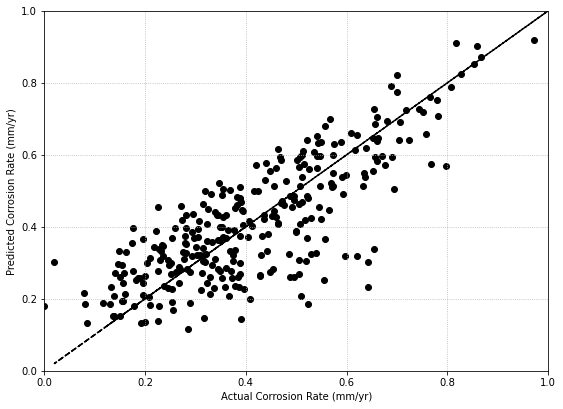

In [24]:
# calculate RMSE for cross validation
MSE = np.square(np.subtract(obj_pred,o1_test)).mean()   


print("Mean Square Error = {0:2}".format (MSE))  

RMSE = math.sqrt(MSE)  

print("Root Mean Square Error = {0:2}".format (RMSE))  

from sklearn.metrics import r2_score
R2= r2_score(o1_test,obj_pred)

print("R-sqaure = {0:2}".format (R2)) 


fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(7,5)

ax = fig.add_axes([0,0,1,1])

#plt.rc('grid', linestyle="-", color='black')

plt.plot(obj,obj,color='black',linestyle='dashed')

plt.scatter(o1_test,obj_pred,marker="o",color='black')

plt.xlim(0,1)
plt.ylim(0,1)

# plt.legend (['Current model','Empirical correlation','Nesic et al.(1995)'], loc='upper left')

plt.xlabel ("Actual Corrosion Rate (mm/yr)")
plt.ylabel ("Predicted Corrosion Rate (mm/yr)")

plt.grid(linestyle=':')
    
#plt.savefig('ANN Predictions',bbox_inches='tight', dpi=150)

plt.show()